<a href="https://colab.research.google.com/github/zabir173/Amazon-Books-Recommendation-System/blob/master/NewsSummarizationTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import re
import os
import time
import numpy as np
import pandas as pd 
import unicodedata
import tensorflow as tf
import tensorflow.keras as krs
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import csv

BUFFER_SIZE = 20000
BATCH_SIZE = 64
embedding_dim = 50 # first it was 200

### **Pre-process** the data

In [17]:
from sklearn.utils import shuffle
df = pd.read_excel('sample_data/Inshorts Cleaned Data.xlsx')
# shuffling the data 
df = shuffle(df)
df.head()

Headline  ... Publish Date
12669    Bengaluru molestation case shameful: Aamir Khan  ...   2017-01-04
25689  Kashmir tourism suffers ₹4,000 crore loss amid...  ...   2016-10-16
9820   Honour of my life to serve the US: Obama in fa...  ...   2017-01-20
188    India finish with 13 medals at para Athletics ...  ...   2017-03-24
38491         India to host Kabaddi World Cup in October  ...   2016-07-31

[5 rows x 5 columns]

In [18]:
summaries=pd.DataFrame()
summaries['Short'] = df['Short']
summaries['Headline'] = df['Headline']

### Cleaning the data for training

In [19]:
# replacing many abbreviations and lower casing the words
def clean_words(sentence):
    sentence = str(sentence).lower()
    sentence = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
    sentence = re.sub(r"http\S+","",sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r"'til", "until", sentence)
    sentence = re.sub(r"\"", "", sentence)
    sentence = re.sub(r"\'", "", sentence)
    sentence = re.sub(r' s ', "",sentence)
    sentence = re.sub(r"&39", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"&34", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]", "", sentence)
    sentence = re.sub(r"&", "", sentence)
    sentence = re.sub(r"\\n", "", sentence)
    sentence = sentence.strip()
    return sentence

def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')
  
def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  #w = unicode_to_ascii('<go> ') + w + unicode_to_ascii(' <stop>')
  return w


In [20]:
summaries['Short'] = summaries['Short'].apply(lambda x: clean_words(x))
summaries['Short'] = summaries['Short'].apply(lambda x: preprocess_sentence(x))
summaries['Headline'] = summaries['Headline'].apply(lambda x: preprocess_sentence(x))

In [21]:
# adding start and end token to the senteces of label 
start_token, end_token = '<startseq>' , '<endseq>'
summaries = summaries.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
summaries.head()

Short                                           Headline
12669  <startseq> aamir khan has said that the molest...  <startseq> bengaluru molestation case shameful...
25689  <startseq> amid the ongoing unrest in the kash...  <startseq> kashmir tourism suffers , crore los...
9820   <startseq> addressing the country in his final...  <startseq> honour of my life to serve the us o...
188    <startseq> indias para athletes won medals in ...  <startseq> india finish with medals at para at...
38491  <startseq> india is set to host the edition of...  <startseq> india to host kabaddi world cup in ...

In [22]:
val_split = 0.1
# train validation split
summaries_train = summaries[int(len(summaries)*val_split):]
summaries_val = summaries[:int(len(summaries)*val_split)]

finding the maximum length of questions and answers

In [23]:
# because there are senteces with unusually long lengths, 
# we caculate the max length that 95% of sentences are shorter than that
def max_length(shorts, heads, prct):
    # Create a list of all the captions
    
    length_heads = list(len(d.split()) for d in heads)
    length_shorts = list(len(d.split()) for d in shorts)

    print('percentile {} of length of news: {}'.format(prct,np.percentile(length_heads, prct)))
    print('longest sentence: ', max(length_heads))
    print()
    print('percentile {} of length of summaries: {}'.format(prct,np.percentile(length_shorts, prct)))
    print('longest sentence: ', max(length_shorts))
    print()
    return int(np.percentile(length_heads, prct)),int(np.percentile(length_shorts, prct))

# selecting sentence length based on the percentile of data that fits in the length
max_len_summary, max_len_news= max_length(summaries_train['Short'].to_list(), summaries_train['Headline'].to_list(), 95)


print('max-length article chosen for training: ', max_len_news)
print('max-length headline chosen for training: ', max_len_summary)

percentile 95 of length of news: 13.0
longest sentence:  20

percentile 95 of length of summaries: 62.0
longest sentence:  67

max-length article chosen for training:  62
max-length headline chosen for training:  13


### Vocabilary prepration


In [24]:
# making a vocabulary of the words 
def create_vocab(shorts, minimum_repeat = 3):

    # Create a list of all the captions
    all_captions = []
    for s in shorts:
        all_captions.append(s)

    # Consider only words which occur at least minimum_occurrence times in the corpus
    h = {}
    for each in all_captions:
        for w in each.split(' '):
            h[w] = h.get(w, 0) + 1

    vocab = [w for w in h if h[w] >= minimum_repeat]
    vocab = list(set(vocab))
    return vocab

In [25]:
# each word in the vocabulary must be used in the data atleast minimum_repeat times
vocab_dec = create_vocab(summaries_train['Short'].to_list(), minimum_repeat=5) # here we just use the words in vocabulary of summaries
# removing one character words from vocab except for 'a'
for each in vocab_dec:
    if len(each) == 1 and each!='a' and each!='i':
        vocab_dec.remove(each) 

vocab_dec = sorted(vocab_dec)[1:] # [1:] is for the '' 
vocab_dec[:5]

['<startseq>', 'a', 'aa', 'aadhaar', 'aadhaarbased']

In [26]:
# each word in the vocabulary must be used in the data atleast minimum_repeat times
vocab_enc = create_vocab(summaries_train['Headline'].to_list(), minimum_repeat=3) # here we just use the words in vocabulary of summaries
# removing one character words from vocab except for 'a'
for each in vocab_enc:
    if len(each) == 1 and each!='a' and each!='i':
        vocab_enc.remove(each) 
        
vocab_enc = sorted(vocab_enc)[1:] # [1:] is for the '' 
vocab_enc[11001:11004]

['toy', 'toyota', 'toys']

Define **Tokenizer** and then calculate the vocabulary size which is important for positional encoding

In [29]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
headline_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters,oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters,oov_token=oov_token) 

headline_tokenizer.fit_on_texts(vocab_enc)
summary_tokenizer.fit_on_texts(vocab_dec)

# number of words in vocabulary of encoder and decoder
encoder_vocab_size = len(headline_tokenizer.word_index) + 1 
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

encoder_vocab_size, decoder_vocab_size

(12041, 23553)

In [30]:
# assign a number to each word inorder to find it in word embeddings
inputs = headline_tokenizer.texts_to_sequences(summaries_train['Headline'])
targets = summary_tokenizer.texts_to_sequences(summaries_train['Short'])

inputs_val = headline_tokenizer.texts_to_sequences(summaries_val['Headline'])
targets_val = summary_tokenizer.texts_to_sequences(summaries_val['Short'])

**Truncating** and **padding**

In [31]:
inputs = krs.preprocessing.sequence.pad_sequences(inputs, maxlen=max_len_news, padding='post', truncating='post')
targets = krs.preprocessing.sequence.pad_sequences(targets, maxlen=max_len_summary, padding='post', truncating='post')

inputs_val = krs.preprocessing.sequence.pad_sequences(inputs_val, maxlen=max_len_news, padding='post', truncating='post')
targets_val = krs.preprocessing.sequence.pad_sequences(targets_val, maxlen=max_len_summary, padding='post', truncating='post')

In [34]:
idx2word_enc = {} # index to word dic
idx2word_dec = {} # index to word dic

wordtoix_enc = headline_tokenizer.word_index # word to index dic
idx2word_enc[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0
idx2word_dec[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0

for w in headline_tokenizer.word_index:
    idx2word_enc[headline_tokenizer.word_index[w]] = w

wordtoix_dec = summary_tokenizer.word_index # word to index dic

for w in summary_tokenizer.word_index:
    idx2word_dec[summary_tokenizer.word_index[w]] = w

In [35]:
# validate train split
dataset = tf.data.Dataset.from_tensor_slices((inputs,targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((inputs_val,targets_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE*2)

### Defining the model

In [36]:
import matplotlib.pyplot as plt

def hist(history):
    plt.title('Loss')

    x= [i[0] for i in history['val']]
    y=[i[1] for i in history['val']]
    plt.plot(x,y,'x-')
    
    x= [i[0] for i in history['train']]
    y=[i[1] for i in history['train']]    
    plt.plot(x,y,'o-')

    plt.legend(['validation','train'])
    plt.show()
    print('smallest val loss:', sorted(history['val'],key=lambda x: x[1])[0])

#### Scaled Dot Product
![](files/z-score.png)
Q=q $\times$ k \\
scaledA=Q/sqrt(Q) \\
scaledA+=mask \\
mask is used to to prevent learning future refence at decoder \\
A=softmax(scaledA) \\
output=v $\times$ A \\


In [37]:
# the job of this function is to calculate the above equation
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### **multi-headed attention**
![](files/multi-head.png)
combine N head attention results for learning better input representation

In [38]:
class MultiHeadAttention(krs.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # The dimensions of Q, K, V are called depth

        # the input of these 3 layers are the same: X
        self.wq = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wk = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wv = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))

        self.dense = tf.keras.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    
    # reshape the Q,K,V 
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # learn the Q,K,V matrices (the layers' weightes)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # reshape them
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # the last dens layer expect one vector so we use concat
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

#### positional encoding

In [39]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

# The dimension of positional encodings is the same as
# the embeddings (d_model) for facilitating the summation of both.
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#### Layers

#### Embeddings preparation

In [43]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip
#!ls
#!pwd
 # Making the embedding mtrix
def make_embedding_layer(vocab_len, wordtoix, embedding_dim=200, glove=True, glove_path= ''):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        glove_dir = glove_path
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get n-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        
        print("GloVe ",embedding_dim, ' loaded!')

    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

embeddings_encoder = make_embedding_layer(encoder_vocab_size, wordtoix_enc, embedding_dim=embedding_dim, glove=True)
embeddings_decoder = make_embedding_layer(decoder_vocab_size, wordtoix_dec, embedding_dim=embedding_dim, glove=True)


Loading glove...
GloVe  50  loaded!
Loading glove...
GloVe  50  loaded!


#### transformer layers

In [50]:
# hyper-params
init_lr = 1e-3
lmbda_l2 = 0.1
d_out_rate = 0.1 # tested 0.4, 0.3, 0.1 values this 0.1 seems to be the best
num_layers = 4 # chaged from 4 to 5 to learn better
d_model = embedding_dim # d_model is the representation dimension or embedding dimension of a word (usually in the range 128–512)
dff = 512 # number of neurons in feed forward network
num_heads = 5 # first it was 8 i chenged it to 10 to use embd =300d

In [45]:
# The Point-wise feed-forward network block is essentially a 
# two-layer linear transformation which is used identically throughout the model
def point_wise_feed_forward_network(d_model, dff):
    return krs.Sequential([
        krs.layers.Dense(dff, activation='relu',kernel_regularizer=krs.regularizers.l2(l=lmbda_l2)),
        krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    ])

In [46]:
class EncoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
   
    # it has 1 layer of multi-headed attention
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [47]:
class DecoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
        self.dropout3 = krs.layers.Dropout(rate)
    
    # it has 2 layers of multi-headed attention
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [48]:
class Encoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_encoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = krs.layers.Dropout(rate)
        self.dropout_embd = krs.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x = self.dropout_embd(x, training=training) # dropout added to encoder input changed from nothing to this
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x

In [49]:
class Decoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_decoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)] # a list of decoder layers
        self.dropout = krs.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask) # enc_output is fed into it

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

#### Final model

In [51]:
class Transformer(krs.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                                     target_vocab_size, pe_input, pe_target, rate=d_out_rate):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = krs.layers.Dense(target_vocab_size, kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        
        
    # training argument is used in dropout inputs
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
       
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [52]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=max_len_news,
    pe_target=max_len_summary,
)

#### Masking


In [53]:
# Padding mask for masking "pad" sequences so 
# they won't affect the loss
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# Lookahead mask for masking future words from
# contributing in prediction of current words in self attention
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [54]:
# this function is use in training step
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
        
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

#### training

In [55]:
lr_schedule = krs.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr, # originally was 1e-5
    decay_steps=4000, # approximately 5 epochs
    decay_rate=0.95) # originally was 0.9

In [56]:

optimizer2 = Adam(lr_schedule , beta_1=0.9, beta_2=0.98, epsilon=1e-9) # changed to init
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') # added softmax changed from_logits to false

In [57]:
def loss_function(real, pred, l2= False):
 
    if l2:
        lambda_ = 0.0001
        l2_norms = [tf.nn.l2_loss(v) for v in transformer.trainable_variables]
        l2_norm = tf.reduce_sum(l2_norms)
        l2_value = lambda_ * l2_norm
        loss_ = loss_object(real, pred) + l2_value
    else:
        loss_ = loss_object(real, pred) 
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [58]:
checkpoint_path4 ="checkpoints4"

ckpt4 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer2)

ckpt_manager4 = tf.train.CheckpointManager(ckpt4, checkpoint_path4, max_to_keep=100)

# if ckpt_manager4.latest_checkpoint:
#     ckpt4.restore(ckpt_manager4.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

#### inference

In [59]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = krs.preprocessing.sequence.pad_sequences(input_document, maxlen=max_len_news, 
                                                                           padding='post', truncating='post')
    
    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_len_summary):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # stop prediciting if it reached end_token
        if predicted_id == summary_tokenizer.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # remove start_token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [60]:
def validate():
    print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):    
        tar_inp = tar[:, :-1] # <startseq> hi im moein
        tar_real = tar[:, 1:] # hi im moein <endseq>

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        # Operations are recorded if they are executed within this context manager
        # and at least one of their inputs is being "watched". Trainable variables are automatically watched
        predictions, _ = transformer(
            inp, tar_inp, 
            False, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()
# validate()

In [61]:
@tf.function # Compiles a function into a callable TensorFlow graph
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # <startseq> hi im moein
    tar_real = tar[:, 1:] # hi im moein <endseq>

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    # Operations are recorded if they are executed within this context manager
    # and at least one of their inputs is being "watched". Trainable variables are automatically watched
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer2.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # mean the loss with new computed  loss of the step
    train_loss(loss)

In [62]:
history={'val':[],'train':[]}
EPOCHS = 30
not_progressing = 0
# Computes the (weighted) mean of the given loss values.
train_loss = krs.metrics.Mean(name='train_loss')
val_loss = krs.metrics.Mean(name='val_loss')

In [63]:
params = {
'lmbda_l2' : lmbda_l2,
'd_out_rate' :d_out_rate,
'num_layers' : num_layers ,
'd_model' : d_model  ,
'dff' : dff ,
'num_heads' : num_heads,
'init_lr':init_lr}
params

{'d_model': 50,
 'd_out_rate': 0.1,
 'dff': 512,
 'init_lr': 0.001,
 'lmbda_l2': 0.1,
 'num_heads': 5,
 'num_layers': 4}

In [64]:
ep = 1
best_val_loss = np.inf
i1,i2,i3,i4 = np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val))

{'lmbda_l2': 0.1, 'd_out_rate': 0.1, 'num_layers': 4, 'd_model': 50, 'dff': 512, 'num_heads': 5, 'init_lr': 0.001}
########################################
Epoch 1 Batch 0 Loss 6.0306
Epoch 1 Batch 150 Loss 5.8869
Epoch 1 Batch 300 Loss 5.8301
Epoch 1 Batch 450 Loss 5.7701
Epoch 1 Batch 600 Loss 5.7171
Epoch 1 Batch 750 Loss 5.6750
validation started ...

* Validation loss: 5.339754104614258 

* Train Loss 5.6690

Saving checkpoint for epoch 1 at checkpoints4/ckpt-1


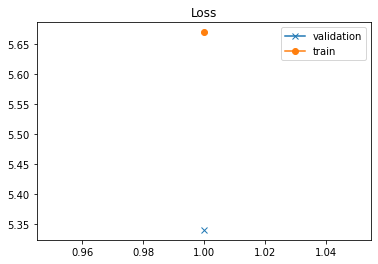

smallest val loss: (1, 5.339754)
Current Lr:  0.00098032

Time taken for this epoch: 23.14 secs

Epoch 2 Batch 0 Loss 5.3421
Epoch 2 Batch 150 Loss 5.3253
Epoch 2 Batch 300 Loss 5.3057
Epoch 2 Batch 450 Loss 5.2889
Epoch 2 Batch 600 Loss 5.2649
Epoch 2 Batch 750 Loss 5.2452
validation started ...

* Validation loss: 5.037827968597412 

* Train Loss 5.2425

Saving checkpoint for epoch 2 at checkpoints4/ckpt-2


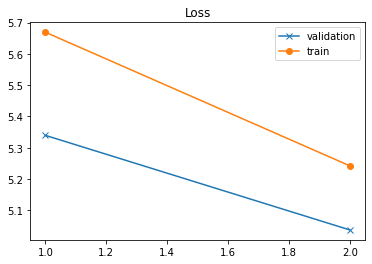

smallest val loss: (2, 5.037828)
Current Lr:  0.00097062584

Time taken for this epoch: 23.14 secs

Epoch 3 Batch 0 Loss 5.1746
Epoch 3 Batch 150 Loss 5.0294
Epoch 3 Batch 300 Loss 5.0236
Epoch 3 Batch 450 Loss 5.0112
Epoch 3 Batch 600 Loss 5.0048
Epoch 3 Batch 750 Loss 5.0013
validation started ...

* Validation loss: 4.888683795928955 

* Train Loss 5.0013

Saving checkpoint for epoch 3 at checkpoints4/ckpt-3


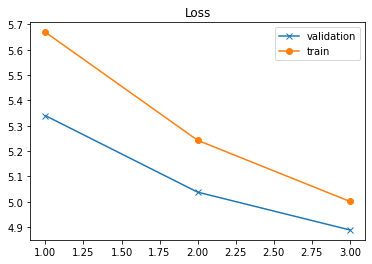

smallest val loss: (3, 4.888684)
Current Lr:  0.0009610275

Time taken for this epoch: 23.40 secs

Epoch 4 Batch 0 Loss 4.9782
Epoch 4 Batch 150 Loss 4.8585
Epoch 4 Batch 300 Loss 4.8436
Epoch 4 Batch 450 Loss 4.8425
Epoch 4 Batch 600 Loss 4.8411
Epoch 4 Batch 750 Loss 4.8395
validation started ...

* Validation loss: 4.762269496917725 

* Train Loss 4.8389

Saving checkpoint for epoch 4 at checkpoints4/ckpt-4


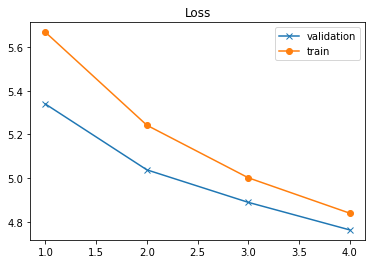

smallest val loss: (4, 4.7622695)
Current Lr:  0.00095152395

Time taken for this epoch: 23.33 secs

Epoch 5 Batch 0 Loss 4.7686
Epoch 5 Batch 150 Loss 4.7132
Epoch 5 Batch 300 Loss 4.7182
Epoch 5 Batch 450 Loss 4.7198
Epoch 5 Batch 600 Loss 4.7226
Epoch 5 Batch 750 Loss 4.7231
validation started ...

* Validation loss: 4.688394546508789 

* Train Loss 4.7240


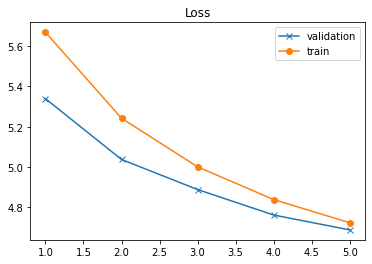

smallest val loss: (5, 4.6883945)
Current Lr:  0.00094211457

Time taken for this epoch: 23.10 secs

Epoch 6 Batch 0 Loss 4.8757
Epoch 6 Batch 150 Loss 4.6143
Epoch 6 Batch 300 Loss 4.6197
Epoch 6 Batch 450 Loss 4.6248
Epoch 6 Batch 600 Loss 4.6297
Epoch 6 Batch 750 Loss 4.6374
validation started ...

* Validation loss: 4.61041259765625 

* Train Loss 4.6383

Saving checkpoint for epoch 6 at checkpoints4/ckpt-5


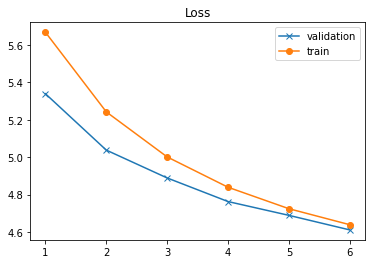

smallest val loss: (6, 4.6104126)
Current Lr:  0.0009327981

Time taken for this epoch: 23.50 secs

Epoch 7 Batch 0 Loss 4.6424
Epoch 7 Batch 150 Loss 4.5302
Epoch 7 Batch 300 Loss 4.5476
Epoch 7 Batch 450 Loss 4.5579
Epoch 7 Batch 600 Loss 4.5623
Epoch 7 Batch 750 Loss 4.5733
validation started ...

* Validation loss: 4.574540138244629 

* Train Loss 4.5738


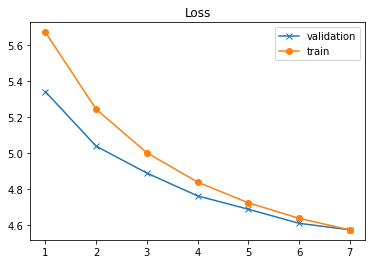

smallest val loss: (7, 4.57454)
Current Lr:  0.00092357374

Time taken for this epoch: 23.26 secs

Epoch 8 Batch 0 Loss 4.7039
Epoch 8 Batch 150 Loss 4.4818
Epoch 8 Batch 300 Loss 4.5036
Epoch 8 Batch 450 Loss 4.5045
Epoch 8 Batch 600 Loss 4.5130
Epoch 8 Batch 750 Loss 4.5196
validation started ...

* Validation loss: 4.505306720733643 

* Train Loss 4.5201

Saving checkpoint for epoch 8 at checkpoints4/ckpt-6


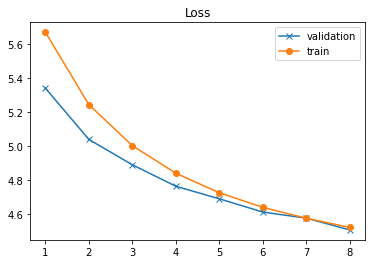

smallest val loss: (8, 4.5053067)
Current Lr:  0.0009144407

Time taken for this epoch: 23.62 secs

Epoch 9 Batch 0 Loss 4.2768
Epoch 9 Batch 150 Loss 4.4131
Epoch 9 Batch 300 Loss 4.4375
Epoch 9 Batch 450 Loss 4.4547
Epoch 9 Batch 600 Loss 4.4629
Epoch 9 Batch 750 Loss 4.4742
validation started ...

* Validation loss: 4.482860088348389 

* Train Loss 4.4753


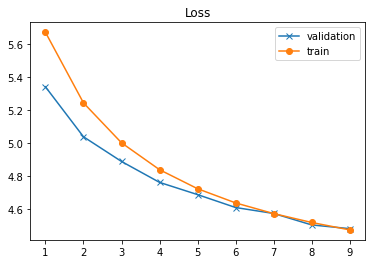

smallest val loss: (9, 4.48286)
Current Lr:  0.00090539793

Time taken for this epoch: 23.38 secs

Epoch 10 Batch 0 Loss 4.4608
Epoch 10 Batch 150 Loss 4.3831
Epoch 10 Batch 300 Loss 4.3996
Epoch 10 Batch 450 Loss 4.4086
Epoch 10 Batch 600 Loss 4.4203
Epoch 10 Batch 750 Loss 4.4333
validation started ...

* Validation loss: 4.450608253479004 

* Train Loss 4.4355


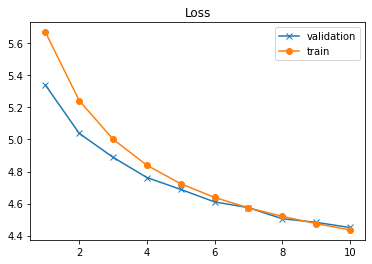

smallest val loss: (10, 4.4506083)
Current Lr:  0.00089644454

Time taken for this epoch: 23.39 secs

Epoch 11 Batch 0 Loss 4.2074
Epoch 11 Batch 150 Loss 4.3518
Epoch 11 Batch 300 Loss 4.3754
Epoch 11 Batch 450 Loss 4.3875
Epoch 11 Batch 600 Loss 4.3953
Epoch 11 Batch 750 Loss 4.4027
validation started ...

* Validation loss: 4.433664321899414 

* Train Loss 4.4030


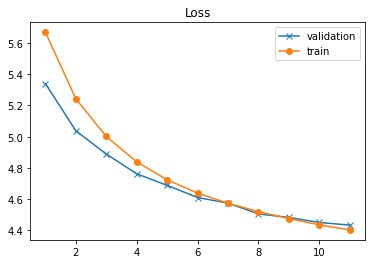

smallest val loss: (11, 4.4336643)
Current Lr:  0.00088757975

Time taken for this epoch: 23.42 secs

Epoch 12 Batch 0 Loss 4.5064
Epoch 12 Batch 150 Loss 4.3172
Epoch 12 Batch 300 Loss 4.3288
Epoch 12 Batch 450 Loss 4.3465
Epoch 12 Batch 600 Loss 4.3609
Epoch 12 Batch 750 Loss 4.3695
validation started ...

* Validation loss: 4.387627124786377 

* Train Loss 4.3717

Saving checkpoint for epoch 12 at checkpoints4/ckpt-7


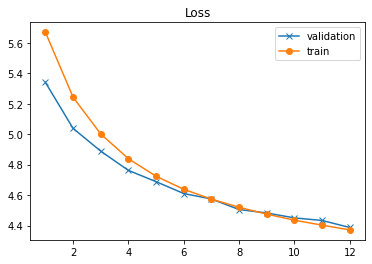

smallest val loss: (12, 4.387627)
Current Lr:  0.00087880256

Time taken for this epoch: 23.73 secs

Epoch 13 Batch 0 Loss 4.4317
Epoch 13 Batch 150 Loss 4.2865
Epoch 13 Batch 300 Loss 4.3089
Epoch 13 Batch 450 Loss 4.3177
Epoch 13 Batch 600 Loss 4.3263
Epoch 13 Batch 750 Loss 4.3388
validation started ...

* Validation loss: 4.372676372528076 

* Train Loss 4.3400


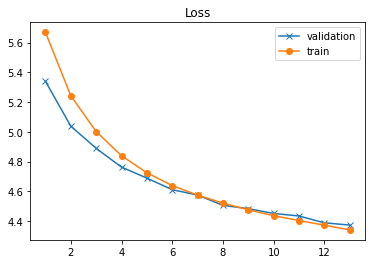

smallest val loss: (13, 4.3726764)
Current Lr:  0.0008701122

Time taken for this epoch: 23.56 secs

Epoch 14 Batch 0 Loss 4.1469
Epoch 14 Batch 150 Loss 4.2740
Epoch 14 Batch 300 Loss 4.2866
Epoch 14 Batch 450 Loss 4.2920
Epoch 14 Batch 600 Loss 4.2982
Epoch 14 Batch 750 Loss 4.3105
validation started ...

* Validation loss: 4.324000835418701 

* Train Loss 4.3122


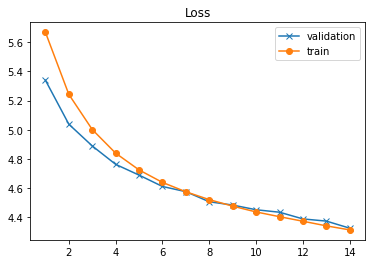

smallest val loss: (14, 4.324001)
Current Lr:  0.00086150784

Time taken for this epoch: 23.46 secs

Epoch 15 Batch 0 Loss 4.3712
Epoch 15 Batch 150 Loss 4.2343
Epoch 15 Batch 300 Loss 4.2513
Epoch 15 Batch 450 Loss 4.2630
Epoch 15 Batch 600 Loss 4.2755
Epoch 15 Batch 750 Loss 4.2877
validation started ...

* Validation loss: 4.323175430297852 

* Train Loss 4.2893


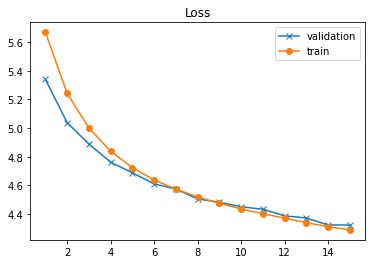

smallest val loss: (15, 4.3231754)
Current Lr:  0.00085298845

Time taken for this epoch: 23.46 secs

Epoch 16 Batch 0 Loss 4.2504
Epoch 16 Batch 150 Loss 4.2124
Epoch 16 Batch 300 Loss 4.2336
Epoch 16 Batch 450 Loss 4.2395
Epoch 16 Batch 600 Loss 4.2464
Epoch 16 Batch 750 Loss 4.2590
validation started ...

* Validation loss: 4.267592906951904 

* Train Loss 4.2617

Saving checkpoint for epoch 16 at checkpoints4/ckpt-8


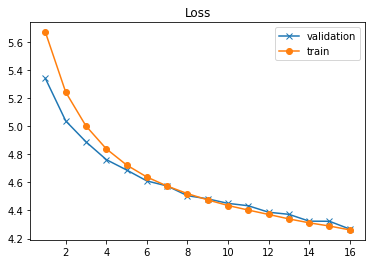

smallest val loss: (16, 4.267593)
Current Lr:  0.0008445534

Time taken for this epoch: 23.77 secs

Epoch 17 Batch 0 Loss 4.0706
Epoch 17 Batch 150 Loss 4.1778
Epoch 17 Batch 300 Loss 4.1957
Epoch 17 Batch 450 Loss 4.2155
Epoch 17 Batch 600 Loss 4.2299
Epoch 17 Batch 750 Loss 4.2370
validation started ...

* Validation loss: 4.261476039886475 

* Train Loss 4.2398


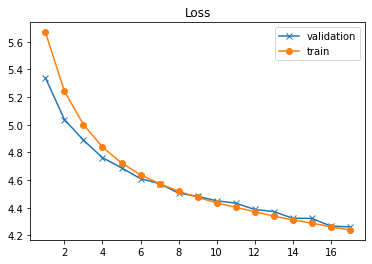

smallest val loss: (17, 4.261476)
Current Lr:  0.00083620177

Time taken for this epoch: 23.45 secs

Epoch 18 Batch 0 Loss 4.0372
Epoch 18 Batch 150 Loss 4.1397
Epoch 18 Batch 300 Loss 4.1680
Epoch 18 Batch 450 Loss 4.1880
Epoch 18 Batch 600 Loss 4.2024
Epoch 18 Batch 750 Loss 4.2144
validation started ...

* Validation loss: 4.239199638366699 

* Train Loss 4.2163


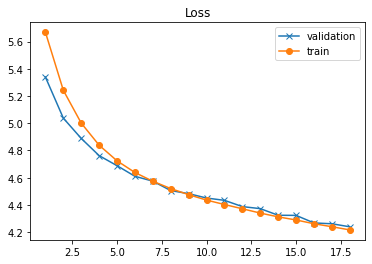

smallest val loss: (18, 4.2391996)
Current Lr:  0.0008279326

Time taken for this epoch: 23.48 secs

Epoch 19 Batch 0 Loss 4.2796
Epoch 19 Batch 150 Loss 4.1407
Epoch 19 Batch 300 Loss 4.1588
Epoch 19 Batch 450 Loss 4.1737
Epoch 19 Batch 600 Loss 4.1808
Epoch 19 Batch 750 Loss 4.1911
validation started ...

* Validation loss: 4.2476091384887695 

* Train Loss 4.1940


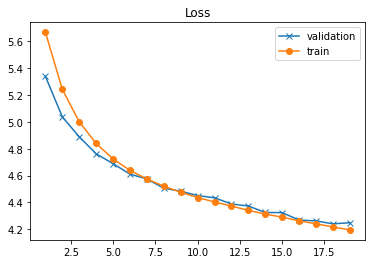

smallest val loss: (18, 4.2391996)
Current Lr:  0.0008197454

Time taken for this epoch: 23.54 secs

Epoch 20 Batch 0 Loss 4.0855
Epoch 20 Batch 150 Loss 4.1260
Epoch 20 Batch 300 Loss 4.1344
Epoch 20 Batch 450 Loss 4.1551
Epoch 20 Batch 600 Loss 4.1618
Epoch 20 Batch 750 Loss 4.1734
validation started ...

* Validation loss: 4.224338054656982 

* Train Loss 4.1762


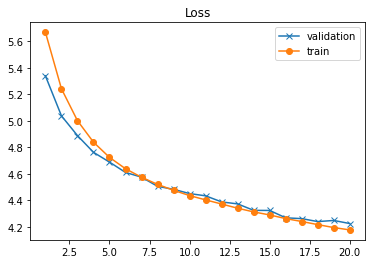

smallest val loss: (20, 4.224338)
Current Lr:  0.00081163907

Time taken for this epoch: 23.47 secs

Epoch 21 Batch 0 Loss 4.2147
Epoch 21 Batch 150 Loss 4.0816
Epoch 21 Batch 300 Loss 4.1059
Epoch 21 Batch 450 Loss 4.1274
Epoch 21 Batch 600 Loss 4.1412
Epoch 21 Batch 750 Loss 4.1551
validation started ...

* Validation loss: 4.191835403442383 

* Train Loss 4.1578


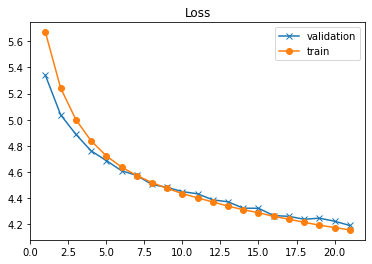

smallest val loss: (21, 4.1918354)
Current Lr:  0.0008036128

Time taken for this epoch: 23.54 secs

Epoch 22 Batch 0 Loss 4.0727
Epoch 22 Batch 150 Loss 4.0596
Epoch 22 Batch 300 Loss 4.0942
Epoch 22 Batch 450 Loss 4.1101
Epoch 22 Batch 600 Loss 4.1272
Epoch 22 Batch 750 Loss 4.1385
validation started ...

* Validation loss: 4.168691158294678 

* Train Loss 4.1397


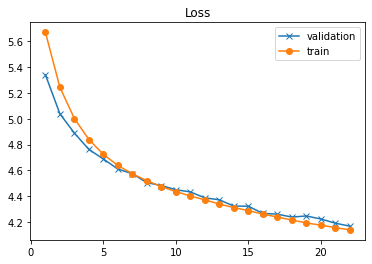

smallest val loss: (22, 4.168691)
Current Lr:  0.000795666

Time taken for this epoch: 23.54 secs

Epoch 23 Batch 0 Loss 3.9556
Epoch 23 Batch 150 Loss 4.0532
Epoch 23 Batch 300 Loss 4.0756
Epoch 23 Batch 450 Loss 4.0962
Epoch 23 Batch 600 Loss 4.1098
Epoch 23 Batch 750 Loss 4.1219
validation started ...

* Validation loss: 4.18876314163208 

* Train Loss 4.1252


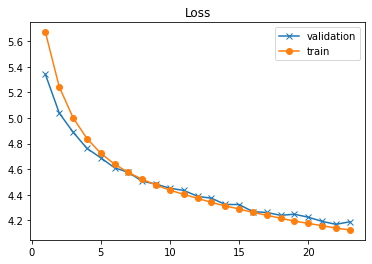

smallest val loss: (22, 4.168691)
Current Lr:  0.0007877978

Time taken for this epoch: 23.54 secs

Epoch 24 Batch 0 Loss 4.3083
Epoch 24 Batch 150 Loss 4.0563
Epoch 24 Batch 300 Loss 4.0721
Epoch 24 Batch 450 Loss 4.0841
Epoch 24 Batch 600 Loss 4.0990
Epoch 24 Batch 750 Loss 4.1107
validation started ...

* Validation loss: 4.152360439300537 

* Train Loss 4.1115

Saving checkpoint for epoch 24 at checkpoints4/ckpt-9


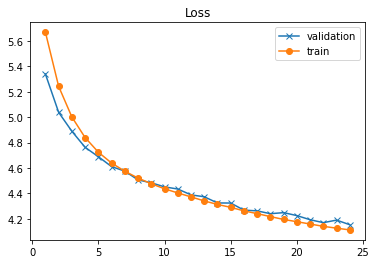

smallest val loss: (24, 4.1523604)
Current Lr:  0.00078000734

Time taken for this epoch: 23.78 secs

Epoch 25 Batch 0 Loss 4.1616
Epoch 25 Batch 150 Loss 4.0315
Epoch 25 Batch 300 Loss 4.0582
Epoch 25 Batch 450 Loss 4.0686
Epoch 25 Batch 600 Loss 4.0799
Epoch 25 Batch 750 Loss 4.0934
validation started ...

* Validation loss: 4.150386333465576 

* Train Loss 4.0971


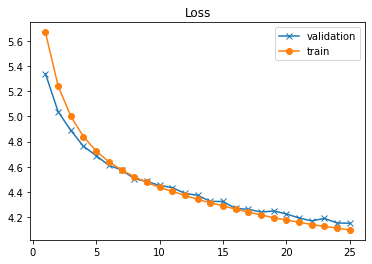

smallest val loss: (25, 4.1503863)
Current Lr:  0.00077229395

Time taken for this epoch: 23.53 secs

Epoch 26 Batch 0 Loss 4.1242
Epoch 26 Batch 150 Loss 4.0281
Epoch 26 Batch 300 Loss 4.0571
Epoch 26 Batch 450 Loss 4.0601
Epoch 26 Batch 600 Loss 4.0720
Epoch 26 Batch 750 Loss 4.0838
validation started ...

* Validation loss: 4.15344762802124 

* Train Loss 4.0858


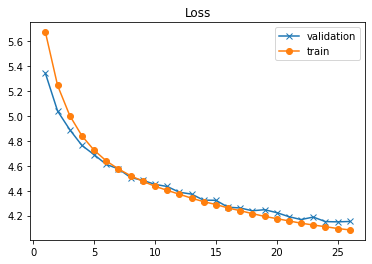

smallest val loss: (25, 4.1503863)
Current Lr:  0.00076465687

Time taken for this epoch: 23.60 secs

Epoch 27 Batch 0 Loss 4.0323
Epoch 27 Batch 150 Loss 4.0120
Epoch 27 Batch 300 Loss 4.0368
Epoch 27 Batch 450 Loss 4.0522
Epoch 27 Batch 600 Loss 4.0613
Epoch 27 Batch 750 Loss 4.0742
validation started ...

* Validation loss: 4.146704196929932 

* Train Loss 4.0758


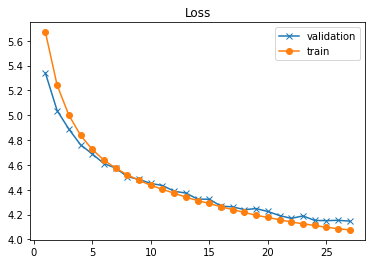

smallest val loss: (27, 4.146704)
Current Lr:  0.00075709523

Time taken for this epoch: 23.48 secs

Epoch 28 Batch 0 Loss 3.9326
Epoch 28 Batch 150 Loss 3.9926
Epoch 28 Batch 300 Loss 4.0229
Epoch 28 Batch 450 Loss 4.0382
Epoch 28 Batch 600 Loss 4.0475
Epoch 28 Batch 750 Loss 4.0593
validation started ...

* Validation loss: 4.136546611785889 

* Train Loss 4.0618


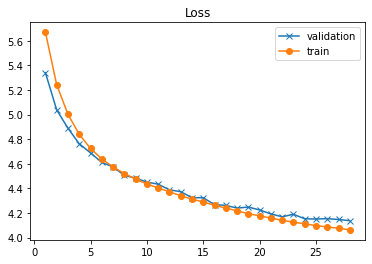

smallest val loss: (28, 4.1365466)
Current Lr:  0.0007496085

Time taken for this epoch: 23.46 secs

Epoch 29 Batch 0 Loss 3.9495
Epoch 29 Batch 150 Loss 3.9864
Epoch 29 Batch 300 Loss 4.0121
Epoch 29 Batch 450 Loss 4.0235
Epoch 29 Batch 600 Loss 4.0391
Epoch 29 Batch 750 Loss 4.0498
validation started ...

* Validation loss: 4.132808208465576 

* Train Loss 4.0524


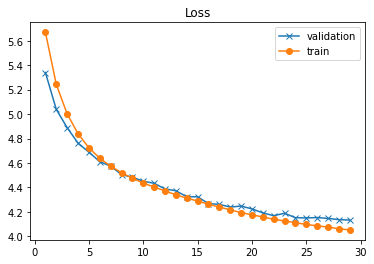

smallest val loss: (29, 4.132808)
Current Lr:  0.0007421957

Time taken for this epoch: 27.98 secs

Epoch 30 Batch 0 Loss 3.6750
Epoch 30 Batch 150 Loss 3.9788
Epoch 30 Batch 300 Loss 4.0006
Epoch 30 Batch 450 Loss 4.0123
Epoch 30 Batch 600 Loss 4.0291
Epoch 30 Batch 750 Loss 4.0425
validation started ...

* Validation loss: 4.1335978507995605 

* Train Loss 4.0433


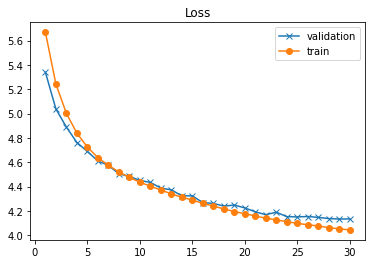

smallest val loss: (29, 4.132808)
Current Lr:  0.00073485624

Time taken for this epoch: 23.36 secs

Epoch 31 Batch 0 Loss 4.0820
Epoch 31 Batch 150 Loss 3.9637
Epoch 31 Batch 300 Loss 3.9776
Epoch 31 Batch 450 Loss 4.0029
Epoch 31 Batch 600 Loss 4.0189
Epoch 31 Batch 750 Loss 4.0346
validation started ...

* Validation loss: 4.08467435836792 

* Train Loss 4.0357


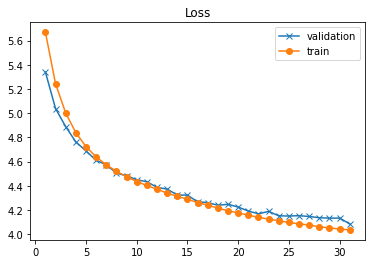

smallest val loss: (31, 4.0846744)
Current Lr:  0.00072758936

Time taken for this epoch: 23.79 secs

Epoch 32 Batch 0 Loss 3.6893
Epoch 32 Batch 150 Loss 3.9585
Epoch 32 Batch 300 Loss 3.9810
Epoch 32 Batch 450 Loss 3.9943
Epoch 32 Batch 600 Loss 4.0076
Epoch 32 Batch 750 Loss 4.0215
validation started ...

* Validation loss: 4.08677864074707 

* Train Loss 4.0239


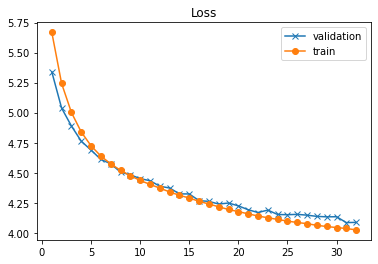

smallest val loss: (31, 4.0846744)
Current Lr:  0.00072039437

Time taken for this epoch: 23.46 secs

Epoch 33 Batch 0 Loss 3.7763
Epoch 33 Batch 150 Loss 3.9548
Epoch 33 Batch 300 Loss 3.9609
Epoch 33 Batch 450 Loss 3.9814
Epoch 33 Batch 600 Loss 3.9972
Epoch 33 Batch 750 Loss 4.0126
validation started ...

* Validation loss: 4.129629611968994 

* Train Loss 4.0142


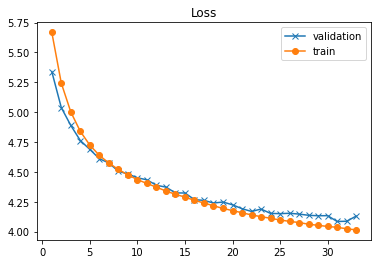

smallest val loss: (31, 4.0846744)
Current Lr:  0.0007132704

Time taken for this epoch: 23.38 secs

Epoch 34 Batch 0 Loss 3.9612
Epoch 34 Batch 150 Loss 3.9458
Epoch 34 Batch 300 Loss 3.9586
Epoch 34 Batch 450 Loss 3.9774
Epoch 34 Batch 600 Loss 3.9900
Epoch 34 Batch 750 Loss 4.0033
validation started ...

* Validation loss: 4.083973407745361 

* Train Loss 4.0071


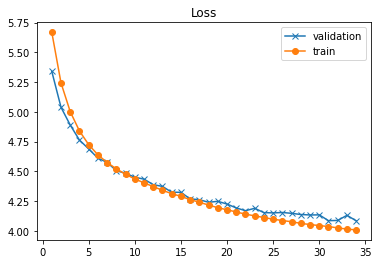

smallest val loss: (34, 4.0839734)
Current Lr:  0.000706217

Time taken for this epoch: 23.54 secs

Epoch 35 Batch 0 Loss 3.8831
Epoch 35 Batch 150 Loss 3.9283
Epoch 35 Batch 300 Loss 3.9468
Epoch 35 Batch 450 Loss 3.9642
Epoch 35 Batch 600 Loss 3.9783
Epoch 35 Batch 750 Loss 3.9934
validation started ...

* Validation loss: 4.076507568359375 

* Train Loss 3.9955


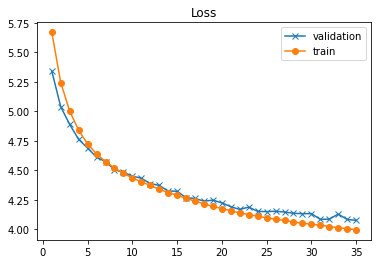

smallest val loss: (35, 4.0765076)
Current Lr:  0.00069923326

Time taken for this epoch: 23.39 secs

Epoch 36 Batch 0 Loss 3.8252
Epoch 36 Batch 150 Loss 3.9125
Epoch 36 Batch 300 Loss 3.9378
Epoch 36 Batch 450 Loss 3.9519
Epoch 36 Batch 600 Loss 3.9649
Epoch 36 Batch 750 Loss 3.9861
validation started ...

* Validation loss: 4.105679512023926 

* Train Loss 3.9896


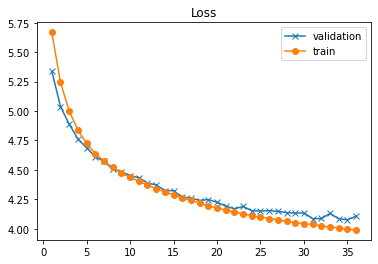

smallest val loss: (35, 4.0765076)
Current Lr:  0.0006923187

Time taken for this epoch: 23.52 secs

Epoch 37 Batch 0 Loss 3.7328
Epoch 37 Batch 150 Loss 3.9032
Epoch 37 Batch 300 Loss 3.9243
Epoch 37 Batch 450 Loss 3.9441
Epoch 37 Batch 600 Loss 3.9605
Epoch 37 Batch 750 Loss 3.9747
validation started ...

* Validation loss: 4.0708231925964355 

* Train Loss 3.9780


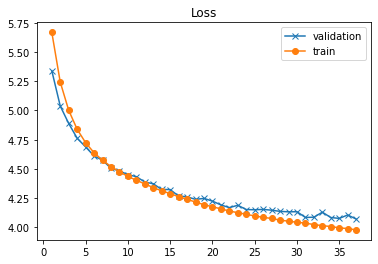

smallest val loss: (37, 4.070823)
Current Lr:  0.00068547245

Time taken for this epoch: 23.40 secs

Epoch 38 Batch 0 Loss 3.8407
Epoch 38 Batch 150 Loss 3.8975
Epoch 38 Batch 300 Loss 3.9238
Epoch 38 Batch 450 Loss 3.9354
Epoch 38 Batch 600 Loss 3.9469
Epoch 38 Batch 750 Loss 3.9656
validation started ...

* Validation loss: 4.102777481079102 

* Train Loss 3.9675


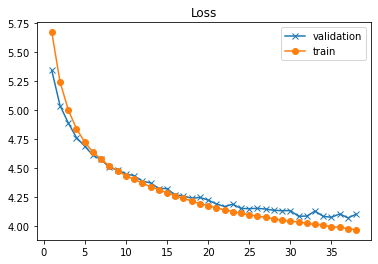

smallest val loss: (37, 4.070823)
Current Lr:  0.00067869393

Time taken for this epoch: 23.47 secs

Epoch 39 Batch 0 Loss 3.7933
Epoch 39 Batch 150 Loss 3.8838
Epoch 39 Batch 300 Loss 3.9143
Epoch 39 Batch 450 Loss 3.9263
Epoch 39 Batch 600 Loss 3.9417
Epoch 39 Batch 750 Loss 3.9567
validation started ...

* Validation loss: 4.069589614868164 

* Train Loss 3.9600


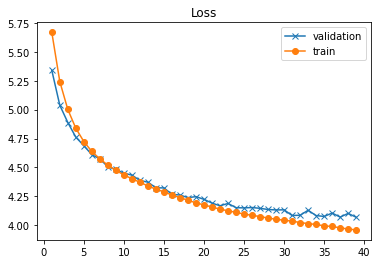

smallest val loss: (39, 4.0695896)
Current Lr:  0.0006719824

Time taken for this epoch: 23.44 secs

Epoch 40 Batch 0 Loss 3.9708
Epoch 40 Batch 150 Loss 3.8725
Epoch 40 Batch 300 Loss 3.9054
Epoch 40 Batch 450 Loss 3.9175
Epoch 40 Batch 600 Loss 3.9261
Epoch 40 Batch 750 Loss 3.9490
validation started ...

* Validation loss: 4.069543361663818 

* Train Loss 3.9506


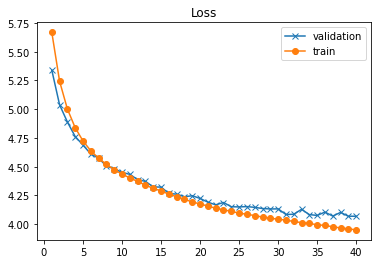

smallest val loss: (40, 4.0695434)
Current Lr:  0.0006653373

Time taken for this epoch: 23.45 secs

Epoch 41 Batch 0 Loss 3.9414
Epoch 41 Batch 150 Loss 3.8562
Epoch 41 Batch 300 Loss 3.8885
Epoch 41 Batch 450 Loss 3.9078
Epoch 41 Batch 600 Loss 3.9231
Epoch 41 Batch 750 Loss 3.9393
validation started ...

* Validation loss: 4.072055339813232 

* Train Loss 3.9407


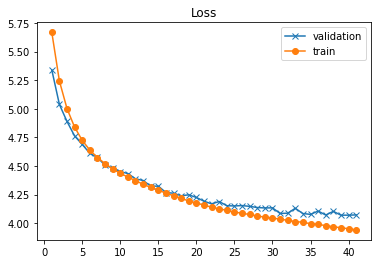

smallest val loss: (40, 4.0695434)
Current Lr:  0.0006587578

Time taken for this epoch: 23.48 secs

Epoch 42 Batch 0 Loss 3.9835
Epoch 42 Batch 150 Loss 3.8476
Epoch 42 Batch 300 Loss 3.8863
Epoch 42 Batch 450 Loss 3.9019
Epoch 42 Batch 600 Loss 3.9135
Epoch 42 Batch 750 Loss 3.9304
validation started ...

* Validation loss: 4.0578718185424805 

* Train Loss 3.9336


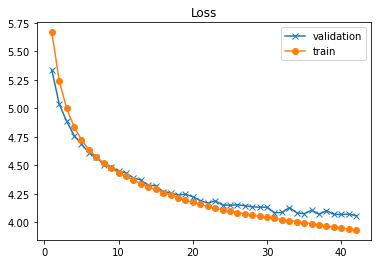

smallest val loss: (42, 4.057872)
Current Lr:  0.0006522435

Time taken for this epoch: 23.40 secs

Epoch 43 Batch 0 Loss 3.8583
Epoch 43 Batch 150 Loss 3.8504
Epoch 43 Batch 300 Loss 3.8695
Epoch 43 Batch 450 Loss 3.8882
Epoch 43 Batch 600 Loss 3.9041
Epoch 43 Batch 750 Loss 3.9241
validation started ...

* Validation loss: 4.065029621124268 

* Train Loss 3.9265


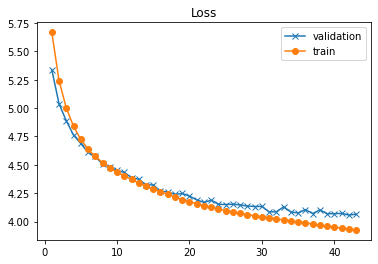

smallest val loss: (42, 4.057872)
Current Lr:  0.00064579357

Time taken for this epoch: 23.51 secs

Epoch 44 Batch 0 Loss 3.6785
Epoch 44 Batch 150 Loss 3.8446
Epoch 44 Batch 300 Loss 3.8584
Epoch 44 Batch 450 Loss 3.8727
Epoch 44 Batch 600 Loss 3.8940
Epoch 44 Batch 750 Loss 3.9116
validation started ...

* Validation loss: 4.059821128845215 

* Train Loss 3.9159


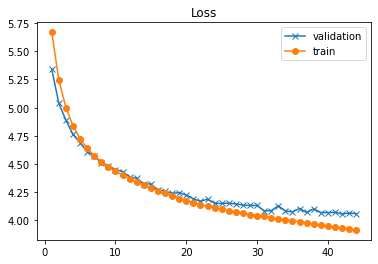

smallest val loss: (42, 4.057872)
Current Lr:  0.0006394074

Time taken for this epoch: 23.49 secs

Epoch 45 Batch 0 Loss 3.7514
Epoch 45 Batch 150 Loss 3.8267
Epoch 45 Batch 300 Loss 3.8587
Epoch 45 Batch 450 Loss 3.8766
Epoch 45 Batch 600 Loss 3.8891
Epoch 45 Batch 750 Loss 3.9069
validation started ...

* Validation loss: 4.0501322746276855 

* Train Loss 3.9095

Saving checkpoint for epoch 45 at checkpoints4/ckpt-10


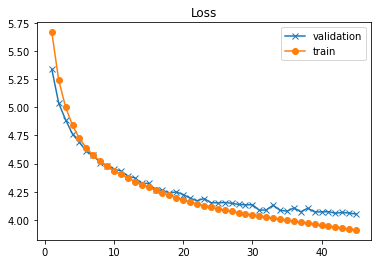

smallest val loss: (45, 4.0501323)
Current Lr:  0.0006330844

Time taken for this epoch: 28.25 secs

Epoch 46 Batch 0 Loss 3.4772
Epoch 46 Batch 150 Loss 3.8212
Epoch 46 Batch 300 Loss 3.8485
Epoch 46 Batch 450 Loss 3.8631
Epoch 46 Batch 600 Loss 3.8825
Epoch 46 Batch 750 Loss 3.8990
validation started ...

* Validation loss: 4.047224044799805 

* Train Loss 3.9008


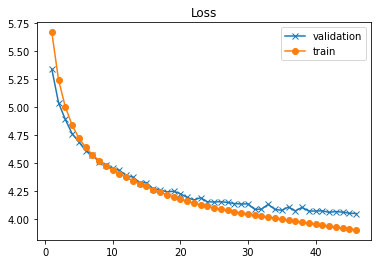

smallest val loss: (46, 4.047224)
Current Lr:  0.00062682386

Time taken for this epoch: 23.44 secs

Epoch 47 Batch 0 Loss 3.6032
Epoch 47 Batch 150 Loss 3.8298
Epoch 47 Batch 300 Loss 3.8453
Epoch 47 Batch 450 Loss 3.8561
Epoch 47 Batch 600 Loss 3.8733
Epoch 47 Batch 750 Loss 3.8900
validation started ...

* Validation loss: 4.016101360321045 

* Train Loss 3.8944


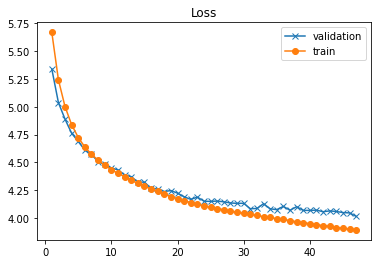

smallest val loss: (47, 4.0161014)
Current Lr:  0.00062062533

Time taken for this epoch: 23.41 secs

Epoch 48 Batch 0 Loss 4.0610
Epoch 48 Batch 150 Loss 3.8005
Epoch 48 Batch 300 Loss 3.8247
Epoch 48 Batch 450 Loss 3.8499
Epoch 48 Batch 600 Loss 3.8655
Epoch 48 Batch 750 Loss 3.8813
validation started ...

* Validation loss: 4.019525051116943 

* Train Loss 3.8838


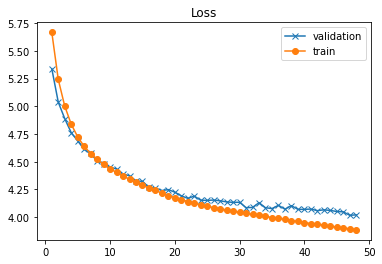

smallest val loss: (47, 4.0161014)
Current Lr:  0.00061448803

Time taken for this epoch: 23.61 secs

Epoch 49 Batch 0 Loss 3.7705
Epoch 49 Batch 150 Loss 3.8104
Epoch 49 Batch 300 Loss 3.8307
Epoch 49 Batch 450 Loss 3.8426
Epoch 49 Batch 600 Loss 3.8565
Epoch 49 Batch 750 Loss 3.8758
validation started ...

* Validation loss: 4.025182723999023 

* Train Loss 3.8778


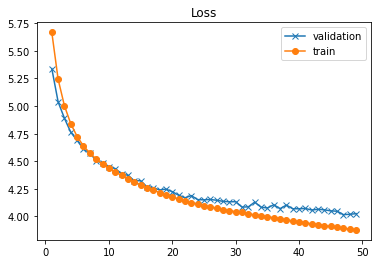

smallest val loss: (47, 4.0161014)
Current Lr:  0.00060841144

Time taken for this epoch: 23.56 secs

Epoch 50 Batch 0 Loss 3.7697
Epoch 50 Batch 150 Loss 3.7767
Epoch 50 Batch 300 Loss 3.8205
Epoch 50 Batch 450 Loss 3.8377
Epoch 50 Batch 600 Loss 3.8542
Epoch 50 Batch 750 Loss 3.8683
validation started ...

* Validation loss: 4.018326282501221 

* Train Loss 3.8715


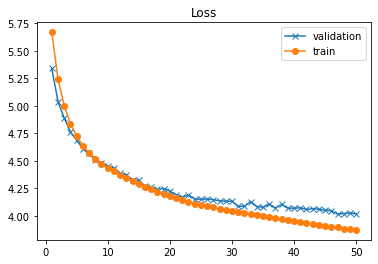

smallest val loss: (47, 4.0161014)
Current Lr:  0.0006023949

Time taken for this epoch: 23.46 secs

Epoch 51 Batch 0 Loss 3.6000
Epoch 51 Batch 150 Loss 3.7793
Epoch 51 Batch 300 Loss 3.8118
Epoch 51 Batch 450 Loss 3.8328
Epoch 51 Batch 600 Loss 3.8483
Epoch 51 Batch 750 Loss 3.8635
validation started ...

* Validation loss: 4.0307769775390625 

* Train Loss 3.8655


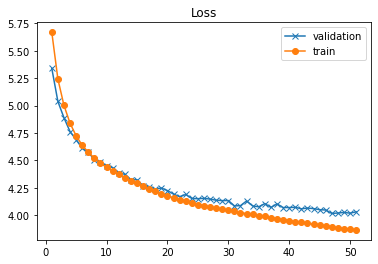

smallest val loss: (47, 4.0161014)
Current Lr:  0.000596438

Time taken for this epoch: 23.52 secs

Epoch 52 Batch 0 Loss 3.8985
Epoch 52 Batch 150 Loss 3.7872
Epoch 52 Batch 300 Loss 3.8139
Epoch 52 Batch 450 Loss 3.8281
Epoch 52 Batch 600 Loss 3.8341
Epoch 52 Batch 750 Loss 3.8533
validation started ...

* Validation loss: 4.0208740234375 

* Train Loss 3.8568


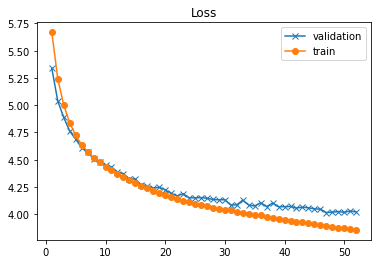

smallest val loss: (47, 4.0161014)
Current Lr:  0.0005905398

Time taken for this epoch: 23.53 secs

Epoch 53 Batch 0 Loss 3.8125
Epoch 53 Batch 150 Loss 3.7688
Epoch 53 Batch 300 Loss 3.8014
Epoch 53 Batch 450 Loss 3.8191
Epoch 53 Batch 600 Loss 3.8315
Epoch 53 Batch 750 Loss 3.8471
validation started ...

* Validation loss: 4.013125419616699 

* Train Loss 3.8516


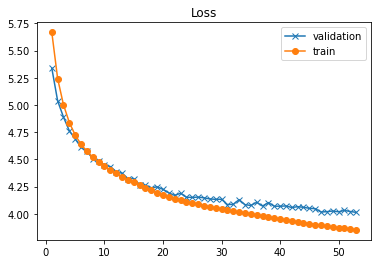

smallest val loss: (53, 4.0131254)
Current Lr:  0.00058470014

Time taken for this epoch: 23.51 secs

Epoch 54 Batch 0 Loss 3.7174
Epoch 54 Batch 150 Loss 3.7533
Epoch 54 Batch 300 Loss 3.7840
Epoch 54 Batch 450 Loss 3.8014
Epoch 54 Batch 600 Loss 3.8204
Epoch 54 Batch 750 Loss 3.8390
validation started ...

* Validation loss: 4.019558906555176 

* Train Loss 3.8435


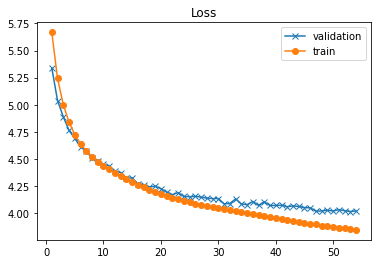

smallest val loss: (53, 4.0131254)
Current Lr:  0.00057891815

Time taken for this epoch: 23.47 secs

Epoch 55 Batch 0 Loss 3.6270
Epoch 55 Batch 150 Loss 3.7711
Epoch 55 Batch 300 Loss 3.7818
Epoch 55 Batch 450 Loss 3.7973
Epoch 55 Batch 600 Loss 3.8158
Epoch 55 Batch 750 Loss 3.8394
validation started ...

* Validation loss: 4.006682872772217 

* Train Loss 3.8410


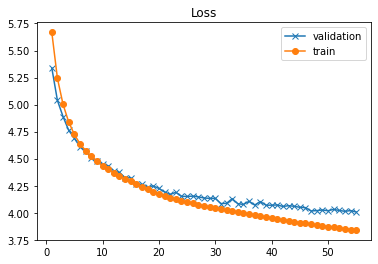

smallest val loss: (55, 4.006683)
Current Lr:  0.00057319325

Time taken for this epoch: 23.49 secs

Epoch 56 Batch 0 Loss 3.8741
Epoch 56 Batch 150 Loss 3.7462
Epoch 56 Batch 300 Loss 3.7823
Epoch 56 Batch 450 Loss 3.7939
Epoch 56 Batch 600 Loss 3.8107
Epoch 56 Batch 750 Loss 3.8304
validation started ...

* Validation loss: 4.011990547180176 

* Train Loss 3.8328


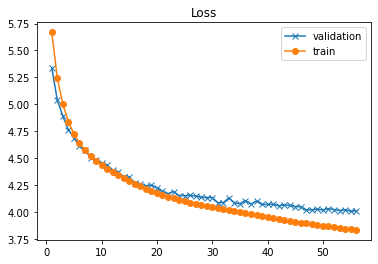

smallest val loss: (55, 4.006683)
Current Lr:  0.00056752504

Time taken for this epoch: 23.54 secs

Epoch 57 Batch 0 Loss 3.7706
Epoch 57 Batch 150 Loss 3.7362
Epoch 57 Batch 300 Loss 3.7687
Epoch 57 Batch 450 Loss 3.7932
Epoch 57 Batch 600 Loss 3.8086
Epoch 57 Batch 750 Loss 3.8236
validation started ...

* Validation loss: 3.9942777156829834 

* Train Loss 3.8252


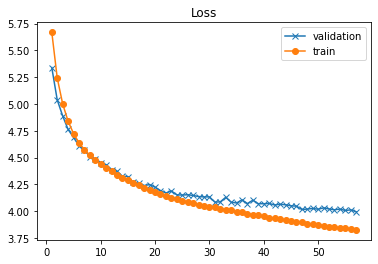

smallest val loss: (57, 3.9942777)
Current Lr:  0.0005619129

Time taken for this epoch: 23.45 secs

Epoch 58 Batch 0 Loss 3.8493
Epoch 58 Batch 150 Loss 3.7325
Epoch 58 Batch 300 Loss 3.7576
Epoch 58 Batch 450 Loss 3.7838
Epoch 58 Batch 600 Loss 3.7992
Epoch 58 Batch 750 Loss 3.8169
validation started ...

* Validation loss: 3.9993155002593994 

* Train Loss 3.8210


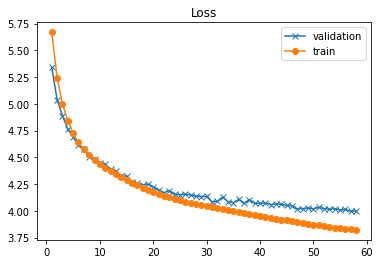

smallest val loss: (57, 3.9942777)
Current Lr:  0.00055635616

Time taken for this epoch: 23.44 secs

Epoch 59 Batch 0 Loss 3.8012
Epoch 59 Batch 150 Loss 3.7562
Epoch 59 Batch 300 Loss 3.7695
Epoch 59 Batch 450 Loss 3.7804
Epoch 59 Batch 600 Loss 3.7916
Epoch 59 Batch 750 Loss 3.8130
validation started ...

* Validation loss: 3.99271297454834 

* Train Loss 3.8152


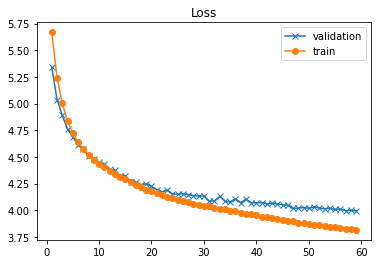

smallest val loss: (59, 3.992713)
Current Lr:  0.0005508545

Time taken for this epoch: 23.50 secs

Epoch 60 Batch 0 Loss 3.6941
Epoch 60 Batch 150 Loss 3.7328
Epoch 60 Batch 300 Loss 3.7532
Epoch 60 Batch 450 Loss 3.7714
Epoch 60 Batch 600 Loss 3.7817
Epoch 60 Batch 750 Loss 3.8040
validation started ...

* Validation loss: 3.9893736839294434 

* Train Loss 3.8068


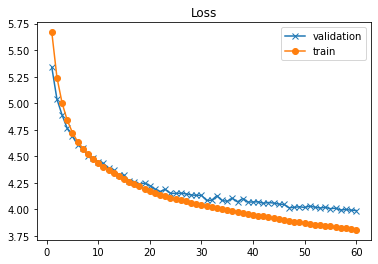

smallest val loss: (60, 3.9893737)
Current Lr:  0.0005454071

Time taken for this epoch: 23.48 secs

Epoch 61 Batch 0 Loss 3.7391
Epoch 61 Batch 150 Loss 3.7222
Epoch 61 Batch 300 Loss 3.7528
Epoch 61 Batch 450 Loss 3.7696
Epoch 61 Batch 600 Loss 3.7819
Epoch 61 Batch 750 Loss 3.7988
validation started ...

* Validation loss: 3.9873926639556885 

* Train Loss 3.8023


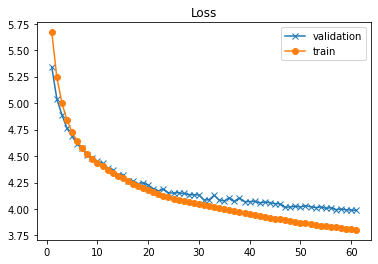

smallest val loss: (61, 3.9873927)
Current Lr:  0.00054001366

Time taken for this epoch: 23.61 secs

Epoch 62 Batch 0 Loss 3.6465
Epoch 62 Batch 150 Loss 3.7311
Epoch 62 Batch 300 Loss 3.7439
Epoch 62 Batch 450 Loss 3.7613
Epoch 62 Batch 600 Loss 3.7785
Epoch 62 Batch 750 Loss 3.7946
validation started ...

* Validation loss: 3.9904463291168213 

* Train Loss 3.7980


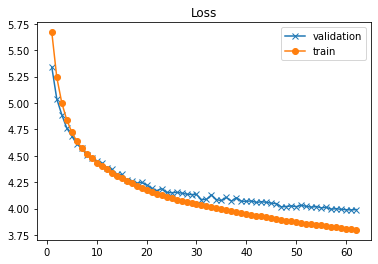

smallest val loss: (61, 3.9873927)
Current Lr:  0.0005346735

Time taken for this epoch: 23.94 secs

Epoch 63 Batch 0 Loss 3.6073
Epoch 63 Batch 150 Loss 3.7020
Epoch 63 Batch 300 Loss 3.7301
Epoch 63 Batch 450 Loss 3.7489
Epoch 63 Batch 600 Loss 3.7617
Epoch 63 Batch 750 Loss 3.7872
validation started ...

* Validation loss: 3.999572992324829 

* Train Loss 3.7919


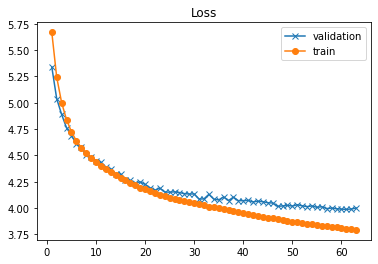

smallest val loss: (61, 3.9873927)
Current Lr:  0.0005293862

Time taken for this epoch: 24.18 secs

Epoch 64 Batch 0 Loss 3.6349
Epoch 64 Batch 150 Loss 3.7036
Epoch 64 Batch 300 Loss 3.7191
Epoch 64 Batch 450 Loss 3.7501
Epoch 64 Batch 600 Loss 3.7678
Epoch 64 Batch 750 Loss 3.7856
validation started ...

* Validation loss: 3.9851083755493164 

* Train Loss 3.7881


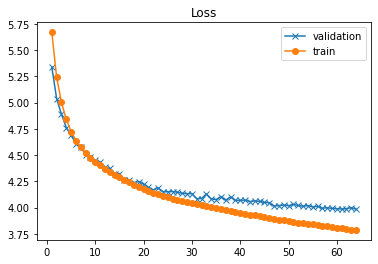

smallest val loss: (64, 3.9851084)
Current Lr:  0.0005241512

Time taken for this epoch: 23.72 secs

Epoch 65 Batch 0 Loss 3.7073
Epoch 65 Batch 150 Loss 3.7125
Epoch 65 Batch 300 Loss 3.7363
Epoch 65 Batch 450 Loss 3.7505
Epoch 65 Batch 600 Loss 3.7662
Epoch 65 Batch 750 Loss 3.7815
validation started ...

* Validation loss: 3.998344659805298 

* Train Loss 3.7842


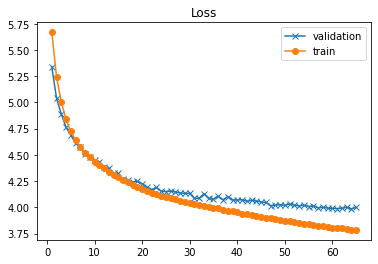

smallest val loss: (64, 3.9851084)
Current Lr:  0.000518968

Time taken for this epoch: 23.83 secs

Epoch 66 Batch 0 Loss 3.6116
Epoch 66 Batch 150 Loss 3.7028
Epoch 66 Batch 300 Loss 3.7219
Epoch 66 Batch 450 Loss 3.7413
Epoch 66 Batch 600 Loss 3.7566
Epoch 66 Batch 750 Loss 3.7744
validation started ...

* Validation loss: 3.967897891998291 

* Train Loss 3.7779


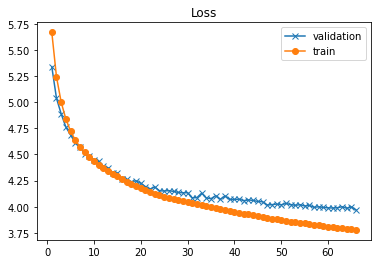

smallest val loss: (66, 3.967898)
Current Lr:  0.0005138359

Time taken for this epoch: 23.54 secs

Epoch 67 Batch 0 Loss 3.5876
Epoch 67 Batch 150 Loss 3.6910
Epoch 67 Batch 300 Loss 3.7116
Epoch 67 Batch 450 Loss 3.7324
Epoch 67 Batch 600 Loss 3.7467
Epoch 67 Batch 750 Loss 3.7695
validation started ...

* Validation loss: 3.9771814346313477 

* Train Loss 3.7742


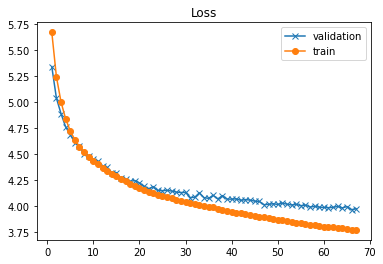

smallest val loss: (66, 3.967898)
Current Lr:  0.0005087547

Time taken for this epoch: 23.71 secs

Epoch 68 Batch 0 Loss 3.8266
Epoch 68 Batch 150 Loss 3.6916
Epoch 68 Batch 300 Loss 3.7188
Epoch 68 Batch 450 Loss 3.7327
Epoch 68 Batch 600 Loss 3.7440
Epoch 68 Batch 750 Loss 3.7637
validation started ...

* Validation loss: 3.9897491931915283 

* Train Loss 3.7670


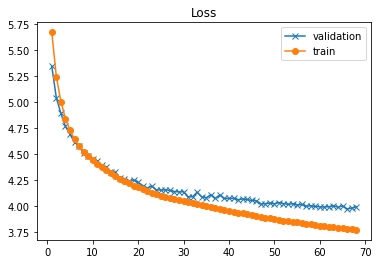

smallest val loss: (66, 3.967898)
Current Lr:  0.00050372374

Time taken for this epoch: 23.59 secs

Epoch 69 Batch 0 Loss 3.7461
Epoch 69 Batch 150 Loss 3.6699
Epoch 69 Batch 300 Loss 3.7008
Epoch 69 Batch 450 Loss 3.7241
Epoch 69 Batch 600 Loss 3.7418
Epoch 69 Batch 750 Loss 3.7615
validation started ...

* Validation loss: 4.000118732452393 

* Train Loss 3.7647


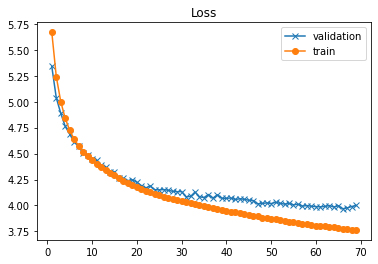

smallest val loss: (66, 3.967898)
Current Lr:  0.0004987425

Time taken for this epoch: 23.61 secs

Epoch 70 Batch 0 Loss 3.6974
Epoch 70 Batch 150 Loss 3.6913
Epoch 70 Batch 300 Loss 3.7139
Epoch 70 Batch 450 Loss 3.7222
Epoch 70 Batch 600 Loss 3.7367
Epoch 70 Batch 750 Loss 3.7551
validation started ...

* Validation loss: 3.9678971767425537 

* Train Loss 3.7591


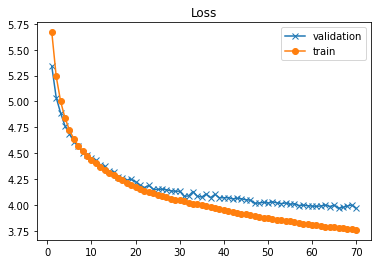

smallest val loss: (70, 3.9678972)
Current Lr:  0.0004938104

Time taken for this epoch: 23.57 secs

Epoch 71 Batch 0 Loss 3.6911
Epoch 71 Batch 150 Loss 3.6660
Epoch 71 Batch 300 Loss 3.6994
Epoch 71 Batch 450 Loss 3.7165
Epoch 71 Batch 600 Loss 3.7337
Epoch 71 Batch 750 Loss 3.7533
validation started ...

* Validation loss: 3.967822790145874 

* Train Loss 3.7558


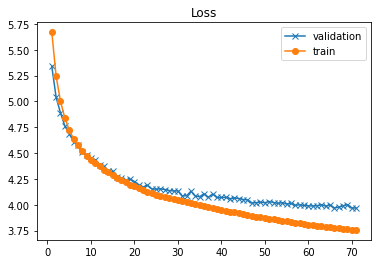

smallest val loss: (71, 3.9678228)
Current Lr:  0.0004889273

Time taken for this epoch: 23.58 secs

Epoch 72 Batch 0 Loss 3.5817
Epoch 72 Batch 150 Loss 3.6761
Epoch 72 Batch 300 Loss 3.6994
Epoch 72 Batch 450 Loss 3.7209
Epoch 72 Batch 600 Loss 3.7352
Epoch 72 Batch 750 Loss 3.7459
validation started ...

* Validation loss: 3.9550511837005615 

* Train Loss 3.7501


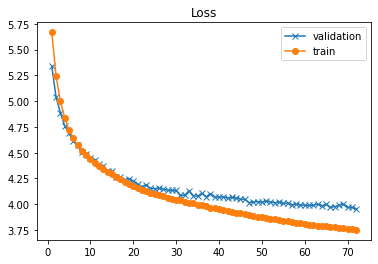

smallest val loss: (72, 3.9550512)
Current Lr:  0.00048409228

Time taken for this epoch: 23.60 secs

Epoch 73 Batch 0 Loss 3.5698
Epoch 73 Batch 150 Loss 3.6663
Epoch 73 Batch 300 Loss 3.7029
Epoch 73 Batch 450 Loss 3.7223
Epoch 73 Batch 600 Loss 3.7293
Epoch 73 Batch 750 Loss 3.7427
validation started ...

* Validation loss: 3.9586479663848877 

* Train Loss 3.7465


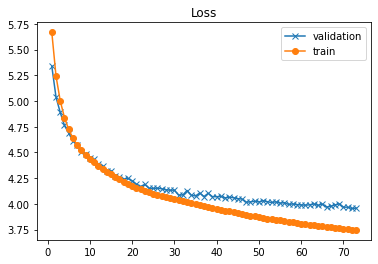

smallest val loss: (72, 3.9550512)
Current Lr:  0.00047930522

Time taken for this epoch: 23.66 secs

Epoch 74 Batch 0 Loss 3.6720
Epoch 74 Batch 150 Loss 3.6545
Epoch 74 Batch 300 Loss 3.6823
Epoch 74 Batch 450 Loss 3.7078
Epoch 74 Batch 600 Loss 3.7272
Epoch 74 Batch 750 Loss 3.7428
validation started ...

* Validation loss: 3.9488167762756348 

* Train Loss 3.7444

Saving checkpoint for epoch 74 at checkpoints4/ckpt-11


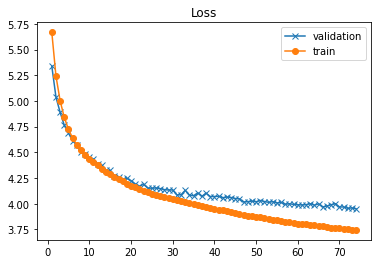

smallest val loss: (74, 3.9488168)
Current Lr:  0.00047456537

Time taken for this epoch: 23.70 secs

Epoch 75 Batch 0 Loss 3.7010
Epoch 75 Batch 150 Loss 3.6553
Epoch 75 Batch 300 Loss 3.6851
Epoch 75 Batch 450 Loss 3.7021
Epoch 75 Batch 600 Loss 3.7198
Epoch 75 Batch 750 Loss 3.7353
validation started ...

* Validation loss: 3.9480674266815186 

* Train Loss 3.7381


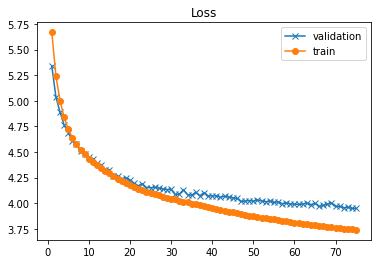

smallest val loss: (75, 3.9480674)
Current Lr:  0.00046987247

Time taken for this epoch: 23.49 secs

Epoch 76 Batch 0 Loss 3.5946
Epoch 76 Batch 150 Loss 3.6465
Epoch 76 Batch 300 Loss 3.6702
Epoch 76 Batch 450 Loss 3.6964
Epoch 76 Batch 600 Loss 3.7142
Epoch 76 Batch 750 Loss 3.7319
validation started ...

* Validation loss: 3.9578778743743896 

* Train Loss 3.7338


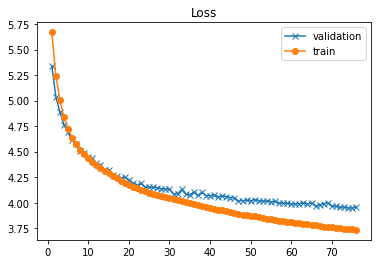

smallest val loss: (75, 3.9480674)
Current Lr:  0.000465226

Time taken for this epoch: 23.66 secs

Epoch 77 Batch 0 Loss 3.7732
Epoch 77 Batch 150 Loss 3.6491
Epoch 77 Batch 300 Loss 3.6782
Epoch 77 Batch 450 Loss 3.6893
Epoch 77 Batch 600 Loss 3.7067
Epoch 77 Batch 750 Loss 3.7251
validation started ...

* Validation loss: 3.9602549076080322 

* Train Loss 3.7300


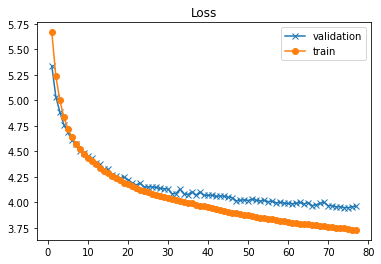

smallest val loss: (75, 3.9480674)
Current Lr:  0.0004606254

Time taken for this epoch: 23.61 secs

Epoch 78 Batch 0 Loss 3.5818
Epoch 78 Batch 150 Loss 3.6507
Epoch 78 Batch 300 Loss 3.6719
Epoch 78 Batch 450 Loss 3.6844
Epoch 78 Batch 600 Loss 3.7021
Epoch 78 Batch 750 Loss 3.7224
validation started ...

* Validation loss: 3.9276983737945557 

* Train Loss 3.7260


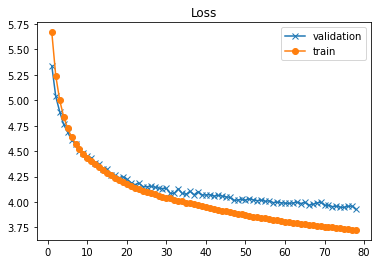

smallest val loss: (78, 3.9276984)
Current Lr:  0.00045607038

Time taken for this epoch: 23.42 secs

Epoch 79 Batch 0 Loss 3.7616
Epoch 79 Batch 150 Loss 3.6420
Epoch 79 Batch 300 Loss 3.6663
Epoch 79 Batch 450 Loss 3.6875
Epoch 79 Batch 600 Loss 3.7055
Epoch 79 Batch 750 Loss 3.7171
validation started ...

* Validation loss: 3.9466896057128906 

* Train Loss 3.7205


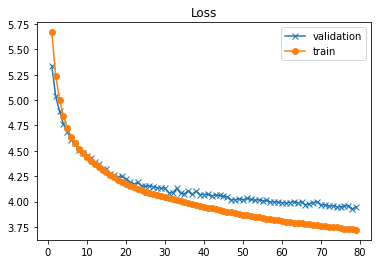

smallest val loss: (78, 3.9276984)
Current Lr:  0.0004515604

Time taken for this epoch: 23.45 secs

Epoch 80 Batch 0 Loss 3.6014
Epoch 80 Batch 150 Loss 3.6373
Epoch 80 Batch 300 Loss 3.6595
Epoch 80 Batch 450 Loss 3.6790
Epoch 80 Batch 600 Loss 3.6973
Epoch 80 Batch 750 Loss 3.7153
validation started ...

* Validation loss: 3.938693046569824 

* Train Loss 3.7179


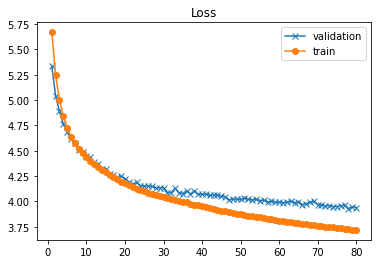

smallest val loss: (78, 3.9276984)
Current Lr:  0.00044709494

Time taken for this epoch: 23.56 secs

Epoch 81 Batch 0 Loss 3.4452
Epoch 81 Batch 150 Loss 3.6336
Epoch 81 Batch 300 Loss 3.6636
Epoch 81 Batch 450 Loss 3.6789
Epoch 81 Batch 600 Loss 3.6909
Epoch 81 Batch 750 Loss 3.7135
validation started ...

* Validation loss: 3.938513994216919 

* Train Loss 3.7182


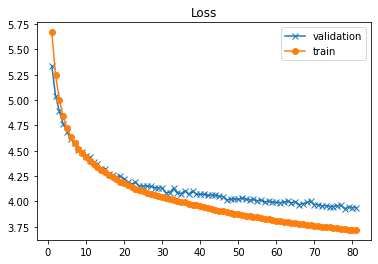

smallest val loss: (78, 3.9276984)
Current Lr:  0.00044267369

Time taken for this epoch: 23.42 secs

Epoch 82 Batch 0 Loss 3.8368
Epoch 82 Batch 150 Loss 3.6536
Epoch 82 Batch 300 Loss 3.6628
Epoch 82 Batch 450 Loss 3.6762
Epoch 82 Batch 600 Loss 3.6921
Epoch 82 Batch 750 Loss 3.7095
validation started ...

* Validation loss: 3.943472146987915 

* Train Loss 3.7130


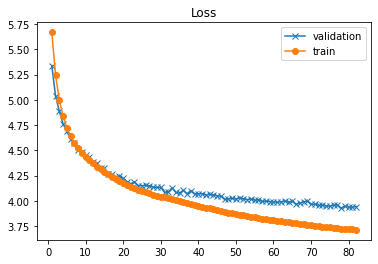

smallest val loss: (78, 3.9276984)
Current Lr:  0.00043829618

Time taken for this epoch: 23.39 secs

Epoch 83 Batch 0 Loss 3.4322
Epoch 83 Batch 150 Loss 3.6391
Epoch 83 Batch 300 Loss 3.6693
Epoch 83 Batch 450 Loss 3.6807
Epoch 83 Batch 600 Loss 3.6941
Epoch 83 Batch 750 Loss 3.7050
validation started ...

* Validation loss: 3.947458505630493 

* Train Loss 3.7068


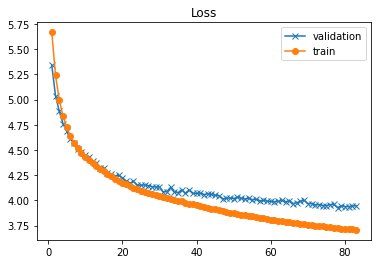

smallest val loss: (78, 3.9276984)
Current Lr:  0.00043396192

Time taken for this epoch: 23.62 secs

Epoch 84 Batch 0 Loss 3.7872
Epoch 84 Batch 150 Loss 3.6210
Epoch 84 Batch 300 Loss 3.6392
Epoch 84 Batch 450 Loss 3.6607
Epoch 84 Batch 600 Loss 3.6850
Epoch 84 Batch 750 Loss 3.7026
validation started ...

* Validation loss: 3.9460091590881348 

* Train Loss 3.7060


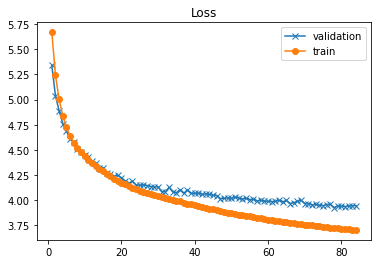

smallest val loss: (78, 3.9276984)
Current Lr:  0.0004296705

Time taken for this epoch: 23.52 secs

Epoch 85 Batch 0 Loss 3.7243
Epoch 85 Batch 150 Loss 3.6302
Epoch 85 Batch 300 Loss 3.6523
Epoch 85 Batch 450 Loss 3.6642
Epoch 85 Batch 600 Loss 3.6781
Epoch 85 Batch 750 Loss 3.6970
validation started ...

* Validation loss: 3.937368631362915 

* Train Loss 3.7007


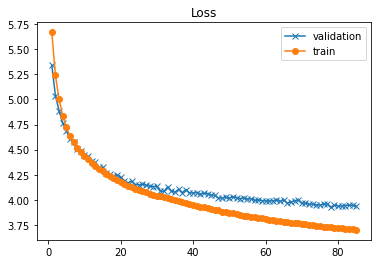

smallest val loss: (78, 3.9276984)
Current Lr:  0.00042542157

Time taken for this epoch: 23.52 secs

Epoch 86 Batch 0 Loss 3.7071
Epoch 86 Batch 150 Loss 3.6204
Epoch 86 Batch 300 Loss 3.6453
Epoch 86 Batch 450 Loss 3.6656
Epoch 86 Batch 600 Loss 3.6770
Epoch 86 Batch 750 Loss 3.6940
validation started ...

* Validation loss: 3.9257538318634033 

* Train Loss 3.6977


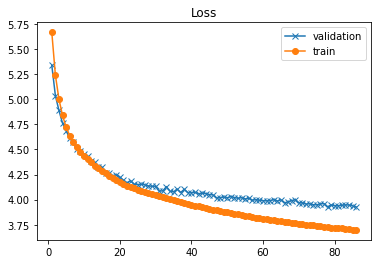

smallest val loss: (86, 3.9257538)
Current Lr:  0.0004212146

Time taken for this epoch: 23.49 secs

Epoch 87 Batch 0 Loss 3.7397
Epoch 87 Batch 150 Loss 3.6082
Epoch 87 Batch 300 Loss 3.6376
Epoch 87 Batch 450 Loss 3.6577
Epoch 87 Batch 600 Loss 3.6733
Epoch 87 Batch 750 Loss 3.6904
validation started ...

* Validation loss: 3.939157009124756 

* Train Loss 3.6938


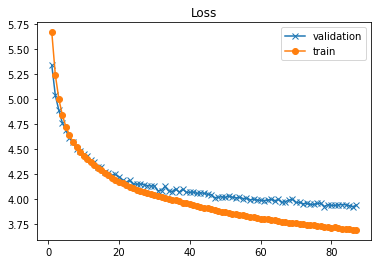

smallest val loss: (86, 3.9257538)
Current Lr:  0.00041704928

Time taken for this epoch: 23.55 secs

Epoch 88 Batch 0 Loss 3.6885
Epoch 88 Batch 150 Loss 3.6129
Epoch 88 Batch 300 Loss 3.6348
Epoch 88 Batch 450 Loss 3.6570
Epoch 88 Batch 600 Loss 3.6685
Epoch 88 Batch 750 Loss 3.6870
validation started ...

* Validation loss: 3.9473800659179688 

* Train Loss 3.6916


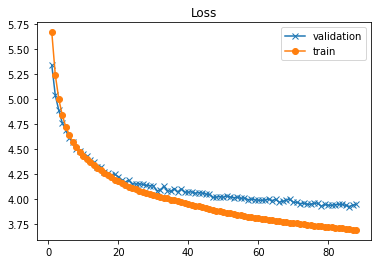

smallest val loss: (86, 3.9257538)
Current Lr:  0.00041292518

Time taken for this epoch: 23.57 secs

Epoch 89 Batch 0 Loss 3.2770
Epoch 89 Batch 150 Loss 3.6258
Epoch 89 Batch 300 Loss 3.6448
Epoch 89 Batch 450 Loss 3.6526
Epoch 89 Batch 600 Loss 3.6673
Epoch 89 Batch 750 Loss 3.6865
validation started ...

* Validation loss: 3.9060676097869873 

* Train Loss 3.6881


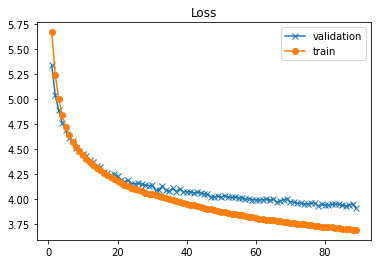

smallest val loss: (89, 3.9060676)
Current Lr:  0.0004088418

Time taken for this epoch: 23.52 secs

Epoch 90 Batch 0 Loss 3.2794
Epoch 90 Batch 150 Loss 3.6198
Epoch 90 Batch 300 Loss 3.6299
Epoch 90 Batch 450 Loss 3.6527
Epoch 90 Batch 600 Loss 3.6649
Epoch 90 Batch 750 Loss 3.6835
validation started ...

* Validation loss: 3.9236550331115723 

* Train Loss 3.6862


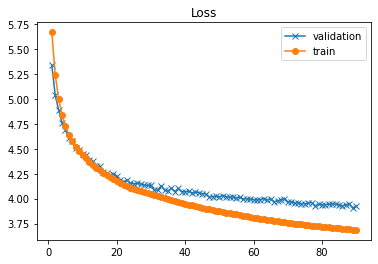

smallest val loss: (89, 3.9060676)
Current Lr:  0.00040479883

Time taken for this epoch: 23.49 secs

Epoch 91 Batch 0 Loss 3.5027
Epoch 91 Batch 150 Loss 3.6144
Epoch 91 Batch 300 Loss 3.6211
Epoch 91 Batch 450 Loss 3.6447
Epoch 91 Batch 600 Loss 3.6629
Epoch 91 Batch 750 Loss 3.6802
validation started ...

* Validation loss: 3.9276442527770996 

* Train Loss 3.6826


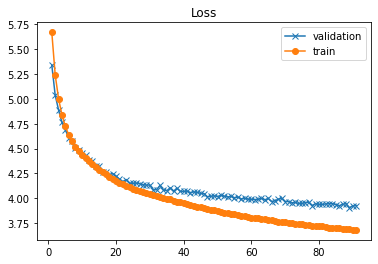

smallest val loss: (89, 3.9060676)
Current Lr:  0.00040079583

Time taken for this epoch: 23.49 secs

Epoch 92 Batch 0 Loss 3.7128
Epoch 92 Batch 150 Loss 3.5999
Epoch 92 Batch 300 Loss 3.6141
Epoch 92 Batch 450 Loss 3.6325
Epoch 92 Batch 600 Loss 3.6520
Epoch 92 Batch 750 Loss 3.6734
validation started ...

* Validation loss: 3.9192075729370117 

* Train Loss 3.6773


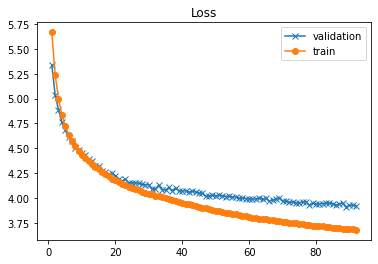

smallest val loss: (89, 3.9060676)
Current Lr:  0.00039683245

Time taken for this epoch: 23.46 secs

Epoch 93 Batch 0 Loss 3.6899
Epoch 93 Batch 150 Loss 3.5940
Epoch 93 Batch 300 Loss 3.6235
Epoch 93 Batch 450 Loss 3.6387
Epoch 93 Batch 600 Loss 3.6545
Epoch 93 Batch 750 Loss 3.6732
validation started ...

* Validation loss: 3.943991184234619 

* Train Loss 3.6747


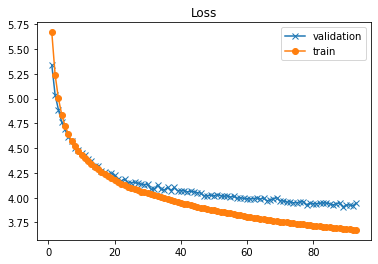

smallest val loss: (89, 3.9060676)
Current Lr:  0.00039290817

Time taken for this epoch: 23.48 secs

Epoch 94 Batch 0 Loss 3.4620
Epoch 94 Batch 150 Loss 3.5958
Epoch 94 Batch 300 Loss 3.6180
Epoch 94 Batch 450 Loss 3.6344
Epoch 94 Batch 600 Loss 3.6534
Epoch 94 Batch 750 Loss 3.6698
validation started ...

* Validation loss: 3.921637773513794 

* Train Loss 3.6717


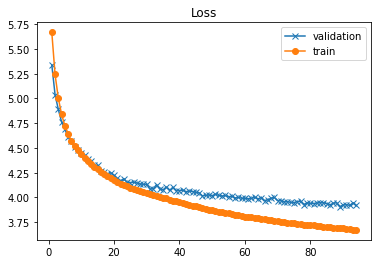

smallest val loss: (89, 3.9060676)
Current Lr:  0.00038902278

Time taken for this epoch: 23.47 secs

Epoch 95 Batch 0 Loss 3.8598
Epoch 95 Batch 150 Loss 3.5792
Epoch 95 Batch 300 Loss 3.6114
Epoch 95 Batch 450 Loss 3.6265
Epoch 95 Batch 600 Loss 3.6438
Epoch 95 Batch 750 Loss 3.6647
validation started ...

* Validation loss: 3.9153709411621094 

* Train Loss 3.6675


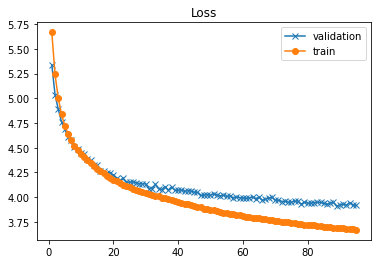

smallest val loss: (89, 3.9060676)
Current Lr:  0.00038517575

Time taken for this epoch: 23.41 secs

Epoch 96 Batch 0 Loss 3.5576
Epoch 96 Batch 150 Loss 3.5850
Epoch 96 Batch 300 Loss 3.6096
Epoch 96 Batch 450 Loss 3.6247
Epoch 96 Batch 600 Loss 3.6435
Epoch 96 Batch 750 Loss 3.6628
validation started ...

* Validation loss: 3.9286789894104004 

* Train Loss 3.6656


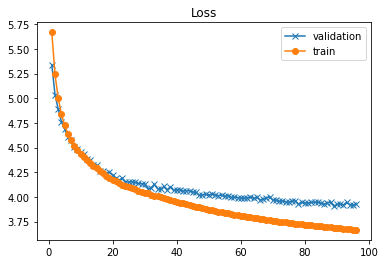

smallest val loss: (89, 3.9060676)
Current Lr:  0.00038136684

Time taken for this epoch: 23.51 secs

Epoch 97 Batch 0 Loss 3.4658
Epoch 97 Batch 150 Loss 3.5733
Epoch 97 Batch 300 Loss 3.6173
Epoch 97 Batch 450 Loss 3.6324
Epoch 97 Batch 600 Loss 3.6425
Epoch 97 Batch 750 Loss 3.6597
validation started ...

* Validation loss: 3.9205710887908936 

* Train Loss 3.6638


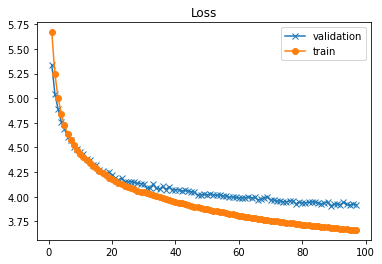

smallest val loss: (89, 3.9060676)
Current Lr:  0.00037759557

Time taken for this epoch: 23.59 secs

Epoch 98 Batch 0 Loss 3.3876
Epoch 98 Batch 150 Loss 3.5917
Epoch 98 Batch 300 Loss 3.6030
Epoch 98 Batch 450 Loss 3.6199
Epoch 98 Batch 600 Loss 3.6377
Epoch 98 Batch 750 Loss 3.6565
validation started ...

* Validation loss: 3.911104679107666 

* Train Loss 3.6603


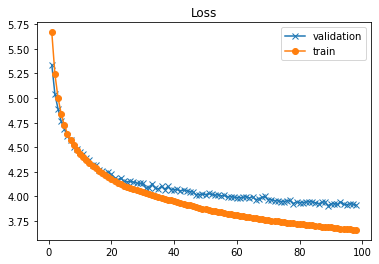

smallest val loss: (89, 3.9060676)
Current Lr:  0.0003738616

Time taken for this epoch: 23.73 secs

Epoch 99 Batch 0 Loss 3.5511
Epoch 99 Batch 150 Loss 3.5803
Epoch 99 Batch 300 Loss 3.6024
Epoch 99 Batch 450 Loss 3.6118
Epoch 99 Batch 600 Loss 3.6310
Epoch 99 Batch 750 Loss 3.6526
validation started ...

* Validation loss: 3.908243417739868 

* Train Loss 3.6563


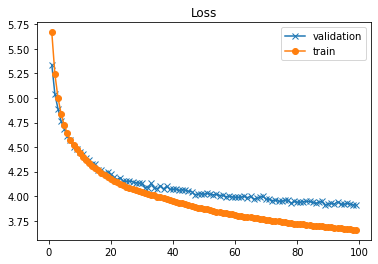

smallest val loss: (89, 3.9060676)
Current Lr:  0.00037016446

Time taken for this epoch: 23.44 secs

Epoch 100 Batch 0 Loss 3.6726
Epoch 100 Batch 150 Loss 3.5785
Epoch 100 Batch 300 Loss 3.5958
Epoch 100 Batch 450 Loss 3.6192
Epoch 100 Batch 600 Loss 3.6338
Epoch 100 Batch 750 Loss 3.6484
validation started ...

* Validation loss: 3.9233360290527344 

* Train Loss 3.6532


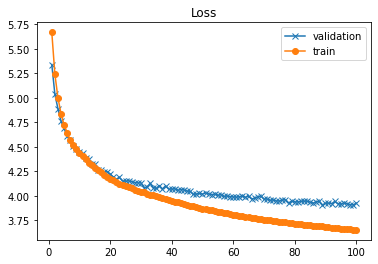

smallest val loss: (89, 3.9060676)
Current Lr:  0.00036650398

Time taken for this epoch: 23.49 secs

Epoch 101 Batch 0 Loss 3.6714
Epoch 101 Batch 150 Loss 3.5538
Epoch 101 Batch 300 Loss 3.5935
Epoch 101 Batch 450 Loss 3.6183
Epoch 101 Batch 600 Loss 3.6366
Epoch 101 Batch 750 Loss 3.6491
validation started ...

* Validation loss: 3.884321689605713 

* Train Loss 3.6524


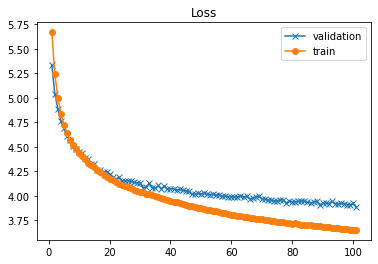

smallest val loss: (101, 3.8843217)
Current Lr:  0.00036287968

Time taken for this epoch: 23.57 secs

Epoch 102 Batch 0 Loss 3.3835
Epoch 102 Batch 150 Loss 3.5839
Epoch 102 Batch 300 Loss 3.6021
Epoch 102 Batch 450 Loss 3.6135
Epoch 102 Batch 600 Loss 3.6286
Epoch 102 Batch 750 Loss 3.6446
validation started ...

* Validation loss: 3.9227964878082275 

* Train Loss 3.6492


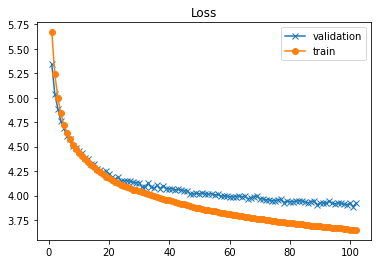

smallest val loss: (101, 3.8843217)
Current Lr:  0.00035929127

Time taken for this epoch: 23.51 secs

Epoch 103 Batch 0 Loss 3.8049
Epoch 103 Batch 150 Loss 3.5807
Epoch 103 Batch 300 Loss 3.5987
Epoch 103 Batch 450 Loss 3.6129
Epoch 103 Batch 600 Loss 3.6255
Epoch 103 Batch 750 Loss 3.6420
validation started ...

* Validation loss: 3.916815996170044 

* Train Loss 3.6459


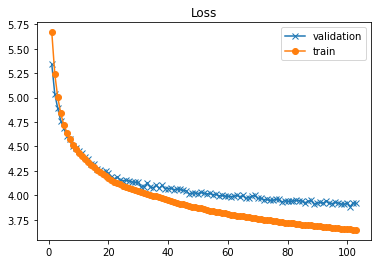

smallest val loss: (101, 3.8843217)
Current Lr:  0.00035573827

Time taken for this epoch: 23.40 secs

Epoch 104 Batch 0 Loss 3.4952
Epoch 104 Batch 150 Loss 3.5806
Epoch 104 Batch 300 Loss 3.6084
Epoch 104 Batch 450 Loss 3.6230
Epoch 104 Batch 600 Loss 3.6319
Epoch 104 Batch 750 Loss 3.6443
validation started ...

* Validation loss: 3.8914146423339844 

* Train Loss 3.6460


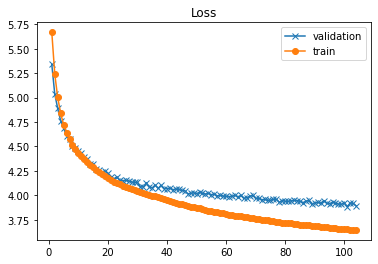

smallest val loss: (101, 3.8843217)
Current Lr:  0.00035222038

Time taken for this epoch: 23.51 secs

Epoch 105 Batch 0 Loss 3.6186
Epoch 105 Batch 150 Loss 3.5827
Epoch 105 Batch 300 Loss 3.5913
Epoch 105 Batch 450 Loss 3.6084
Epoch 105 Batch 600 Loss 3.6245
Epoch 105 Batch 750 Loss 3.6410
validation started ...

* Validation loss: 3.8773443698883057 

* Train Loss 3.6434


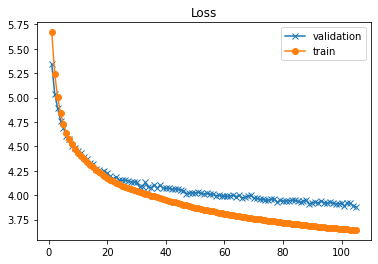

smallest val loss: (105, 3.8773444)
Current Lr:  0.0003487373

Time taken for this epoch: 23.56 secs

Epoch 106 Batch 0 Loss 3.6638
Epoch 106 Batch 150 Loss 3.5488
Epoch 106 Batch 300 Loss 3.5833
Epoch 106 Batch 450 Loss 3.6089
Epoch 106 Batch 600 Loss 3.6168
Epoch 106 Batch 750 Loss 3.6353
validation started ...

* Validation loss: 3.8737287521362305 

* Train Loss 3.6389


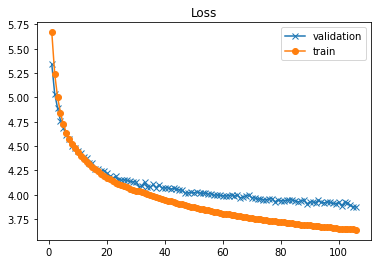

smallest val loss: (106, 3.8737288)
Current Lr:  0.00034528872

Time taken for this epoch: 23.46 secs

Epoch 107 Batch 0 Loss 3.3955
Epoch 107 Batch 150 Loss 3.5531
Epoch 107 Batch 300 Loss 3.5900
Epoch 107 Batch 450 Loss 3.6018
Epoch 107 Batch 600 Loss 3.6165
Epoch 107 Batch 750 Loss 3.6316
validation started ...

* Validation loss: 3.8973031044006348 

* Train Loss 3.6353


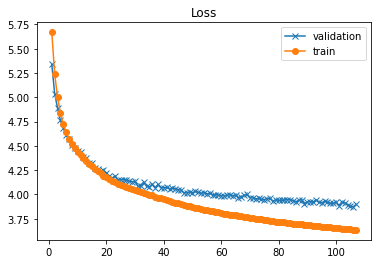

smallest val loss: (106, 3.8737288)
Current Lr:  0.00034187423

Time taken for this epoch: 23.39 secs

Epoch 108 Batch 0 Loss 3.4992
Epoch 108 Batch 150 Loss 3.5511
Epoch 108 Batch 300 Loss 3.5783
Epoch 108 Batch 450 Loss 3.5902
Epoch 108 Batch 600 Loss 3.6068
Epoch 108 Batch 750 Loss 3.6298
validation started ...

* Validation loss: 3.9002866744995117 

* Train Loss 3.6341


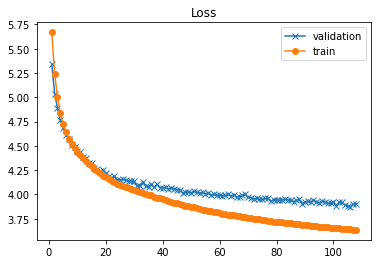

smallest val loss: (106, 3.8737288)
Current Lr:  0.00033849347

Time taken for this epoch: 23.52 secs

Epoch 109 Batch 0 Loss 3.8768
Epoch 109 Batch 150 Loss 3.5588
Epoch 109 Batch 300 Loss 3.5817
Epoch 109 Batch 450 Loss 3.5979
Epoch 109 Batch 600 Loss 3.6092
Epoch 109 Batch 750 Loss 3.6318
validation started ...

* Validation loss: 3.894888162612915 

* Train Loss 3.6331


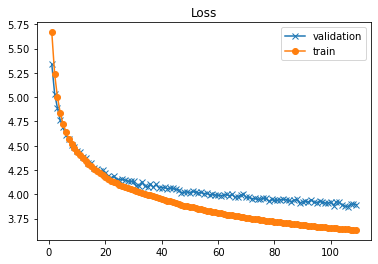

smallest val loss: (106, 3.8737288)
Current Lr:  0.00033514618

Time taken for this epoch: 23.39 secs

Epoch 110 Batch 0 Loss 3.2018
Epoch 110 Batch 150 Loss 3.5620
Epoch 110 Batch 300 Loss 3.5805
Epoch 110 Batch 450 Loss 3.5979
Epoch 110 Batch 600 Loss 3.6112
Epoch 110 Batch 750 Loss 3.6270
validation started ...

* Validation loss: 3.8996217250823975 

* Train Loss 3.6315


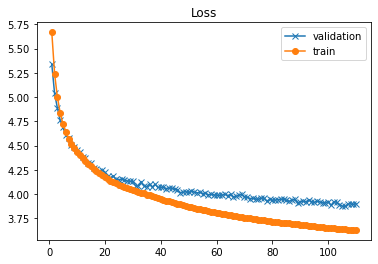

smallest val loss: (106, 3.8737288)
Current Lr:  0.0003318319

Time taken for this epoch: 23.47 secs

Epoch 111 Batch 0 Loss 3.5969
Epoch 111 Batch 150 Loss 3.5518
Epoch 111 Batch 300 Loss 3.5776
Epoch 111 Batch 450 Loss 3.5991
Epoch 111 Batch 600 Loss 3.6109
Epoch 111 Batch 750 Loss 3.6283
validation started ...

* Validation loss: 3.8996634483337402 

* Train Loss 3.6311


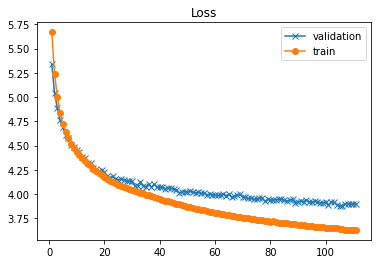

smallest val loss: (106, 3.8737288)
Current Lr:  0.00032855044

Time taken for this epoch: 23.59 secs

Epoch 112 Batch 0 Loss 3.3284
Epoch 112 Batch 150 Loss 3.5583
Epoch 112 Batch 300 Loss 3.5843
Epoch 112 Batch 450 Loss 3.5952
Epoch 112 Batch 600 Loss 3.6082
Epoch 112 Batch 750 Loss 3.6252
validation started ...

* Validation loss: 3.880190849304199 

* Train Loss 3.6278


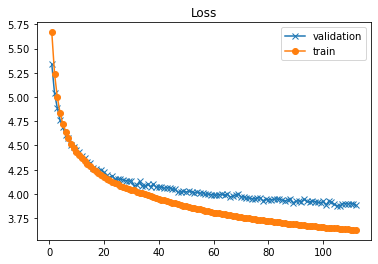

smallest val loss: (106, 3.8737288)
Current Lr:  0.00032530155

Time taken for this epoch: 23.41 secs

Epoch 113 Batch 0 Loss 3.6884
Epoch 113 Batch 150 Loss 3.5465
Epoch 113 Batch 300 Loss 3.5776
Epoch 113 Batch 450 Loss 3.5922
Epoch 113 Batch 600 Loss 3.6035
Epoch 113 Batch 750 Loss 3.6225
validation started ...

* Validation loss: 3.905400037765503 

* Train Loss 3.6242


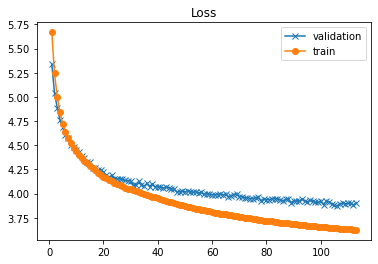

smallest val loss: (106, 3.8737288)
Current Lr:  0.00032208467

Time taken for this epoch: 23.46 secs

Epoch 114 Batch 0 Loss 3.6262
Epoch 114 Batch 150 Loss 3.5558
Epoch 114 Batch 300 Loss 3.5764
Epoch 114 Batch 450 Loss 3.5962
Epoch 114 Batch 600 Loss 3.6025
Epoch 114 Batch 750 Loss 3.6192
validation started ...

* Validation loss: 3.921147108078003 

* Train Loss 3.6221


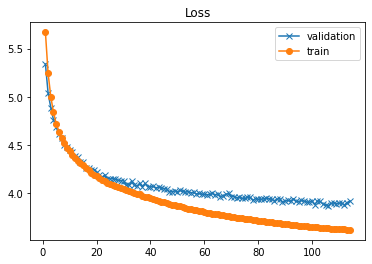

smallest val loss: (106, 3.8737288)
Current Lr:  0.0003188996

Time taken for this epoch: 23.48 secs

Epoch 115 Batch 0 Loss 3.1820
Epoch 115 Batch 150 Loss 3.5562
Epoch 115 Batch 300 Loss 3.5666
Epoch 115 Batch 450 Loss 3.5757
Epoch 115 Batch 600 Loss 3.5983
Epoch 115 Batch 750 Loss 3.6192
validation started ...

* Validation loss: 3.8910303115844727 

* Train Loss 3.6221


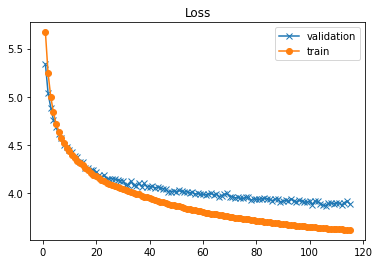

smallest val loss: (106, 3.8737288)
Current Lr:  0.0003157461

Time taken for this epoch: 23.57 secs

Epoch 116 Batch 0 Loss 3.4879
Epoch 116 Batch 150 Loss 3.5393
Epoch 116 Batch 300 Loss 3.5695
Epoch 116 Batch 450 Loss 3.5838
Epoch 116 Batch 600 Loss 3.5931
Epoch 116 Batch 750 Loss 3.6136
validation started ...

* Validation loss: 3.898918867111206 

* Train Loss 3.6154


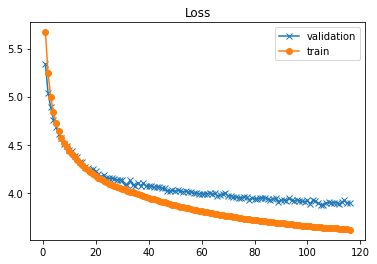

smallest val loss: (106, 3.8737288)
Current Lr:  0.00031262363

Time taken for this epoch: 23.41 secs

Epoch 117 Batch 0 Loss 3.3558
Epoch 117 Batch 150 Loss 3.5494
Epoch 117 Batch 300 Loss 3.5677
Epoch 117 Batch 450 Loss 3.5838
Epoch 117 Batch 600 Loss 3.5986
Epoch 117 Batch 750 Loss 3.6144
validation started ...

* Validation loss: 3.854231834411621 

* Train Loss 3.6176


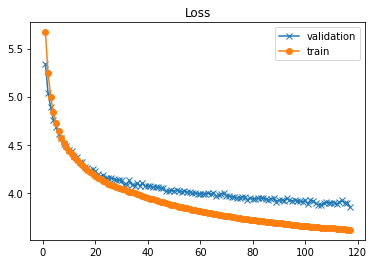

smallest val loss: (117, 3.8542318)
Current Lr:  0.0003095322

Time taken for this epoch: 23.44 secs

Epoch 118 Batch 0 Loss 3.3904
Epoch 118 Batch 150 Loss 3.5310
Epoch 118 Batch 300 Loss 3.5541
Epoch 118 Batch 450 Loss 3.5775
Epoch 118 Batch 600 Loss 3.5961
Epoch 118 Batch 750 Loss 3.6091
validation started ...

* Validation loss: 3.9090769290924072 

* Train Loss 3.6118


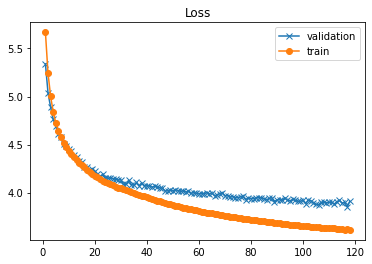

smallest val loss: (117, 3.8542318)
Current Lr:  0.0003064713

Time taken for this epoch: 23.53 secs

Epoch 119 Batch 0 Loss 3.5884
Epoch 119 Batch 150 Loss 3.5158
Epoch 119 Batch 300 Loss 3.5552
Epoch 119 Batch 450 Loss 3.5733
Epoch 119 Batch 600 Loss 3.5867
Epoch 119 Batch 750 Loss 3.6073
validation started ...

* Validation loss: 3.8930251598358154 

* Train Loss 3.6110


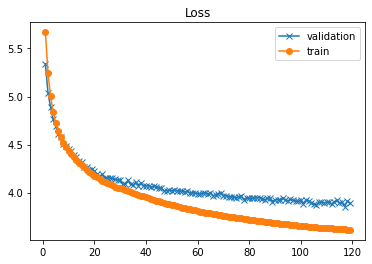

smallest val loss: (117, 3.8542318)
Current Lr:  0.0003034406

Time taken for this epoch: 23.40 secs

Epoch 120 Batch 0 Loss 3.2572
Epoch 120 Batch 150 Loss 3.5405
Epoch 120 Batch 300 Loss 3.5588
Epoch 120 Batch 450 Loss 3.5727
Epoch 120 Batch 600 Loss 3.5904
Epoch 120 Batch 750 Loss 3.6062
validation started ...

* Validation loss: 3.8613221645355225 

* Train Loss 3.6086


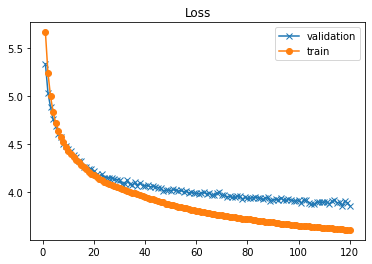

smallest val loss: (117, 3.8542318)
Current Lr:  0.00030043992

Time taken for this epoch: 23.50 secs

Epoch 121 Batch 0 Loss 3.5509
Epoch 121 Batch 150 Loss 3.5325
Epoch 121 Batch 300 Loss 3.5629
Epoch 121 Batch 450 Loss 3.5745
Epoch 121 Batch 600 Loss 3.5890
Epoch 121 Batch 750 Loss 3.6040
validation started ...

* Validation loss: 3.8947865962982178 

* Train Loss 3.6065


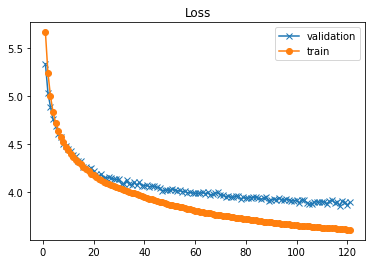

smallest val loss: (117, 3.8542318)
Current Lr:  0.00029746894

Time taken for this epoch: 23.60 secs

Epoch 122 Batch 0 Loss 3.1623
Epoch 122 Batch 150 Loss 3.5440
Epoch 122 Batch 300 Loss 3.5627
Epoch 122 Batch 450 Loss 3.5792
Epoch 122 Batch 600 Loss 3.5910
Epoch 122 Batch 750 Loss 3.6026
validation started ...

* Validation loss: 3.881005048751831 

* Train Loss 3.6045


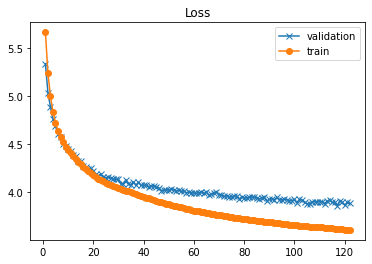

smallest val loss: (117, 3.8542318)
Current Lr:  0.00029452733

Time taken for this epoch: 23.59 secs

Epoch 123 Batch 0 Loss 3.5197
Epoch 123 Batch 150 Loss 3.5350
Epoch 123 Batch 300 Loss 3.5545
Epoch 123 Batch 450 Loss 3.5687
Epoch 123 Batch 600 Loss 3.5865
Epoch 123 Batch 750 Loss 3.6010
validation started ...

* Validation loss: 3.8864662647247314 

* Train Loss 3.6045


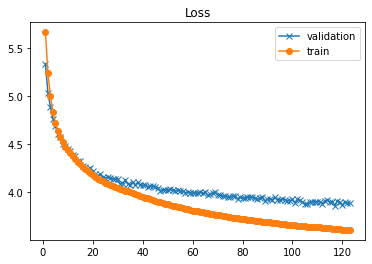

smallest val loss: (117, 3.8542318)
Current Lr:  0.00029161474

Time taken for this epoch: 23.54 secs

Epoch 124 Batch 0 Loss 3.5010
Epoch 124 Batch 150 Loss 3.5255
Epoch 124 Batch 300 Loss 3.5422
Epoch 124 Batch 450 Loss 3.5586
Epoch 124 Batch 600 Loss 3.5775
Epoch 124 Batch 750 Loss 3.5965
validation started ...

* Validation loss: 3.901726722717285 

* Train Loss 3.5984


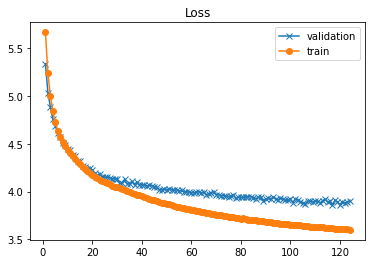

smallest val loss: (117, 3.8542318)
Current Lr:  0.00028873104

Time taken for this epoch: 23.55 secs

Epoch 125 Batch 0 Loss 3.5607
Epoch 125 Batch 150 Loss 3.5057
Epoch 125 Batch 300 Loss 3.5431
Epoch 125 Batch 450 Loss 3.5631
Epoch 125 Batch 600 Loss 3.5768
Epoch 125 Batch 750 Loss 3.5958
validation started ...

* Validation loss: 3.8941948413848877 

* Train Loss 3.5986


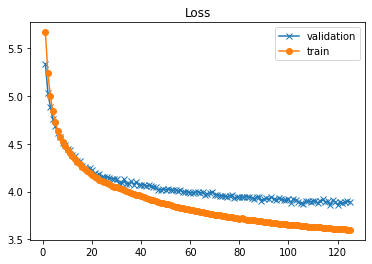

smallest val loss: (117, 3.8542318)
Current Lr:  0.00028587578

Time taken for this epoch: 23.50 secs

Epoch 126 Batch 0 Loss 3.3609
Epoch 126 Batch 150 Loss 3.5267
Epoch 126 Batch 300 Loss 3.5554
Epoch 126 Batch 450 Loss 3.5640
Epoch 126 Batch 600 Loss 3.5817
Epoch 126 Batch 750 Loss 3.5939
validation started ...

* Validation loss: 3.8954391479492188 

* Train Loss 3.5956


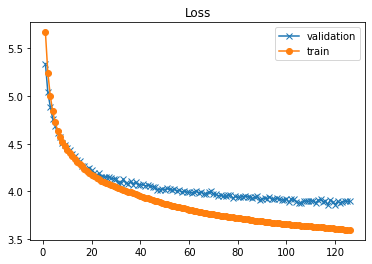

smallest val loss: (117, 3.8542318)
Current Lr:  0.00028304878

Time taken for this epoch: 23.43 secs

Epoch 127 Batch 0 Loss 3.6154
Epoch 127 Batch 150 Loss 3.4968
Epoch 127 Batch 300 Loss 3.5403
Epoch 127 Batch 450 Loss 3.5585
Epoch 127 Batch 600 Loss 3.5771
Epoch 127 Batch 750 Loss 3.5927
validation started ...

* Validation loss: 3.8805387020111084 

* Train Loss 3.5958


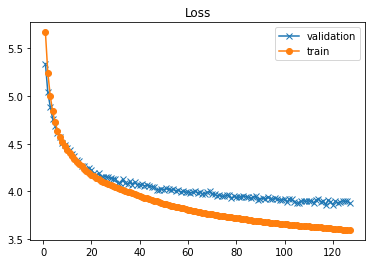

smallest val loss: (117, 3.8542318)
Current Lr:  0.0002802498

Time taken for this epoch: 23.52 secs

Epoch 128 Batch 0 Loss 3.4506
Epoch 128 Batch 150 Loss 3.5235
Epoch 128 Batch 300 Loss 3.5494
Epoch 128 Batch 450 Loss 3.5665
Epoch 128 Batch 600 Loss 3.5774
Epoch 128 Batch 750 Loss 3.5914
validation started ...

* Validation loss: 3.8923323154449463 

* Train Loss 3.5936


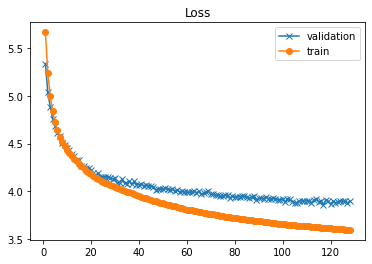

smallest val loss: (117, 3.8542318)
Current Lr:  0.00027747848

Time taken for this epoch: 23.57 secs

Epoch 129 Batch 0 Loss 3.5700
Epoch 129 Batch 150 Loss 3.5168
Epoch 129 Batch 300 Loss 3.5474
Epoch 129 Batch 450 Loss 3.5613
Epoch 129 Batch 600 Loss 3.5716
Epoch 129 Batch 750 Loss 3.5894
validation started ...

* Validation loss: 3.8935134410858154 

* Train Loss 3.5906


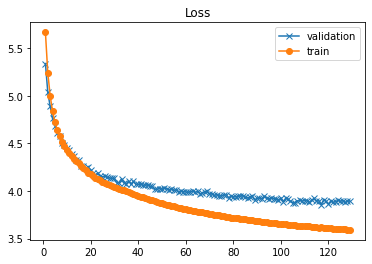

smallest val loss: (117, 3.8542318)
Current Lr:  0.00027473446

Time taken for this epoch: 23.43 secs

Epoch 130 Batch 0 Loss 3.2320
Epoch 130 Batch 150 Loss 3.5236
Epoch 130 Batch 300 Loss 3.5430
Epoch 130 Batch 450 Loss 3.5645
Epoch 130 Batch 600 Loss 3.5820
Epoch 130 Batch 750 Loss 3.5930
validation started ...

* Validation loss: 3.892650604248047 

* Train Loss 3.5933


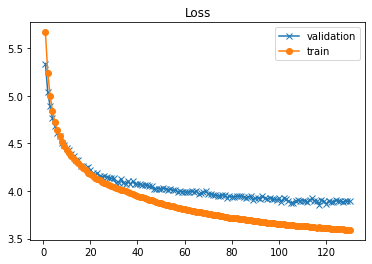

smallest val loss: (117, 3.8542318)
Current Lr:  0.00027201767

Time taken for this epoch: 23.41 secs

Epoch 131 Batch 0 Loss 3.4483
Epoch 131 Batch 150 Loss 3.5113
Epoch 131 Batch 300 Loss 3.5384
Epoch 131 Batch 450 Loss 3.5562
Epoch 131 Batch 600 Loss 3.5655
Epoch 131 Batch 750 Loss 3.5851
validation started ...

* Validation loss: 3.890568733215332 

* Train Loss 3.5888


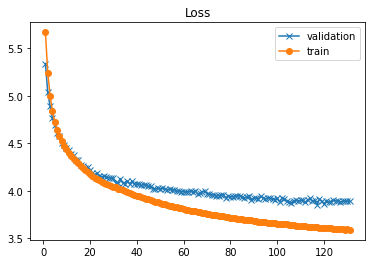

smallest val loss: (117, 3.8542318)
Current Lr:  0.00026932772

Time taken for this epoch: 23.52 secs

Epoch 132 Batch 0 Loss 3.6961
Epoch 132 Batch 150 Loss 3.5020
Epoch 132 Batch 300 Loss 3.5347
Epoch 132 Batch 450 Loss 3.5545
Epoch 132 Batch 600 Loss 3.5685
Epoch 132 Batch 750 Loss 3.5839
validation started ...

* Validation loss: 3.9248857498168945 

* Train Loss 3.5878


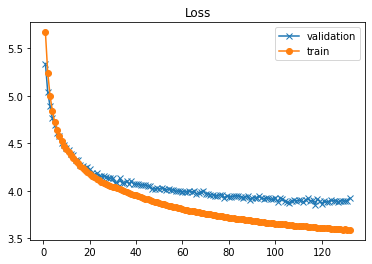

smallest val loss: (117, 3.8542318)
Current Lr:  0.00026666443

Time taken for this epoch: 23.45 secs

Epoch 133 Batch 0 Loss 3.3776
Epoch 133 Batch 150 Loss 3.5038
Epoch 133 Batch 300 Loss 3.5368
Epoch 133 Batch 450 Loss 3.5516
Epoch 133 Batch 600 Loss 3.5676
Epoch 133 Batch 750 Loss 3.5829
validation started ...

* Validation loss: 3.8597071170806885 

* Train Loss 3.5867


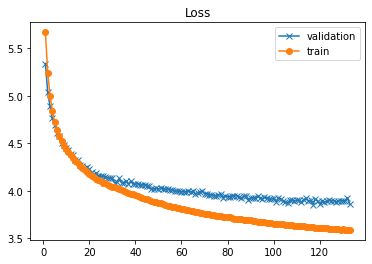

smallest val loss: (117, 3.8542318)
Current Lr:  0.0002640274

Time taken for this epoch: 23.67 secs

Epoch 134 Batch 0 Loss 3.6056
Epoch 134 Batch 150 Loss 3.5082
Epoch 134 Batch 300 Loss 3.5416
Epoch 134 Batch 450 Loss 3.5522
Epoch 134 Batch 600 Loss 3.5644
Epoch 134 Batch 750 Loss 3.5810
validation started ...

* Validation loss: 3.8815536499023438 

* Train Loss 3.5832


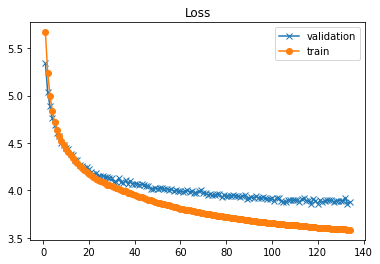

smallest val loss: (117, 3.8542318)
Current Lr:  0.00026141648

Time taken for this epoch: 23.46 secs

Epoch 135 Batch 0 Loss 3.5870
Epoch 135 Batch 150 Loss 3.5257
Epoch 135 Batch 300 Loss 3.5374
Epoch 135 Batch 450 Loss 3.5482
Epoch 135 Batch 600 Loss 3.5649
Epoch 135 Batch 750 Loss 3.5802
validation started ...

* Validation loss: 3.8773157596588135 

* Train Loss 3.5822


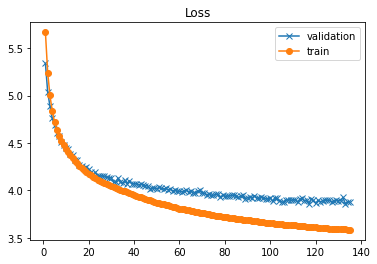

smallest val loss: (117, 3.8542318)
Current Lr:  0.0002588313

Time taken for this epoch: 23.52 secs

Epoch 136 Batch 0 Loss 3.4041
Epoch 136 Batch 150 Loss 3.4924
Epoch 136 Batch 300 Loss 3.5314
Epoch 136 Batch 450 Loss 3.5462
Epoch 136 Batch 600 Loss 3.5612
Epoch 136 Batch 750 Loss 3.5767
validation started ...

* Validation loss: 3.8684449195861816 

* Train Loss 3.5792


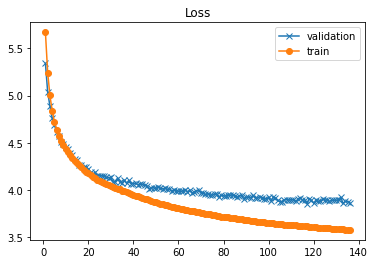

smallest val loss: (117, 3.8542318)
Current Lr:  0.00025627177

Time taken for this epoch: 23.60 secs

Epoch 137 Batch 0 Loss 3.5452
Epoch 137 Batch 150 Loss 3.5041
Epoch 137 Batch 300 Loss 3.5259
Epoch 137 Batch 450 Loss 3.5421
Epoch 137 Batch 600 Loss 3.5591
Epoch 137 Batch 750 Loss 3.5732
validation started ...

* Validation loss: 3.8776986598968506 

* Train Loss 3.5783


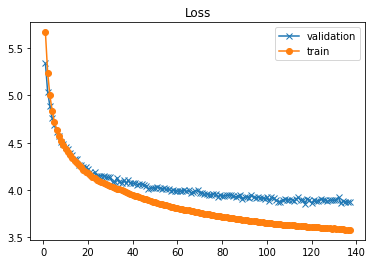

smallest val loss: (117, 3.8542318)
Current Lr:  0.00025373758

Time taken for this epoch: 23.46 secs

Epoch 138 Batch 0 Loss 3.6925
Epoch 138 Batch 150 Loss 3.4973
Epoch 138 Batch 300 Loss 3.5233
Epoch 138 Batch 450 Loss 3.5438
Epoch 138 Batch 600 Loss 3.5581
Epoch 138 Batch 750 Loss 3.5739
validation started ...

* Validation loss: 3.8668229579925537 

* Train Loss 3.5772


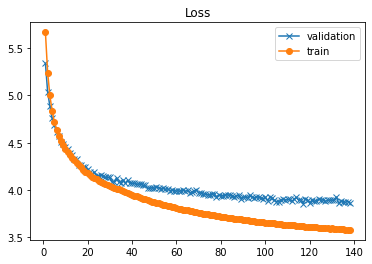

smallest val loss: (117, 3.8542318)
Current Lr:  0.0002512284

Time taken for this epoch: 23.41 secs

Epoch 139 Batch 0 Loss 3.7018
Epoch 139 Batch 150 Loss 3.5140
Epoch 139 Batch 300 Loss 3.5296
Epoch 139 Batch 450 Loss 3.5432
Epoch 139 Batch 600 Loss 3.5567
Epoch 139 Batch 750 Loss 3.5726
validation started ...

* Validation loss: 3.889263868331909 

* Train Loss 3.5764


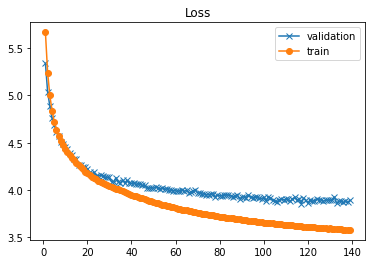

smallest val loss: (117, 3.8542318)
Current Lr:  0.00024874407

Time taken for this epoch: 23.44 secs

Epoch 140 Batch 0 Loss 3.5178
Epoch 140 Batch 150 Loss 3.4995
Epoch 140 Batch 300 Loss 3.5182
Epoch 140 Batch 450 Loss 3.5397
Epoch 140 Batch 600 Loss 3.5504
Epoch 140 Batch 750 Loss 3.5709
validation started ...

* Validation loss: 3.878161668777466 

* Train Loss 3.5735


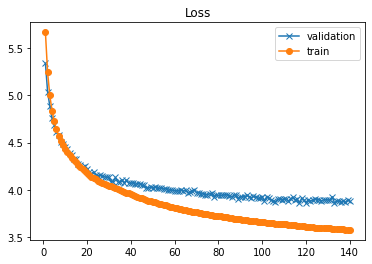

smallest val loss: (117, 3.8542318)
Current Lr:  0.00024628424

Time taken for this epoch: 23.41 secs

Epoch 141 Batch 0 Loss 3.4826
Epoch 141 Batch 150 Loss 3.4983
Epoch 141 Batch 300 Loss 3.5306
Epoch 141 Batch 450 Loss 3.5430
Epoch 141 Batch 600 Loss 3.5515
Epoch 141 Batch 750 Loss 3.5693
validation started ...

* Validation loss: 3.8739829063415527 

* Train Loss 3.5712


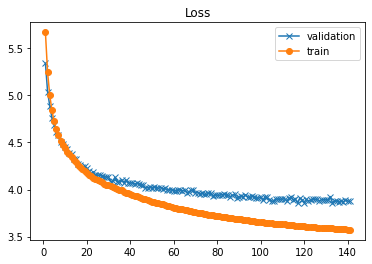

smallest val loss: (117, 3.8542318)
Current Lr:  0.00024384874

Time taken for this epoch: 23.48 secs

Epoch 142 Batch 0 Loss 3.8002
Epoch 142 Batch 150 Loss 3.4928
Epoch 142 Batch 300 Loss 3.5237
Epoch 142 Batch 450 Loss 3.5355
Epoch 142 Batch 600 Loss 3.5520
Epoch 142 Batch 750 Loss 3.5676
validation started ...

* Validation loss: 3.8923845291137695 

* Train Loss 3.5692


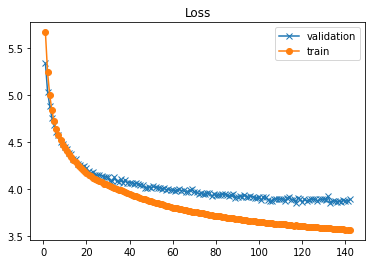

smallest val loss: (117, 3.8542318)
Current Lr:  0.00024143739

Time taken for this epoch: 23.59 secs

Epoch 143 Batch 0 Loss 3.6247
Epoch 143 Batch 150 Loss 3.5167
Epoch 143 Batch 300 Loss 3.5230
Epoch 143 Batch 450 Loss 3.5364
Epoch 143 Batch 600 Loss 3.5520
Epoch 143 Batch 750 Loss 3.5680
validation started ...

* Validation loss: 3.881969690322876 

* Train Loss 3.5705


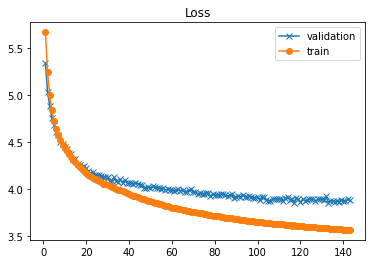

smallest val loss: (117, 3.8542318)
Current Lr:  0.00023904983

Time taken for this epoch: 23.56 secs

Epoch 144 Batch 0 Loss 3.4373
Epoch 144 Batch 150 Loss 3.4784
Epoch 144 Batch 300 Loss 3.5137
Epoch 144 Batch 450 Loss 3.5288
Epoch 144 Batch 600 Loss 3.5476
Epoch 144 Batch 750 Loss 3.5660
validation started ...

* Validation loss: 3.886979103088379 

* Train Loss 3.5684


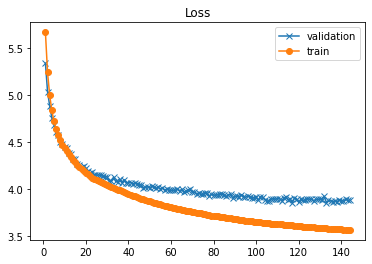

smallest val loss: (117, 3.8542318)
Current Lr:  0.00023668591

Time taken for this epoch: 23.40 secs

Epoch 145 Batch 0 Loss 3.5142
Epoch 145 Batch 150 Loss 3.4913
Epoch 145 Batch 300 Loss 3.5159
Epoch 145 Batch 450 Loss 3.5311
Epoch 145 Batch 600 Loss 3.5437
Epoch 145 Batch 750 Loss 3.5578
validation started ...

* Validation loss: 3.8588881492614746 

* Train Loss 3.5613


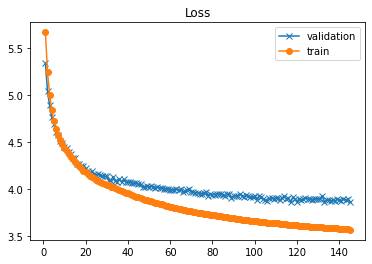

smallest val loss: (117, 3.8542318)
Current Lr:  0.00023434535

Time taken for this epoch: 23.49 secs

Epoch 146 Batch 0 Loss 3.5717
Epoch 146 Batch 150 Loss 3.4888
Epoch 146 Batch 300 Loss 3.5162
Epoch 146 Batch 450 Loss 3.5308
Epoch 146 Batch 600 Loss 3.5481
Epoch 146 Batch 750 Loss 3.5605
validation started ...

* Validation loss: 3.859149694442749 

* Train Loss 3.5619


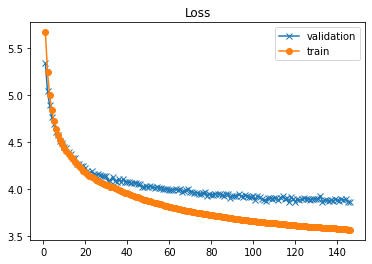

smallest val loss: (117, 3.8542318)
Current Lr:  0.00023202795

Time taken for this epoch: 23.58 secs

Epoch 147 Batch 0 Loss 3.5155
Epoch 147 Batch 150 Loss 3.4859
Epoch 147 Batch 300 Loss 3.5036
Epoch 147 Batch 450 Loss 3.5240
Epoch 147 Batch 600 Loss 3.5448
Epoch 147 Batch 750 Loss 3.5589
validation started ...

* Validation loss: 3.8616585731506348 

* Train Loss 3.5609


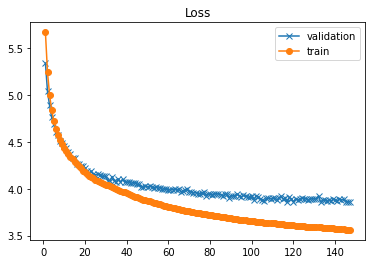

smallest val loss: (117, 3.8542318)
Current Lr:  0.00022973346

Time taken for this epoch: 23.50 secs

Epoch 148 Batch 0 Loss 3.7296
Epoch 148 Batch 150 Loss 3.5048
Epoch 148 Batch 300 Loss 3.5203
Epoch 148 Batch 450 Loss 3.5318
Epoch 148 Batch 600 Loss 3.5352
Epoch 148 Batch 750 Loss 3.5561
validation started ...

* Validation loss: 3.8859903812408447 

* Train Loss 3.5605


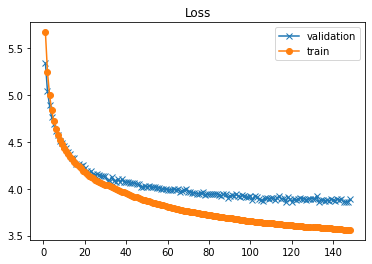

smallest val loss: (117, 3.8542318)
Current Lr:  0.00022746163

Time taken for this epoch: 23.59 secs

Epoch 149 Batch 0 Loss 3.3695
Epoch 149 Batch 150 Loss 3.4931
Epoch 149 Batch 300 Loss 3.5025
Epoch 149 Batch 450 Loss 3.5267
Epoch 149 Batch 600 Loss 3.5426
Epoch 149 Batch 750 Loss 3.5578
validation started ...

* Validation loss: 3.8655922412872314 

* Train Loss 3.5605


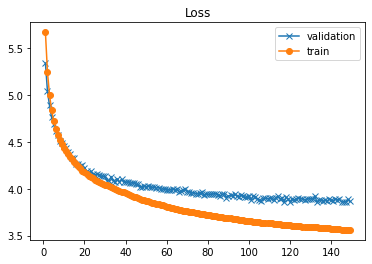

smallest val loss: (117, 3.8542318)
Current Lr:  0.00022521231

Time taken for this epoch: 23.60 secs

Epoch 150 Batch 0 Loss 3.2429
Epoch 150 Batch 150 Loss 3.4978
Epoch 150 Batch 300 Loss 3.5151
Epoch 150 Batch 450 Loss 3.5304
Epoch 150 Batch 600 Loss 3.5386
Epoch 150 Batch 750 Loss 3.5539
validation started ...

* Validation loss: 3.851818323135376 

* Train Loss 3.5559


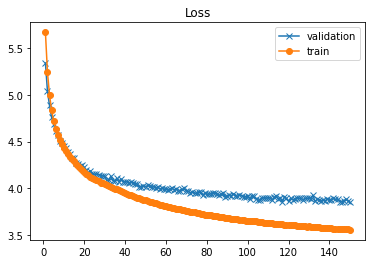

smallest val loss: (150, 3.8518183)
Current Lr:  0.00022298524

Time taken for this epoch: 23.61 secs

Epoch 151 Batch 0 Loss 3.2155
Epoch 151 Batch 150 Loss 3.4814
Epoch 151 Batch 300 Loss 3.5041
Epoch 151 Batch 450 Loss 3.5189
Epoch 151 Batch 600 Loss 3.5377
Epoch 151 Batch 750 Loss 3.5524
validation started ...

* Validation loss: 3.886031150817871 

* Train Loss 3.5546


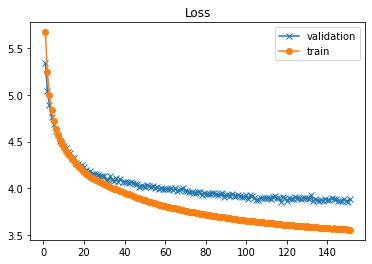

smallest val loss: (150, 3.8518183)
Current Lr:  0.00022078013

Time taken for this epoch: 23.44 secs

Epoch 152 Batch 0 Loss 3.4522
Epoch 152 Batch 150 Loss 3.4881
Epoch 152 Batch 300 Loss 3.5147
Epoch 152 Batch 450 Loss 3.5244
Epoch 152 Batch 600 Loss 3.5378
Epoch 152 Batch 750 Loss 3.5511
validation started ...

* Validation loss: 3.868691921234131 

* Train Loss 3.5542


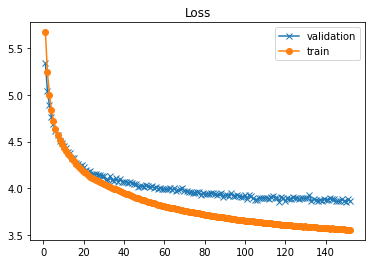

smallest val loss: (150, 3.8518183)
Current Lr:  0.00021859692

Time taken for this epoch: 23.47 secs

Epoch 153 Batch 0 Loss 3.1921
Epoch 153 Batch 150 Loss 3.4848
Epoch 153 Batch 300 Loss 3.5025
Epoch 153 Batch 450 Loss 3.5245
Epoch 153 Batch 600 Loss 3.5378
Epoch 153 Batch 750 Loss 3.5524
validation started ...

* Validation loss: 3.8942136764526367 

* Train Loss 3.5552


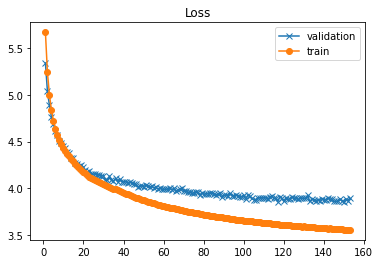

smallest val loss: (150, 3.8518183)
Current Lr:  0.00021643523

Time taken for this epoch: 23.56 secs

Epoch 154 Batch 0 Loss 3.3544
Epoch 154 Batch 150 Loss 3.4728
Epoch 154 Batch 300 Loss 3.5092
Epoch 154 Batch 450 Loss 3.5194
Epoch 154 Batch 600 Loss 3.5322
Epoch 154 Batch 750 Loss 3.5517
validation started ...

* Validation loss: 3.873807668685913 

* Train Loss 3.5531


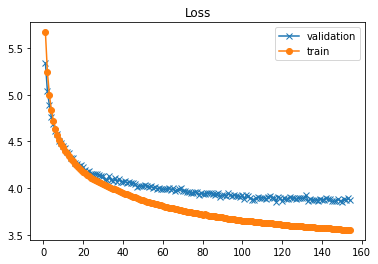

smallest val loss: (150, 3.8518183)
Current Lr:  0.00021429491

Time taken for this epoch: 27.96 secs

Epoch 155 Batch 0 Loss 3.5334
Epoch 155 Batch 150 Loss 3.4815
Epoch 155 Batch 300 Loss 3.5117
Epoch 155 Batch 450 Loss 3.5146
Epoch 155 Batch 600 Loss 3.5303
Epoch 155 Batch 750 Loss 3.5458
validation started ...

* Validation loss: 3.8644864559173584 

* Train Loss 3.5486


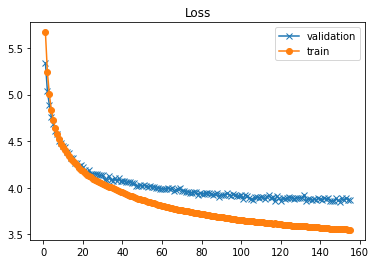

smallest val loss: (150, 3.8518183)
Current Lr:  0.00021217579

Time taken for this epoch: 23.43 secs

Epoch 156 Batch 0 Loss 3.4577
Epoch 156 Batch 150 Loss 3.4975
Epoch 156 Batch 300 Loss 3.5169
Epoch 156 Batch 450 Loss 3.5243
Epoch 156 Batch 600 Loss 3.5326
Epoch 156 Batch 750 Loss 3.5448
validation started ...

* Validation loss: 3.86077880859375 

* Train Loss 3.5474


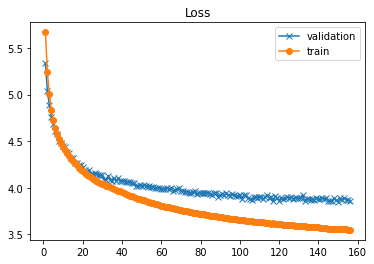

smallest val loss: (150, 3.8518183)
Current Lr:  0.0002100776

Time taken for this epoch: 23.48 secs

Epoch 157 Batch 0 Loss 3.3110
Epoch 157 Batch 150 Loss 3.4844
Epoch 157 Batch 300 Loss 3.5041
Epoch 157 Batch 450 Loss 3.5187
Epoch 157 Batch 600 Loss 3.5348
Epoch 157 Batch 750 Loss 3.5467
validation started ...

* Validation loss: 3.839656114578247 

* Train Loss 3.5479

Saving checkpoint for epoch 157 at checkpoints4/ckpt-12


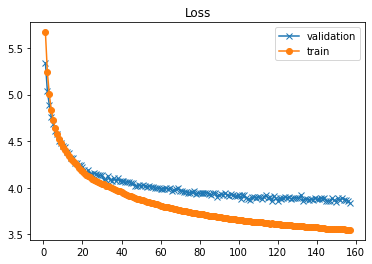

smallest val loss: (157, 3.839656)
Current Lr:  0.00020800019

Time taken for this epoch: 23.66 secs

Epoch 158 Batch 0 Loss 3.6225
Epoch 158 Batch 150 Loss 3.4762
Epoch 158 Batch 300 Loss 3.4991
Epoch 158 Batch 450 Loss 3.5147
Epoch 158 Batch 600 Loss 3.5319
Epoch 158 Batch 750 Loss 3.5451
validation started ...

* Validation loss: 3.8652236461639404 

* Train Loss 3.5462


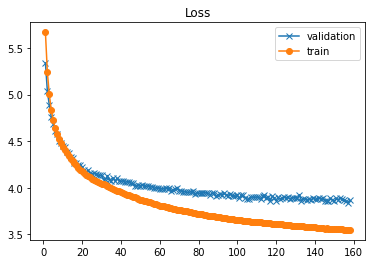

smallest val loss: (157, 3.839656)
Current Lr:  0.00020594332

Time taken for this epoch: 23.41 secs

Epoch 159 Batch 0 Loss 3.5621
Epoch 159 Batch 150 Loss 3.4778
Epoch 159 Batch 300 Loss 3.4990
Epoch 159 Batch 450 Loss 3.5097
Epoch 159 Batch 600 Loss 3.5255
Epoch 159 Batch 750 Loss 3.5392
validation started ...

* Validation loss: 3.8481292724609375 

* Train Loss 3.5422


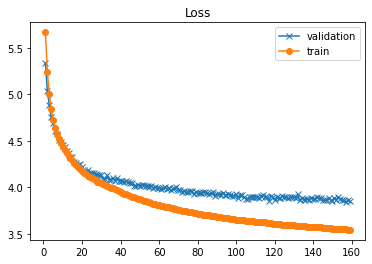

smallest val loss: (157, 3.839656)
Current Lr:  0.00020390675

Time taken for this epoch: 23.46 secs

Epoch 160 Batch 0 Loss 3.7530
Epoch 160 Batch 150 Loss 3.4890
Epoch 160 Batch 300 Loss 3.5064
Epoch 160 Batch 450 Loss 3.5214
Epoch 160 Batch 600 Loss 3.5273
Epoch 160 Batch 750 Loss 3.5403
validation started ...

* Validation loss: 3.8567252159118652 

* Train Loss 3.5427


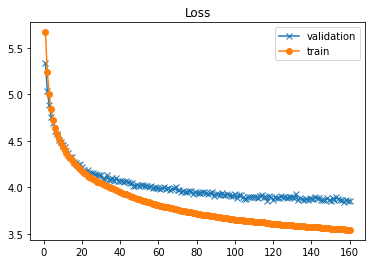

smallest val loss: (157, 3.839656)
Current Lr:  0.00020189033

Time taken for this epoch: 23.47 secs

Epoch 161 Batch 0 Loss 3.1329
Epoch 161 Batch 150 Loss 3.4875
Epoch 161 Batch 300 Loss 3.4944
Epoch 161 Batch 450 Loss 3.5078
Epoch 161 Batch 600 Loss 3.5228
Epoch 161 Batch 750 Loss 3.5372
validation started ...

* Validation loss: 3.8545477390289307 

* Train Loss 3.5402


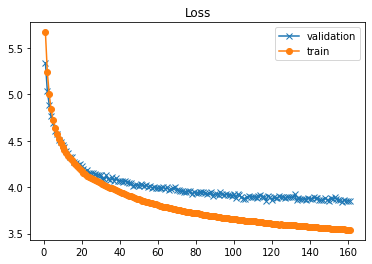

smallest val loss: (157, 3.839656)
Current Lr:  0.00019989387

Time taken for this epoch: 23.44 secs

Epoch 162 Batch 0 Loss 3.6223
Epoch 162 Batch 150 Loss 3.4785
Epoch 162 Batch 300 Loss 3.4959
Epoch 162 Batch 450 Loss 3.5117
Epoch 162 Batch 600 Loss 3.5232
Epoch 162 Batch 750 Loss 3.5381
validation started ...

* Validation loss: 3.8632524013519287 

* Train Loss 3.5400


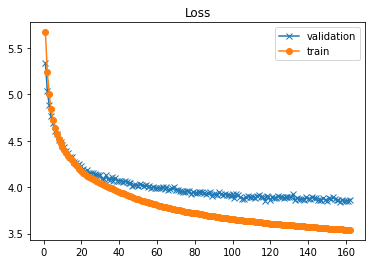

smallest val loss: (157, 3.839656)
Current Lr:  0.00019791716

Time taken for this epoch: 23.51 secs

Epoch 163 Batch 0 Loss 3.3914
Epoch 163 Batch 150 Loss 3.4854
Epoch 163 Batch 300 Loss 3.5003
Epoch 163 Batch 450 Loss 3.5136
Epoch 163 Batch 600 Loss 3.5276
Epoch 163 Batch 750 Loss 3.5357
validation started ...

* Validation loss: 3.8560197353363037 

* Train Loss 3.5377


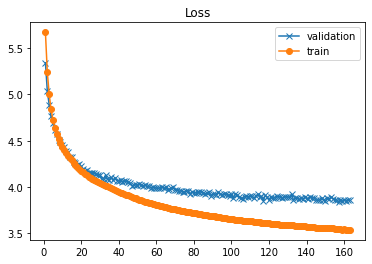

smallest val loss: (157, 3.839656)
Current Lr:  0.00019595999

Time taken for this epoch: 23.44 secs

Epoch 164 Batch 0 Loss 3.4882
Epoch 164 Batch 150 Loss 3.4654
Epoch 164 Batch 300 Loss 3.4908
Epoch 164 Batch 450 Loss 3.4994
Epoch 164 Batch 600 Loss 3.5155
Epoch 164 Batch 750 Loss 3.5362
validation started ...

* Validation loss: 3.8638930320739746 

* Train Loss 3.5380


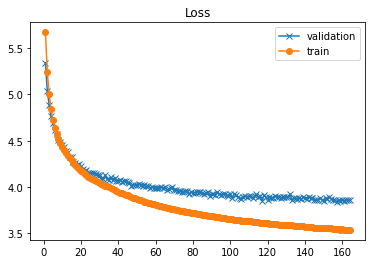

smallest val loss: (157, 3.839656)
Current Lr:  0.00019402217

Time taken for this epoch: 23.62 secs

Epoch 165 Batch 0 Loss 3.2513
Epoch 165 Batch 150 Loss 3.4692
Epoch 165 Batch 300 Loss 3.4914
Epoch 165 Batch 450 Loss 3.5121
Epoch 165 Batch 600 Loss 3.5192
Epoch 165 Batch 750 Loss 3.5334
validation started ...

* Validation loss: 3.8652939796447754 

* Train Loss 3.5352


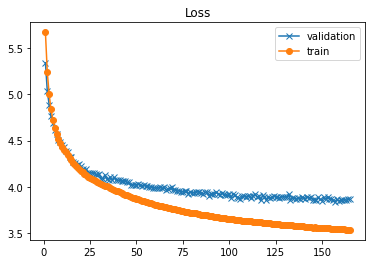

smallest val loss: (157, 3.839656)
Current Lr:  0.00019210353

Time taken for this epoch: 23.60 secs

Epoch 166 Batch 0 Loss 3.4167
Epoch 166 Batch 150 Loss 3.4588
Epoch 166 Batch 300 Loss 3.4774
Epoch 166 Batch 450 Loss 3.5042
Epoch 166 Batch 600 Loss 3.5167
Epoch 166 Batch 750 Loss 3.5313
validation started ...

* Validation loss: 3.8545126914978027 

* Train Loss 3.5336


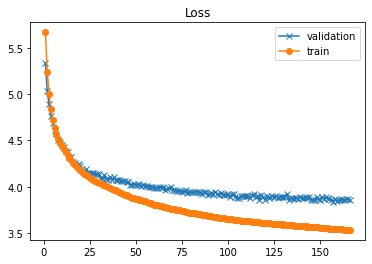

smallest val loss: (157, 3.839656)
Current Lr:  0.0001902038

Time taken for this epoch: 23.48 secs

Epoch 167 Batch 0 Loss 3.4981
Epoch 167 Batch 150 Loss 3.4599
Epoch 167 Batch 300 Loss 3.4862
Epoch 167 Batch 450 Loss 3.5046
Epoch 167 Batch 600 Loss 3.5186
Epoch 167 Batch 750 Loss 3.5298
validation started ...

* Validation loss: 3.8544678688049316 

* Train Loss 3.5327


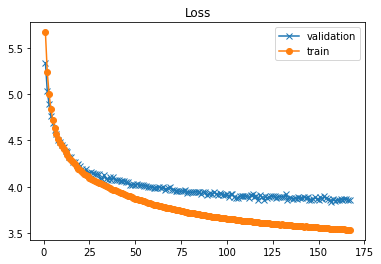

smallest val loss: (157, 3.839656)
Current Lr:  0.00018832293

Time taken for this epoch: 23.65 secs

Epoch 168 Batch 0 Loss 3.2287
Epoch 168 Batch 150 Loss 3.4713
Epoch 168 Batch 300 Loss 3.5013
Epoch 168 Batch 450 Loss 3.5047
Epoch 168 Batch 600 Loss 3.5167
Epoch 168 Batch 750 Loss 3.5289
validation started ...

* Validation loss: 3.8280394077301025 

* Train Loss 3.5314


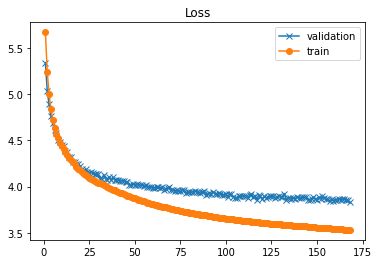

smallest val loss: (168, 3.8280394)
Current Lr:  0.0001864606

Time taken for this epoch: 23.83 secs

Epoch 169 Batch 0 Loss 3.3948
Epoch 169 Batch 150 Loss 3.4838
Epoch 169 Batch 300 Loss 3.4983
Epoch 169 Batch 450 Loss 3.5092
Epoch 169 Batch 600 Loss 3.5184
Epoch 169 Batch 750 Loss 3.5276
validation started ...

* Validation loss: 3.87019944190979 

* Train Loss 3.5307


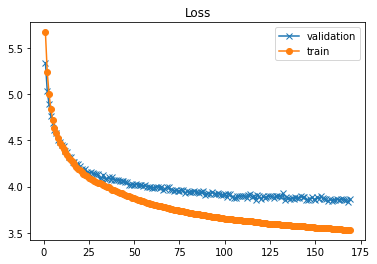

smallest val loss: (168, 3.8280394)
Current Lr:  0.00018461676

Time taken for this epoch: 23.60 secs

Epoch 170 Batch 0 Loss 3.3137
Epoch 170 Batch 150 Loss 3.4689
Epoch 170 Batch 300 Loss 3.4986
Epoch 170 Batch 450 Loss 3.5104
Epoch 170 Batch 600 Loss 3.5165
Epoch 170 Batch 750 Loss 3.5273
validation started ...

* Validation loss: 3.852403402328491 

* Train Loss 3.5289


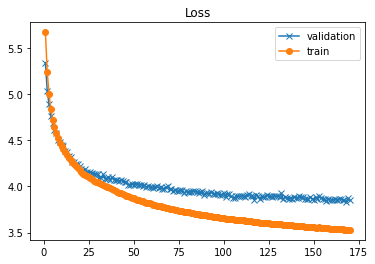

smallest val loss: (168, 3.8280394)
Current Lr:  0.0001827911

Time taken for this epoch: 23.53 secs

Epoch 171 Batch 0 Loss 3.5073
Epoch 171 Batch 150 Loss 3.4783
Epoch 171 Batch 300 Loss 3.4911
Epoch 171 Batch 450 Loss 3.5028
Epoch 171 Batch 600 Loss 3.5084
Epoch 171 Batch 750 Loss 3.5250
validation started ...

* Validation loss: 3.833759069442749 

* Train Loss 3.5277


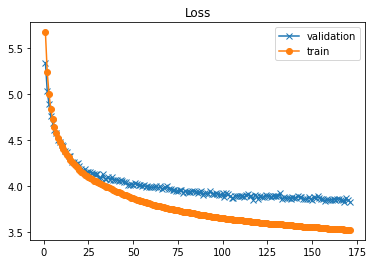

smallest val loss: (168, 3.8280394)
Current Lr:  0.0001809835

Time taken for this epoch: 23.59 secs

Epoch 172 Batch 0 Loss 3.5290
Epoch 172 Batch 150 Loss 3.4748
Epoch 172 Batch 300 Loss 3.4876
Epoch 172 Batch 450 Loss 3.4944
Epoch 172 Batch 600 Loss 3.5030
Epoch 172 Batch 750 Loss 3.5212
validation started ...

* Validation loss: 3.8451530933380127 

* Train Loss 3.5243


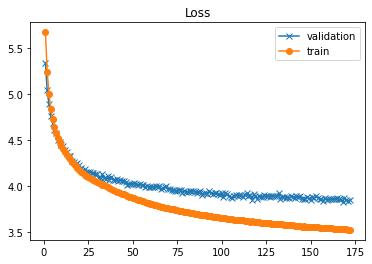

smallest val loss: (168, 3.8280394)
Current Lr:  0.00017919378

Time taken for this epoch: 23.48 secs

Epoch 173 Batch 0 Loss 3.5635
Epoch 173 Batch 150 Loss 3.4429
Epoch 173 Batch 300 Loss 3.4774
Epoch 173 Batch 450 Loss 3.4929
Epoch 173 Batch 600 Loss 3.5084
Epoch 173 Batch 750 Loss 3.5234
validation started ...

* Validation loss: 3.8392908573150635 

* Train Loss 3.5260


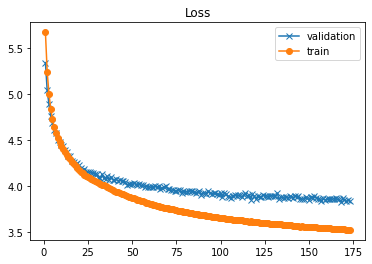

smallest val loss: (168, 3.8280394)
Current Lr:  0.00017742174

Time taken for this epoch: 23.48 secs

Epoch 174 Batch 0 Loss 3.4667
Epoch 174 Batch 150 Loss 3.4493
Epoch 174 Batch 300 Loss 3.4728
Epoch 174 Batch 450 Loss 3.4929
Epoch 174 Batch 600 Loss 3.5058
Epoch 174 Batch 750 Loss 3.5199
validation started ...

* Validation loss: 3.866391658782959 

* Train Loss 3.5227


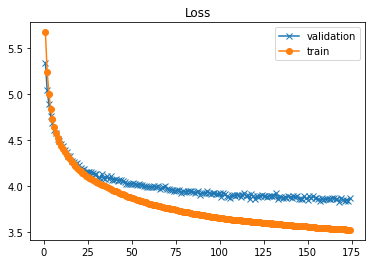

smallest val loss: (168, 3.8280394)
Current Lr:  0.00017566724

Time taken for this epoch: 23.55 secs

Epoch 175 Batch 0 Loss 3.1227
Epoch 175 Batch 150 Loss 3.4976
Epoch 175 Batch 300 Loss 3.4866
Epoch 175 Batch 450 Loss 3.4891
Epoch 175 Batch 600 Loss 3.5050
Epoch 175 Batch 750 Loss 3.5212
validation started ...

* Validation loss: 3.876312255859375 

* Train Loss 3.5232


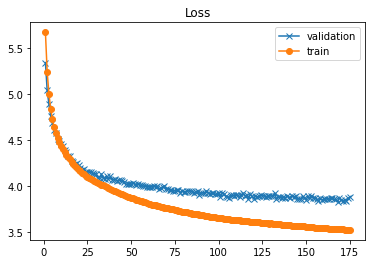

smallest val loss: (168, 3.8280394)
Current Lr:  0.00017393014

Time taken for this epoch: 23.46 secs

Epoch 176 Batch 0 Loss 3.5508
Epoch 176 Batch 150 Loss 3.4773
Epoch 176 Batch 300 Loss 3.4870
Epoch 176 Batch 450 Loss 3.4935
Epoch 176 Batch 600 Loss 3.5035
Epoch 176 Batch 750 Loss 3.5181
validation started ...

* Validation loss: 3.85296630859375 

* Train Loss 3.5198


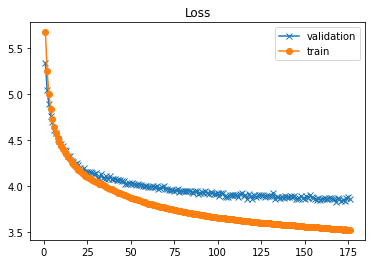

smallest val loss: (168, 3.8280394)
Current Lr:  0.00017221012

Time taken for this epoch: 23.55 secs

Epoch 177 Batch 0 Loss 3.2941
Epoch 177 Batch 150 Loss 3.4739
Epoch 177 Batch 300 Loss 3.4804
Epoch 177 Batch 450 Loss 3.4920
Epoch 177 Batch 600 Loss 3.5036
Epoch 177 Batch 750 Loss 3.5173
validation started ...

* Validation loss: 3.84433650970459 

* Train Loss 3.5195


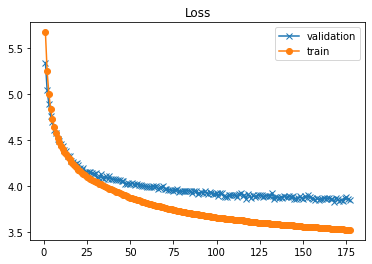

smallest val loss: (168, 3.8280394)
Current Lr:  0.00017050719

Time taken for this epoch: 23.46 secs

Epoch 178 Batch 0 Loss 3.4616
Epoch 178 Batch 150 Loss 3.4515
Epoch 178 Batch 300 Loss 3.4707
Epoch 178 Batch 450 Loss 3.4841
Epoch 178 Batch 600 Loss 3.5024
Epoch 178 Batch 750 Loss 3.5160
validation started ...

* Validation loss: 3.8465306758880615 

* Train Loss 3.5182


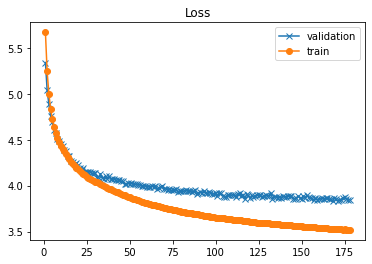

smallest val loss: (168, 3.8280394)
Current Lr:  0.00016882105

Time taken for this epoch: 23.61 secs

Epoch 179 Batch 0 Loss 3.6059
Epoch 179 Batch 150 Loss 3.4605
Epoch 179 Batch 300 Loss 3.4730
Epoch 179 Batch 450 Loss 3.4874
Epoch 179 Batch 600 Loss 3.4981
Epoch 179 Batch 750 Loss 3.5144
validation started ...

* Validation loss: 3.869469404220581 

* Train Loss 3.5181


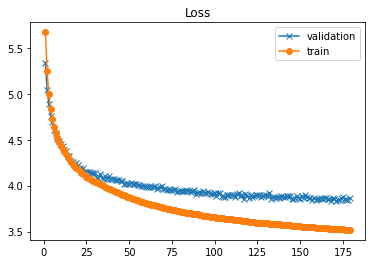

smallest val loss: (168, 3.8280394)
Current Lr:  0.0001671516

Time taken for this epoch: 23.43 secs

Epoch 180 Batch 0 Loss 3.4797
Epoch 180 Batch 150 Loss 3.4684
Epoch 180 Batch 300 Loss 3.4891
Epoch 180 Batch 450 Loss 3.4947
Epoch 180 Batch 600 Loss 3.5054
Epoch 180 Batch 750 Loss 3.5149
validation started ...

* Validation loss: 3.841912031173706 

* Train Loss 3.5154


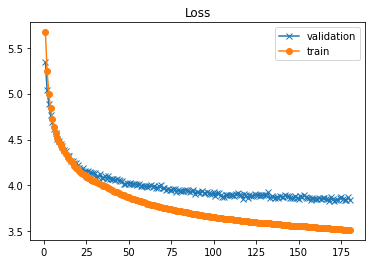

smallest val loss: (168, 3.8280394)
Current Lr:  0.00016549868

Time taken for this epoch: 23.48 secs

Epoch 181 Batch 0 Loss 3.3190
Epoch 181 Batch 150 Loss 3.4698
Epoch 181 Batch 300 Loss 3.4688
Epoch 181 Batch 450 Loss 3.4879
Epoch 181 Batch 600 Loss 3.5026
Epoch 181 Batch 750 Loss 3.5150
validation started ...

* Validation loss: 3.8769357204437256 

* Train Loss 3.5146


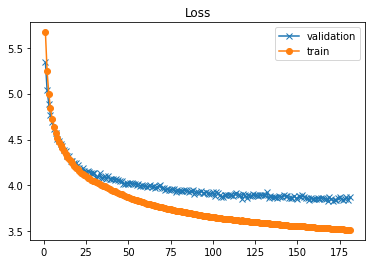

smallest val loss: (168, 3.8280394)
Current Lr:  0.00016386206

Time taken for this epoch: 23.54 secs

Epoch 182 Batch 0 Loss 3.4453
Epoch 182 Batch 150 Loss 3.4619
Epoch 182 Batch 300 Loss 3.4788
Epoch 182 Batch 450 Loss 3.4872
Epoch 182 Batch 600 Loss 3.4951
Epoch 182 Batch 750 Loss 3.5102
validation started ...

* Validation loss: 3.874131679534912 

* Train Loss 3.5133


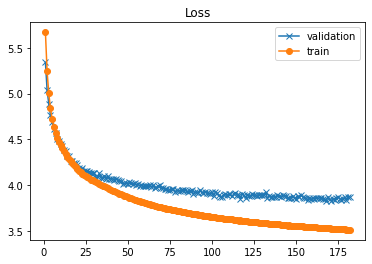

smallest val loss: (168, 3.8280394)
Current Lr:  0.00016224167

Time taken for this epoch: 27.98 secs

Epoch 183 Batch 0 Loss 3.2396
Epoch 183 Batch 150 Loss 3.4610
Epoch 183 Batch 300 Loss 3.4770
Epoch 183 Batch 450 Loss 3.4898
Epoch 183 Batch 600 Loss 3.5019
Epoch 183 Batch 750 Loss 3.5136
validation started ...

* Validation loss: 3.8468515872955322 

* Train Loss 3.5146


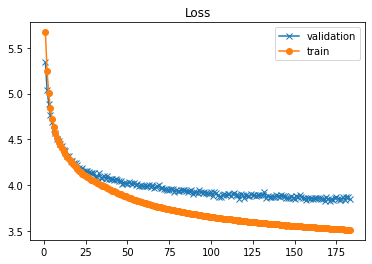

smallest val loss: (168, 3.8280394)
Current Lr:  0.00016063728

Time taken for this epoch: 23.45 secs

Epoch 184 Batch 0 Loss 3.3621
Epoch 184 Batch 150 Loss 3.4392
Epoch 184 Batch 300 Loss 3.4581
Epoch 184 Batch 450 Loss 3.4776
Epoch 184 Batch 600 Loss 3.4912
Epoch 184 Batch 750 Loss 3.5124
validation started ...

* Validation loss: 3.8530051708221436 

* Train Loss 3.5131


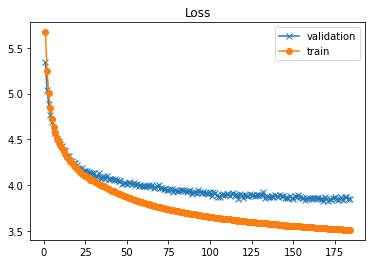

smallest val loss: (168, 3.8280394)
Current Lr:  0.00015904875

Time taken for this epoch: 23.43 secs

Epoch 185 Batch 0 Loss 3.3581
Epoch 185 Batch 150 Loss 3.4580
Epoch 185 Batch 300 Loss 3.4697
Epoch 185 Batch 450 Loss 3.4841
Epoch 185 Batch 600 Loss 3.5018
Epoch 185 Batch 750 Loss 3.5123
validation started ...

* Validation loss: 3.8404996395111084 

* Train Loss 3.5139


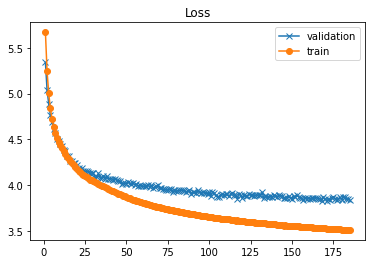

smallest val loss: (168, 3.8280394)
Current Lr:  0.00015747595

Time taken for this epoch: 23.54 secs

Epoch 186 Batch 0 Loss 3.3473
Epoch 186 Batch 150 Loss 3.4734
Epoch 186 Batch 300 Loss 3.4761
Epoch 186 Batch 450 Loss 3.4831
Epoch 186 Batch 600 Loss 3.4955
Epoch 186 Batch 750 Loss 3.5036
validation started ...

* Validation loss: 3.8322408199310303 

* Train Loss 3.5080


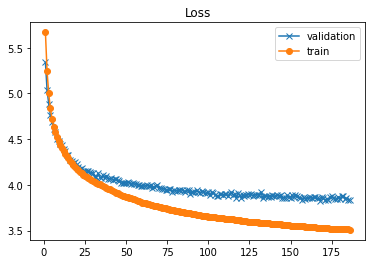

smallest val loss: (168, 3.8280394)
Current Lr:  0.00015591868

Time taken for this epoch: 27.91 secs

Epoch 187 Batch 0 Loss 3.2674
Epoch 187 Batch 150 Loss 3.4510
Epoch 187 Batch 300 Loss 3.4732
Epoch 187 Batch 450 Loss 3.4877
Epoch 187 Batch 600 Loss 3.4967
Epoch 187 Batch 750 Loss 3.5073
validation started ...

* Validation loss: 3.842550039291382 

* Train Loss 3.5105


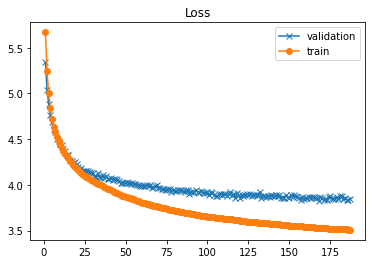

smallest val loss: (168, 3.8280394)
Current Lr:  0.00015437683

Time taken for this epoch: 23.44 secs

Epoch 188 Batch 0 Loss 3.4849
Epoch 188 Batch 150 Loss 3.4568
Epoch 188 Batch 300 Loss 3.4699
Epoch 188 Batch 450 Loss 3.4837
Epoch 188 Batch 600 Loss 3.4937
Epoch 188 Batch 750 Loss 3.5065
validation started ...

* Validation loss: 3.8524045944213867 

* Train Loss 3.5092


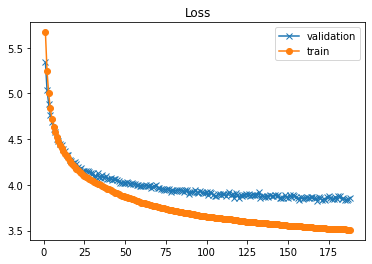

smallest val loss: (168, 3.8280394)
Current Lr:  0.00015285022

Time taken for this epoch: 23.40 secs

Epoch 189 Batch 0 Loss 3.1539
Epoch 189 Batch 150 Loss 3.4683
Epoch 189 Batch 300 Loss 3.4757
Epoch 189 Batch 450 Loss 3.4803
Epoch 189 Batch 600 Loss 3.4938
Epoch 189 Batch 750 Loss 3.5080
validation started ...

* Validation loss: 3.844804525375366 

* Train Loss 3.5096


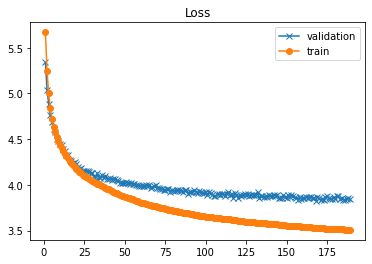

smallest val loss: (168, 3.8280394)
Current Lr:  0.00015133873

Time taken for this epoch: 23.45 secs

Epoch 190 Batch 0 Loss 3.4927
Epoch 190 Batch 150 Loss 3.4475
Epoch 190 Batch 300 Loss 3.4643
Epoch 190 Batch 450 Loss 3.4791
Epoch 190 Batch 600 Loss 3.4936
Epoch 190 Batch 750 Loss 3.5065
validation started ...

* Validation loss: 3.8521203994750977 

* Train Loss 3.5090


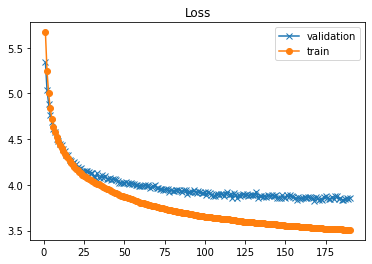

smallest val loss: (168, 3.8280394)
Current Lr:  0.00014984216

Time taken for this epoch: 23.48 secs

Epoch 191 Batch 0 Loss 3.1744
Epoch 191 Batch 150 Loss 3.4431
Epoch 191 Batch 300 Loss 3.4639
Epoch 191 Batch 450 Loss 3.4937
Epoch 191 Batch 600 Loss 3.4981
Epoch 191 Batch 750 Loss 3.5046
validation started ...

* Validation loss: 3.8523590564727783 

* Train Loss 3.5066


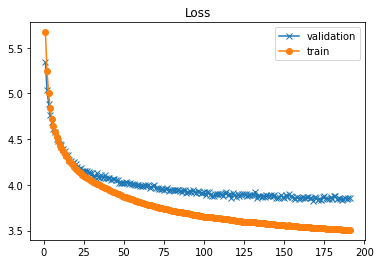

smallest val loss: (168, 3.8280394)
Current Lr:  0.00014836037

Time taken for this epoch: 23.67 secs

Epoch 192 Batch 0 Loss 3.6145
Epoch 192 Batch 150 Loss 3.4484
Epoch 192 Batch 300 Loss 3.4675
Epoch 192 Batch 450 Loss 3.4866
Epoch 192 Batch 600 Loss 3.4928
Epoch 192 Batch 750 Loss 3.5070
validation started ...

* Validation loss: 3.848738670349121 

* Train Loss 3.5073


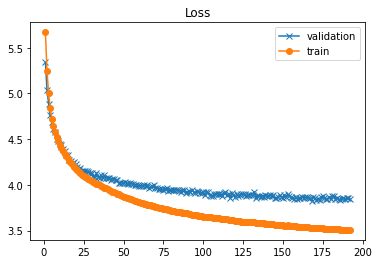

smallest val loss: (168, 3.8280394)
Current Lr:  0.00014689328

Time taken for this epoch: 24.07 secs

Epoch 193 Batch 0 Loss 3.2747
Epoch 193 Batch 150 Loss 3.4508
Epoch 193 Batch 300 Loss 3.4611
Epoch 193 Batch 450 Loss 3.4732
Epoch 193 Batch 600 Loss 3.4872
Epoch 193 Batch 750 Loss 3.5027
validation started ...

* Validation loss: 3.8622870445251465 

* Train Loss 3.5042


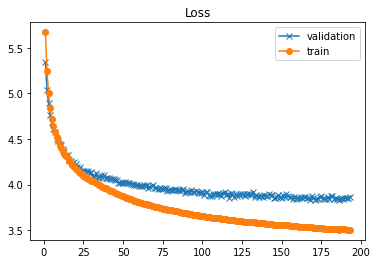

smallest val loss: (168, 3.8280394)
Current Lr:  0.00014544064

Time taken for this epoch: 23.89 secs

Epoch 194 Batch 0 Loss 3.4154
Epoch 194 Batch 150 Loss 3.4491
Epoch 194 Batch 300 Loss 3.4620
Epoch 194 Batch 450 Loss 3.4718
Epoch 194 Batch 600 Loss 3.4857
Epoch 194 Batch 750 Loss 3.5015
validation started ...

* Validation loss: 3.8417978286743164 

* Train Loss 3.5029


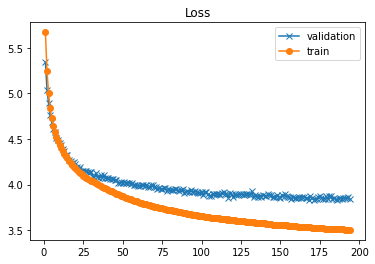

smallest val loss: (168, 3.8280394)
Current Lr:  0.00014400244

Time taken for this epoch: 23.57 secs

Epoch 195 Batch 0 Loss 3.0700
Epoch 195 Batch 150 Loss 3.4450
Epoch 195 Batch 300 Loss 3.4572
Epoch 195 Batch 450 Loss 3.4696
Epoch 195 Batch 600 Loss 3.4824
Epoch 195 Batch 750 Loss 3.5001
validation started ...

* Validation loss: 3.8655519485473633 

* Train Loss 3.5030


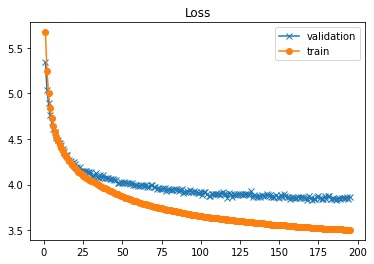

smallest val loss: (168, 3.8280394)
Current Lr:  0.00014257841

Time taken for this epoch: 23.57 secs

Epoch 196 Batch 0 Loss 3.4563
Epoch 196 Batch 150 Loss 3.4602
Epoch 196 Batch 300 Loss 3.4661
Epoch 196 Batch 450 Loss 3.4725
Epoch 196 Batch 600 Loss 3.4850
Epoch 196 Batch 750 Loss 3.4995
validation started ...

* Validation loss: 3.849940538406372 

* Train Loss 3.5007


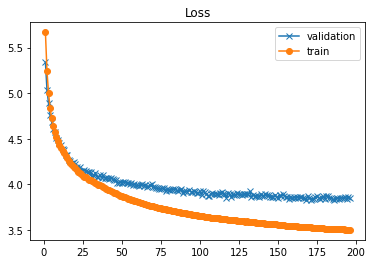

smallest val loss: (168, 3.8280394)
Current Lr:  0.00014116845

Time taken for this epoch: 23.67 secs

Epoch 197 Batch 0 Loss 3.3158
Epoch 197 Batch 150 Loss 3.4539
Epoch 197 Batch 300 Loss 3.4620
Epoch 197 Batch 450 Loss 3.4737
Epoch 197 Batch 600 Loss 3.4838
Epoch 197 Batch 750 Loss 3.4947
validation started ...

* Validation loss: 3.8318657875061035 

* Train Loss 3.4979


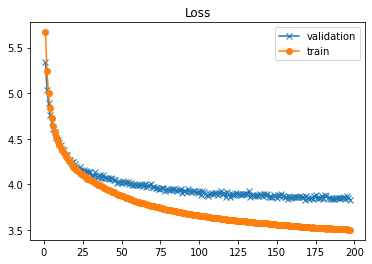

smallest val loss: (168, 3.8280394)
Current Lr:  0.00013977247

Time taken for this epoch: 23.54 secs

Epoch 198 Batch 0 Loss 3.5788
Epoch 198 Batch 150 Loss 3.4530
Epoch 198 Batch 300 Loss 3.4632
Epoch 198 Batch 450 Loss 3.4728
Epoch 198 Batch 600 Loss 3.4871
Epoch 198 Batch 750 Loss 3.4986
validation started ...

* Validation loss: 3.866978406906128 

* Train Loss 3.5001


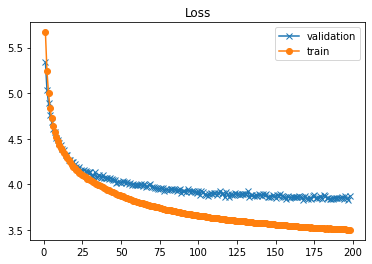

smallest val loss: (168, 3.8280394)
Current Lr:  0.00013839026

Time taken for this epoch: 23.52 secs

Epoch 199 Batch 0 Loss 3.1281
Epoch 199 Batch 150 Loss 3.4312
Epoch 199 Batch 300 Loss 3.4735
Epoch 199 Batch 450 Loss 3.4761
Epoch 199 Batch 600 Loss 3.4865
Epoch 199 Batch 750 Loss 3.4967
validation started ...

* Validation loss: 3.8450355529785156 

* Train Loss 3.5001


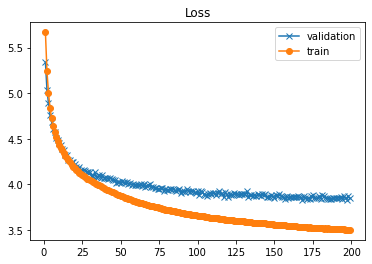

smallest val loss: (168, 3.8280394)
Current Lr:  0.00013702172

Time taken for this epoch: 23.52 secs

Epoch 200 Batch 0 Loss 3.4292
Epoch 200 Batch 150 Loss 3.4521
Epoch 200 Batch 300 Loss 3.4611
Epoch 200 Batch 450 Loss 3.4666
Epoch 200 Batch 600 Loss 3.4786
Epoch 200 Batch 750 Loss 3.4953
validation started ...

* Validation loss: 3.8830652236938477 

* Train Loss 3.4962


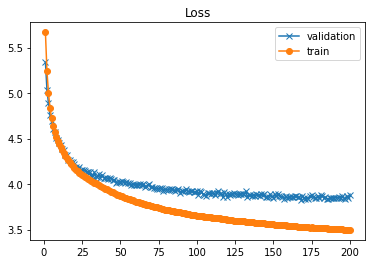

smallest val loss: (168, 3.8280394)
Current Lr:  0.00013566676

Time taken for this epoch: 23.53 secs

Epoch 201 Batch 0 Loss 3.4435
Epoch 201 Batch 150 Loss 3.4402
Epoch 201 Batch 300 Loss 3.4652
Epoch 201 Batch 450 Loss 3.4750
Epoch 201 Batch 600 Loss 3.4855
Epoch 201 Batch 750 Loss 3.4952
validation started ...

* Validation loss: 3.8293821811676025 

* Train Loss 3.4967


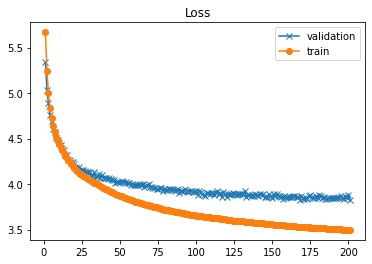

smallest val loss: (168, 3.8280394)
Current Lr:  0.00013432516

Time taken for this epoch: 23.57 secs

Epoch 202 Batch 0 Loss 3.3745
Epoch 202 Batch 150 Loss 3.4491
Epoch 202 Batch 300 Loss 3.4602
Epoch 202 Batch 450 Loss 3.4748
Epoch 202 Batch 600 Loss 3.4803
Epoch 202 Batch 750 Loss 3.4926
validation started ...

* Validation loss: 3.8447091579437256 

* Train Loss 3.4944


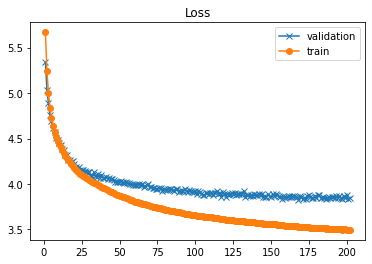

smallest val loss: (168, 3.8280394)
Current Lr:  0.00013299687

Time taken for this epoch: 23.52 secs

Epoch 203 Batch 0 Loss 3.4826
Epoch 203 Batch 150 Loss 3.4546
Epoch 203 Batch 300 Loss 3.4618
Epoch 203 Batch 450 Loss 3.4725
Epoch 203 Batch 600 Loss 3.4812
Epoch 203 Batch 750 Loss 3.4932
validation started ...

* Validation loss: 3.846348524093628 

* Train Loss 3.4952


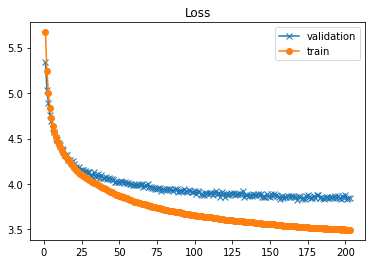

smallest val loss: (168, 3.8280394)
Current Lr:  0.00013168166

Time taken for this epoch: 23.86 secs

Epoch 204 Batch 0 Loss 3.7875
Epoch 204 Batch 150 Loss 3.4381
Epoch 204 Batch 300 Loss 3.4622
Epoch 204 Batch 450 Loss 3.4757
Epoch 204 Batch 600 Loss 3.4786
Epoch 204 Batch 750 Loss 3.4905
validation started ...

* Validation loss: 3.851547956466675 

* Train Loss 3.4929


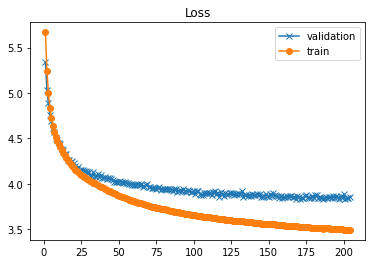

smallest val loss: (168, 3.8280394)
Current Lr:  0.00013037949

Time taken for this epoch: 23.53 secs

Epoch 205 Batch 0 Loss 3.3359
Epoch 205 Batch 150 Loss 3.4421
Epoch 205 Batch 300 Loss 3.4558
Epoch 205 Batch 450 Loss 3.4684
Epoch 205 Batch 600 Loss 3.4782
Epoch 205 Batch 750 Loss 3.4895
validation started ...

* Validation loss: 3.8417351245880127 

* Train Loss 3.4907


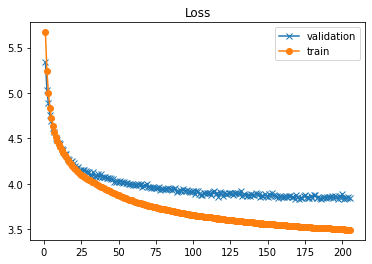

smallest val loss: (168, 3.8280394)
Current Lr:  0.0001290902

Time taken for this epoch: 23.57 secs

Epoch 206 Batch 0 Loss 3.2722
Epoch 206 Batch 150 Loss 3.4272
Epoch 206 Batch 300 Loss 3.4478
Epoch 206 Batch 450 Loss 3.4578
Epoch 206 Batch 600 Loss 3.4714
Epoch 206 Batch 750 Loss 3.4885
validation started ...

* Validation loss: 3.840423583984375 

* Train Loss 3.4911


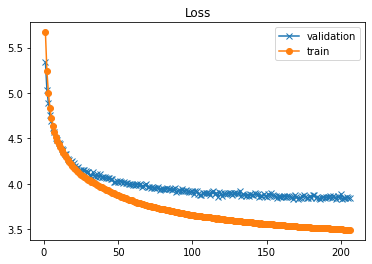

smallest val loss: (168, 3.8280394)
Current Lr:  0.00012781365

Time taken for this epoch: 23.58 secs

Epoch 207 Batch 0 Loss 3.3638
Epoch 207 Batch 150 Loss 3.4338
Epoch 207 Batch 300 Loss 3.4526
Epoch 207 Batch 450 Loss 3.4643
Epoch 207 Batch 600 Loss 3.4768
Epoch 207 Batch 750 Loss 3.4912
validation started ...

* Validation loss: 3.840888023376465 

* Train Loss 3.4929


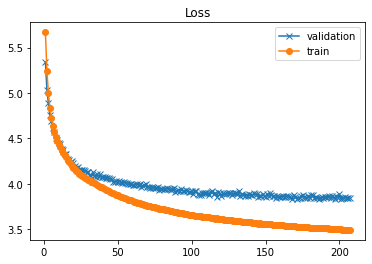

smallest val loss: (168, 3.8280394)
Current Lr:  0.00012654971

Time taken for this epoch: 23.81 secs

Epoch 208 Batch 0 Loss 3.4483
Epoch 208 Batch 150 Loss 3.4346
Epoch 208 Batch 300 Loss 3.4560
Epoch 208 Batch 450 Loss 3.4674
Epoch 208 Batch 600 Loss 3.4769
Epoch 208 Batch 750 Loss 3.4859
validation started ...

* Validation loss: 3.8401718139648438 

* Train Loss 3.4890


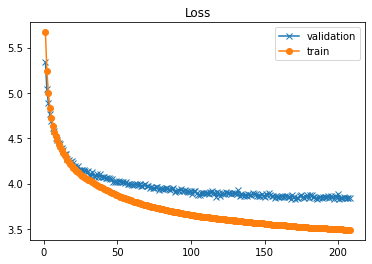

smallest val loss: (168, 3.8280394)
Current Lr:  0.00012529823

Time taken for this epoch: 23.51 secs

Epoch 209 Batch 0 Loss 3.4945
Epoch 209 Batch 150 Loss 3.4319
Epoch 209 Batch 300 Loss 3.4550
Epoch 209 Batch 450 Loss 3.4659
Epoch 209 Batch 600 Loss 3.4755
Epoch 209 Batch 750 Loss 3.4856
validation started ...

* Validation loss: 3.84187912940979 

* Train Loss 3.4862


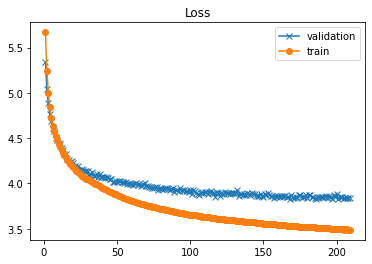

smallest val loss: (168, 3.8280394)
Current Lr:  0.0001240592

Time taken for this epoch: 23.48 secs

Epoch 210 Batch 0 Loss 3.2643
Epoch 210 Batch 150 Loss 3.4374
Epoch 210 Batch 300 Loss 3.4517
Epoch 210 Batch 450 Loss 3.4597
Epoch 210 Batch 600 Loss 3.4737
Epoch 210 Batch 750 Loss 3.4856
validation started ...

* Validation loss: 3.8434195518493652 

* Train Loss 3.4865


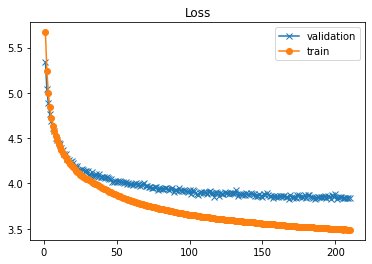

smallest val loss: (168, 3.8280394)
Current Lr:  0.0001228324

Time taken for this epoch: 23.65 secs

Epoch 211 Batch 0 Loss 3.1491
Epoch 211 Batch 150 Loss 3.4273
Epoch 211 Batch 300 Loss 3.4468
Epoch 211 Batch 450 Loss 3.4604
Epoch 211 Batch 600 Loss 3.4690
Epoch 211 Batch 750 Loss 3.4833
validation started ...

* Validation loss: 3.831303358078003 

* Train Loss 3.4861


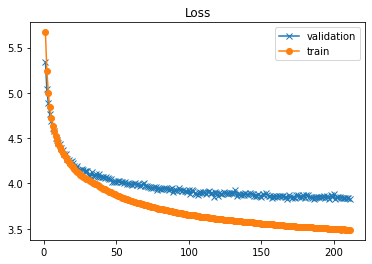

smallest val loss: (168, 3.8280394)
Current Lr:  0.00012161772

Time taken for this epoch: 23.43 secs

Epoch 212 Batch 0 Loss 3.4142
Epoch 212 Batch 150 Loss 3.4295
Epoch 212 Batch 300 Loss 3.4663
Epoch 212 Batch 450 Loss 3.4652
Epoch 212 Batch 600 Loss 3.4747
Epoch 212 Batch 750 Loss 3.4838
validation started ...

* Validation loss: 3.828249454498291 

* Train Loss 3.4871


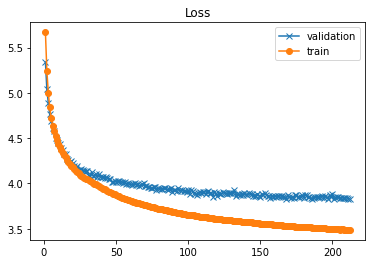

smallest val loss: (168, 3.8280394)
Current Lr:  0.000120415076

Time taken for this epoch: 23.51 secs

Epoch 213 Batch 0 Loss 3.4771
Epoch 213 Batch 150 Loss 3.4383
Epoch 213 Batch 300 Loss 3.4448
Epoch 213 Batch 450 Loss 3.4588
Epoch 213 Batch 600 Loss 3.4705
Epoch 213 Batch 750 Loss 3.4842
validation started ...

* Validation loss: 3.851700782775879 

* Train Loss 3.4854


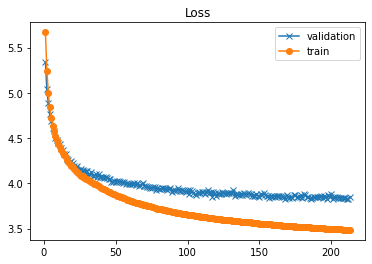

smallest val loss: (168, 3.8280394)
Current Lr:  0.000119224285

Time taken for this epoch: 23.71 secs

Epoch 214 Batch 0 Loss 3.4998
Epoch 214 Batch 150 Loss 3.4351
Epoch 214 Batch 300 Loss 3.4584
Epoch 214 Batch 450 Loss 3.4677
Epoch 214 Batch 600 Loss 3.4750
Epoch 214 Batch 750 Loss 3.4854
validation started ...

* Validation loss: 3.8391237258911133 

* Train Loss 3.4861


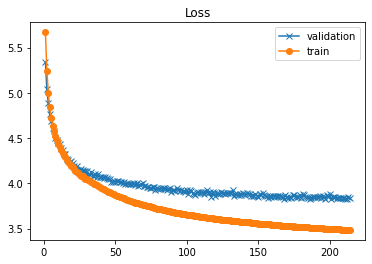

smallest val loss: (168, 3.8280394)
Current Lr:  0.00011804531

Time taken for this epoch: 23.57 secs

Epoch 215 Batch 0 Loss 3.3521
Epoch 215 Batch 150 Loss 3.4276
Epoch 215 Batch 300 Loss 3.4439
Epoch 215 Batch 450 Loss 3.4542
Epoch 215 Batch 600 Loss 3.4698
Epoch 215 Batch 750 Loss 3.4829
validation started ...

* Validation loss: 3.8451039791107178 

* Train Loss 3.4859


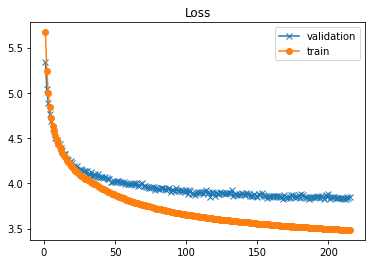

smallest val loss: (168, 3.8280394)
Current Lr:  0.00011687798

Time taken for this epoch: 23.58 secs

Epoch 216 Batch 0 Loss 3.6921
Epoch 216 Batch 150 Loss 3.4247
Epoch 216 Batch 300 Loss 3.4357
Epoch 216 Batch 450 Loss 3.4549
Epoch 216 Batch 600 Loss 3.4696
Epoch 216 Batch 750 Loss 3.4794
validation started ...

* Validation loss: 3.838369607925415 

* Train Loss 3.4812


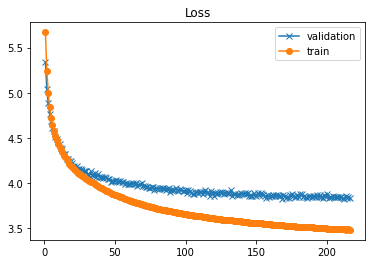

smallest val loss: (168, 3.8280394)
Current Lr:  0.000115722185

Time taken for this epoch: 23.53 secs

Epoch 217 Batch 0 Loss 3.6103
Epoch 217 Batch 150 Loss 3.4420
Epoch 217 Batch 300 Loss 3.4524
Epoch 217 Batch 450 Loss 3.4618
Epoch 217 Batch 600 Loss 3.4732
Epoch 217 Batch 750 Loss 3.4806
validation started ...

* Validation loss: 3.8339834213256836 

* Train Loss 3.4835


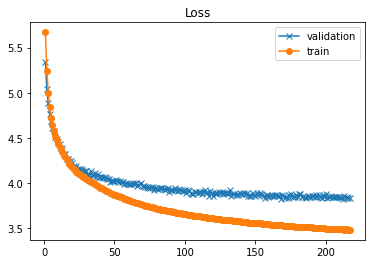

smallest val loss: (168, 3.8280394)
Current Lr:  0.00011457784

Time taken for this epoch: 23.87 secs

Epoch 218 Batch 0 Loss 3.3460
Epoch 218 Batch 150 Loss 3.4311
Epoch 218 Batch 300 Loss 3.4559
Epoch 218 Batch 450 Loss 3.4616
Epoch 218 Batch 600 Loss 3.4659
Epoch 218 Batch 750 Loss 3.4782
validation started ...

* Validation loss: 3.847323417663574 

* Train Loss 3.4806


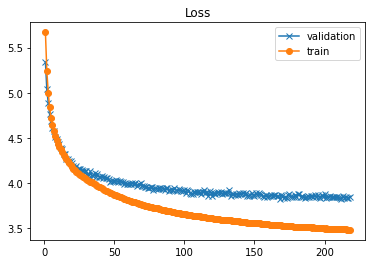

smallest val loss: (168, 3.8280394)
Current Lr:  0.00011344478

Time taken for this epoch: 23.64 secs

Epoch 219 Batch 0 Loss 3.7159
Epoch 219 Batch 150 Loss 3.4462
Epoch 219 Batch 300 Loss 3.4561
Epoch 219 Batch 450 Loss 3.4657
Epoch 219 Batch 600 Loss 3.4714
Epoch 219 Batch 750 Loss 3.4791
validation started ...

* Validation loss: 3.8738045692443848 

* Train Loss 3.4805


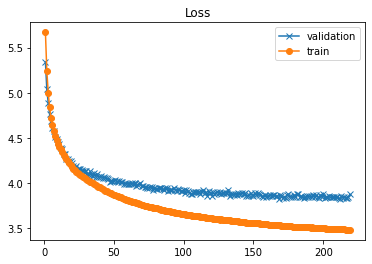

smallest val loss: (168, 3.8280394)
Current Lr:  0.000112322945

Time taken for this epoch: 23.48 secs

Epoch 220 Batch 0 Loss 3.5671
Epoch 220 Batch 150 Loss 3.4329
Epoch 220 Batch 300 Loss 3.4525
Epoch 220 Batch 450 Loss 3.4598
Epoch 220 Batch 600 Loss 3.4667
Epoch 220 Batch 750 Loss 3.4776
validation started ...

* Validation loss: 3.857722282409668 

* Train Loss 3.4803


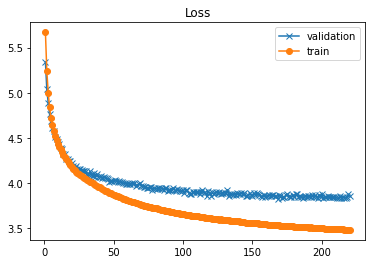

smallest val loss: (168, 3.8280394)
Current Lr:  0.000111212205

Time taken for this epoch: 23.63 secs

Epoch 221 Batch 0 Loss 3.3580
Epoch 221 Batch 150 Loss 3.4305
Epoch 221 Batch 300 Loss 3.4461
Epoch 221 Batch 450 Loss 3.4554
Epoch 221 Batch 600 Loss 3.4661
Epoch 221 Batch 750 Loss 3.4751
validation started ...

* Validation loss: 3.8313653469085693 

* Train Loss 3.4791


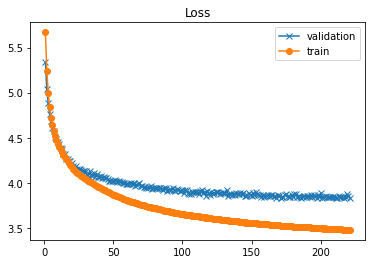

smallest val loss: (168, 3.8280394)
Current Lr:  0.00011011242

Time taken for this epoch: 23.66 secs

Epoch 222 Batch 0 Loss 3.4855
Epoch 222 Batch 150 Loss 3.4318
Epoch 222 Batch 300 Loss 3.4492
Epoch 222 Batch 450 Loss 3.4580
Epoch 222 Batch 600 Loss 3.4659
Epoch 222 Batch 750 Loss 3.4770
validation started ...

* Validation loss: 3.824882745742798 

* Train Loss 3.4796


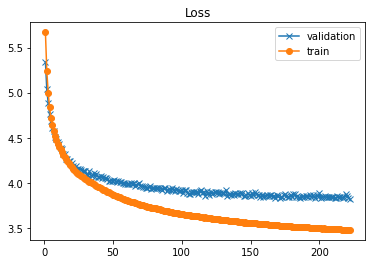

smallest val loss: (222, 3.8248827)
Current Lr:  0.00010902354

Time taken for this epoch: 23.54 secs

Epoch 223 Batch 0 Loss 3.3804
Epoch 223 Batch 150 Loss 3.4516
Epoch 223 Batch 300 Loss 3.4477
Epoch 223 Batch 450 Loss 3.4603
Epoch 223 Batch 600 Loss 3.4631
Epoch 223 Batch 750 Loss 3.4772
validation started ...

* Validation loss: 3.8455452919006348 

* Train Loss 3.4783


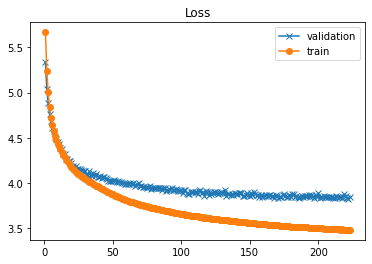

smallest val loss: (222, 3.8248827)
Current Lr:  0.00010794542

Time taken for this epoch: 23.47 secs

Epoch 224 Batch 0 Loss 3.1141
Epoch 224 Batch 150 Loss 3.4063
Epoch 224 Batch 300 Loss 3.4382
Epoch 224 Batch 450 Loss 3.4545
Epoch 224 Batch 600 Loss 3.4629
Epoch 224 Batch 750 Loss 3.4765
validation started ...

* Validation loss: 3.842632293701172 

* Train Loss 3.4783


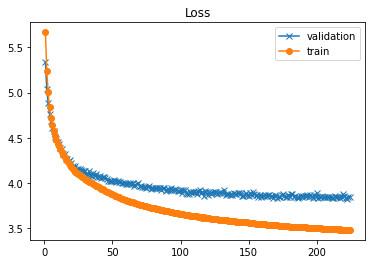

smallest val loss: (222, 3.8248827)
Current Lr:  0.00010687797

Time taken for this epoch: 23.48 secs

Epoch 225 Batch 0 Loss 3.3802
Epoch 225 Batch 150 Loss 3.4291
Epoch 225 Batch 300 Loss 3.4417
Epoch 225 Batch 450 Loss 3.4587
Epoch 225 Batch 600 Loss 3.4634
Epoch 225 Batch 750 Loss 3.4741
validation started ...

* Validation loss: 3.8258490562438965 

* Train Loss 3.4771


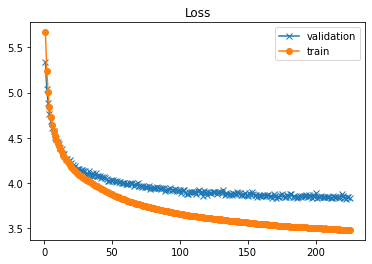

smallest val loss: (222, 3.8248827)
Current Lr:  0.00010582108

Time taken for this epoch: 23.44 secs

Epoch 226 Batch 0 Loss 3.3867
Epoch 226 Batch 150 Loss 3.4516
Epoch 226 Batch 300 Loss 3.4500
Epoch 226 Batch 450 Loss 3.4548
Epoch 226 Batch 600 Loss 3.4638
Epoch 226 Batch 750 Loss 3.4744
validation started ...

* Validation loss: 3.845781087875366 

* Train Loss 3.4769


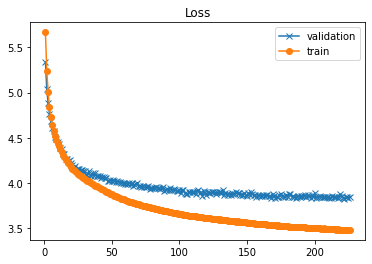

smallest val loss: (222, 3.8248827)
Current Lr:  0.00010477462

Time taken for this epoch: 23.62 secs

Epoch 227 Batch 0 Loss 3.4613
Epoch 227 Batch 150 Loss 3.4419
Epoch 227 Batch 300 Loss 3.4447
Epoch 227 Batch 450 Loss 3.4543
Epoch 227 Batch 600 Loss 3.4607
Epoch 227 Batch 750 Loss 3.4721
validation started ...

* Validation loss: 3.856844425201416 

* Train Loss 3.4751


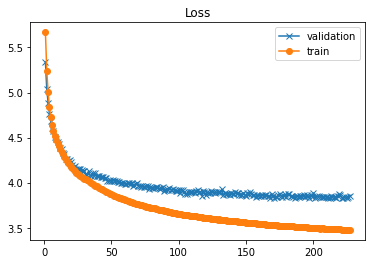

smallest val loss: (222, 3.8248827)
Current Lr:  0.00010373853

Time taken for this epoch: 23.88 secs

Epoch 228 Batch 0 Loss 3.2299
Epoch 228 Batch 150 Loss 3.4192
Epoch 228 Batch 300 Loss 3.4398
Epoch 228 Batch 450 Loss 3.4499
Epoch 228 Batch 600 Loss 3.4597
Epoch 228 Batch 750 Loss 3.4731
validation started ...

* Validation loss: 3.8416860103607178 

* Train Loss 3.4740


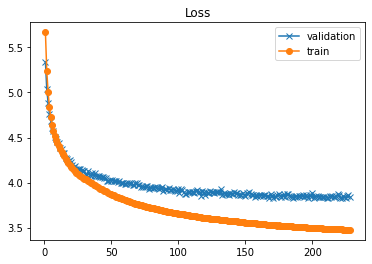

smallest val loss: (222, 3.8248827)
Current Lr:  0.00010271266

Time taken for this epoch: 23.79 secs

Epoch 229 Batch 0 Loss 3.3687
Epoch 229 Batch 150 Loss 3.4316
Epoch 229 Batch 300 Loss 3.4465
Epoch 229 Batch 450 Loss 3.4536
Epoch 229 Batch 600 Loss 3.4598
Epoch 229 Batch 750 Loss 3.4706
validation started ...

* Validation loss: 3.8384249210357666 

* Train Loss 3.4732


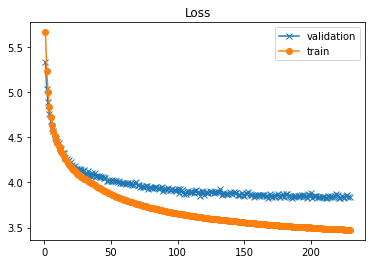

smallest val loss: (222, 3.8248827)
Current Lr:  0.000101696955

Time taken for this epoch: 23.57 secs

Epoch 230 Batch 0 Loss 3.4057
Epoch 230 Batch 150 Loss 3.4380
Epoch 230 Batch 300 Loss 3.4474
Epoch 230 Batch 450 Loss 3.4561
Epoch 230 Batch 600 Loss 3.4633
Epoch 230 Batch 750 Loss 3.4724
validation started ...

* Validation loss: 3.8407442569732666 

* Train Loss 3.4741


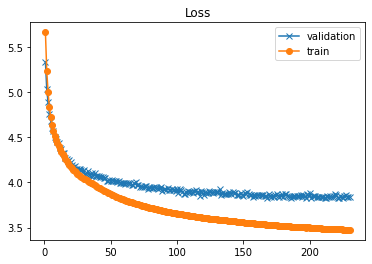

smallest val loss: (222, 3.8248827)
Current Lr:  0.0001006913

Time taken for this epoch: 23.68 secs

Epoch 231 Batch 0 Loss 3.2400
Epoch 231 Batch 150 Loss 3.4124
Epoch 231 Batch 300 Loss 3.4310
Epoch 231 Batch 450 Loss 3.4443
Epoch 231 Batch 600 Loss 3.4590
Epoch 231 Batch 750 Loss 3.4683
validation started ...

* Validation loss: 3.827901601791382 

* Train Loss 3.4721


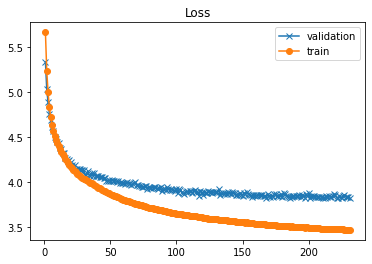

smallest val loss: (222, 3.8248827)
Current Lr:  9.969557e-05

Time taken for this epoch: 23.63 secs

Epoch 232 Batch 0 Loss 3.4173
Epoch 232 Batch 150 Loss 3.4340
Epoch 232 Batch 300 Loss 3.4498
Epoch 232 Batch 450 Loss 3.4536
Epoch 232 Batch 600 Loss 3.4598
Epoch 232 Batch 750 Loss 3.4704
validation started ...

* Validation loss: 3.8428919315338135 

* Train Loss 3.4721


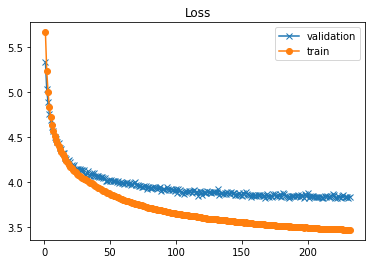

smallest val loss: (222, 3.8248827)
Current Lr:  9.87097e-05

Time taken for this epoch: 23.53 secs

Epoch 233 Batch 0 Loss 3.2769
Epoch 233 Batch 150 Loss 3.4258
Epoch 233 Batch 300 Loss 3.4343
Epoch 233 Batch 450 Loss 3.4504
Epoch 233 Batch 600 Loss 3.4589
Epoch 233 Batch 750 Loss 3.4680
validation started ...

* Validation loss: 3.842719078063965 

* Train Loss 3.4698


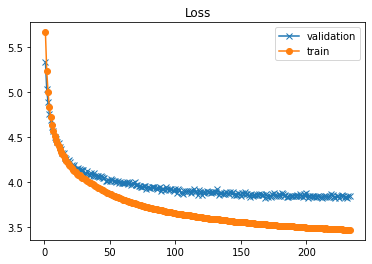

smallest val loss: (222, 3.8248827)
Current Lr:  9.7733544e-05

Time taken for this epoch: 23.65 secs

Epoch 234 Batch 0 Loss 3.1225
Epoch 234 Batch 150 Loss 3.4219
Epoch 234 Batch 300 Loss 3.4310
Epoch 234 Batch 450 Loss 3.4447
Epoch 234 Batch 600 Loss 3.4568
Epoch 234 Batch 750 Loss 3.4685
validation started ...

* Validation loss: 3.8532068729400635 

* Train Loss 3.4696


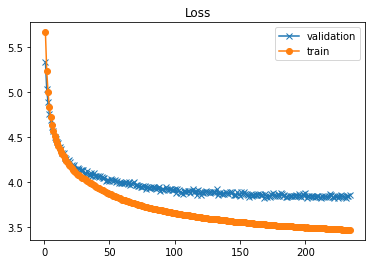

smallest val loss: (222, 3.8248827)
Current Lr:  9.676708e-05

Time taken for this epoch: 23.55 secs

Epoch 235 Batch 0 Loss 3.6105
Epoch 235 Batch 150 Loss 3.4366
Epoch 235 Batch 300 Loss 3.4432
Epoch 235 Batch 450 Loss 3.4557
Epoch 235 Batch 600 Loss 3.4554
Epoch 235 Batch 750 Loss 3.4666
validation started ...

* Validation loss: 3.8372983932495117 

* Train Loss 3.4683


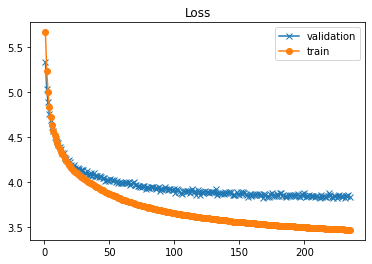

smallest val loss: (222, 3.8248827)
Current Lr:  9.581018e-05

Time taken for this epoch: 23.58 secs

Epoch 236 Batch 0 Loss 3.5661
Epoch 236 Batch 150 Loss 3.4226
Epoch 236 Batch 300 Loss 3.4281
Epoch 236 Batch 450 Loss 3.4469
Epoch 236 Batch 600 Loss 3.4519
Epoch 236 Batch 750 Loss 3.4662
validation started ...

* Validation loss: 3.850046396255493 

* Train Loss 3.4678


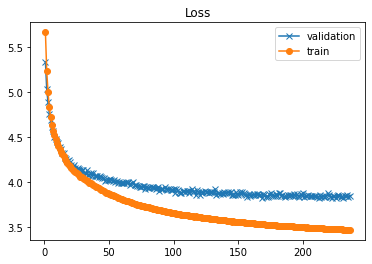

smallest val loss: (222, 3.8248827)
Current Lr:  9.486271e-05

Time taken for this epoch: 23.55 secs

Epoch 237 Batch 0 Loss 3.5667
Epoch 237 Batch 150 Loss 3.4455
Epoch 237 Batch 300 Loss 3.4460
Epoch 237 Batch 450 Loss 3.4471
Epoch 237 Batch 600 Loss 3.4584
Epoch 237 Batch 750 Loss 3.4670
validation started ...

* Validation loss: 3.852130889892578 

* Train Loss 3.4673


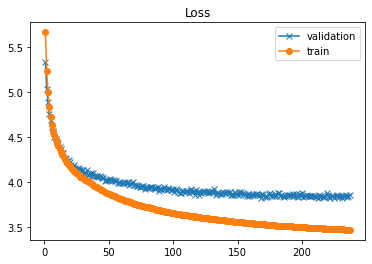

smallest val loss: (222, 3.8248827)
Current Lr:  9.392464e-05

Time taken for this epoch: 23.52 secs

Epoch 238 Batch 0 Loss 3.5214
Epoch 238 Batch 150 Loss 3.4312
Epoch 238 Batch 300 Loss 3.4378
Epoch 238 Batch 450 Loss 3.4432
Epoch 238 Batch 600 Loss 3.4522
Epoch 238 Batch 750 Loss 3.4642
validation started ...

* Validation loss: 3.848127841949463 

* Train Loss 3.4651


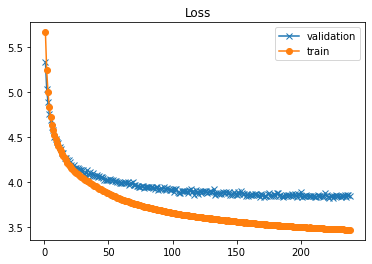

smallest val loss: (222, 3.8248827)
Current Lr:  9.299582e-05

Time taken for this epoch: 23.58 secs

Epoch 239 Batch 0 Loss 3.4869
Epoch 239 Batch 150 Loss 3.4467
Epoch 239 Batch 300 Loss 3.4447
Epoch 239 Batch 450 Loss 3.4507
Epoch 239 Batch 600 Loss 3.4575
Epoch 239 Batch 750 Loss 3.4676
validation started ...

* Validation loss: 3.8355278968811035 

* Train Loss 3.4673


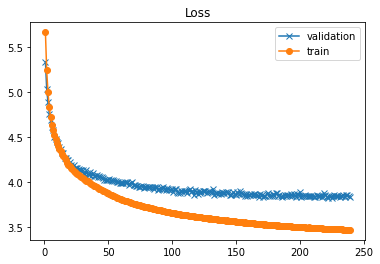

smallest val loss: (222, 3.8248827)
Current Lr:  9.207621e-05

Time taken for this epoch: 23.51 secs

Epoch 240 Batch 0 Loss 3.6758
Epoch 240 Batch 150 Loss 3.4429
Epoch 240 Batch 300 Loss 3.4461
Epoch 240 Batch 450 Loss 3.4472
Epoch 240 Batch 600 Loss 3.4529
Epoch 240 Batch 750 Loss 3.4627
validation started ...

* Validation loss: 3.853832483291626 

* Train Loss 3.4640


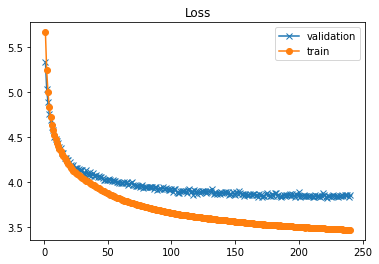

smallest val loss: (222, 3.8248827)
Current Lr:  9.116568e-05

Time taken for this epoch: 23.82 secs

Epoch 241 Batch 0 Loss 3.2175
Epoch 241 Batch 150 Loss 3.4246
Epoch 241 Batch 300 Loss 3.4446
Epoch 241 Batch 450 Loss 3.4448
Epoch 241 Batch 600 Loss 3.4552
Epoch 241 Batch 750 Loss 3.4648
validation started ...

* Validation loss: 3.839824676513672 

* Train Loss 3.4666


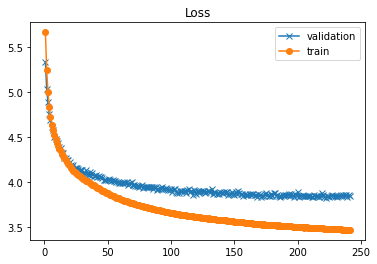

smallest val loss: (222, 3.8248827)
Current Lr:  9.026415e-05

Time taken for this epoch: 23.55 secs

Epoch 242 Batch 0 Loss 3.5745
Epoch 242 Batch 150 Loss 3.4232
Epoch 242 Batch 300 Loss 3.4422
Epoch 242 Batch 450 Loss 3.4546
Epoch 242 Batch 600 Loss 3.4550
Epoch 242 Batch 750 Loss 3.4620
validation started ...

* Validation loss: 3.8318898677825928 

* Train Loss 3.4647


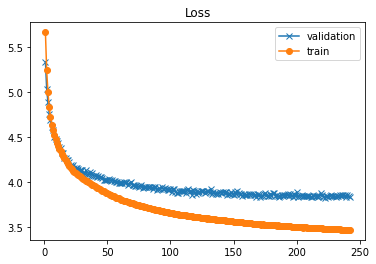

smallest val loss: (222, 3.8248827)
Current Lr:  8.937155e-05

Time taken for this epoch: 23.66 secs

Epoch 243 Batch 0 Loss 3.6568
Epoch 243 Batch 150 Loss 3.4208
Epoch 243 Batch 300 Loss 3.4439
Epoch 243 Batch 450 Loss 3.4527
Epoch 243 Batch 600 Loss 3.4574
Epoch 243 Batch 750 Loss 3.4625
validation started ...

* Validation loss: 3.84401535987854 

* Train Loss 3.4644


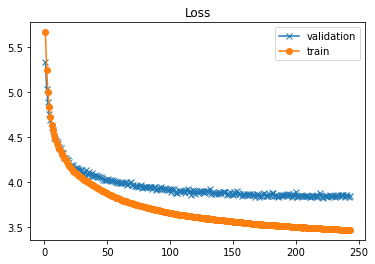

smallest val loss: (222, 3.8248827)
Current Lr:  8.848776e-05

Time taken for this epoch: 23.61 secs

Epoch 244 Batch 0 Loss 3.5208
Epoch 244 Batch 150 Loss 3.4189
Epoch 244 Batch 300 Loss 3.4410
Epoch 244 Batch 450 Loss 3.4475
Epoch 244 Batch 600 Loss 3.4509
Epoch 244 Batch 750 Loss 3.4614
validation started ...

* Validation loss: 3.851651906967163 

* Train Loss 3.4636


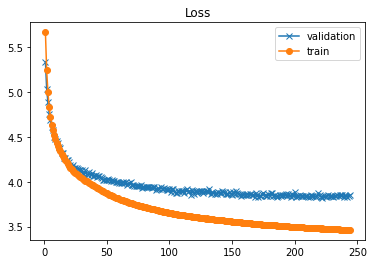

smallest val loss: (222, 3.8248827)
Current Lr:  8.761272e-05

Time taken for this epoch: 23.56 secs

Epoch 245 Batch 0 Loss 3.4630
Epoch 245 Batch 150 Loss 3.4114
Epoch 245 Batch 300 Loss 3.4300
Epoch 245 Batch 450 Loss 3.4437
Epoch 245 Batch 600 Loss 3.4503
Epoch 245 Batch 750 Loss 3.4595
validation started ...

* Validation loss: 3.853159189224243 

* Train Loss 3.4613


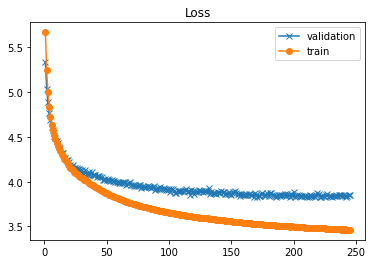

smallest val loss: (222, 3.8248827)
Current Lr:  8.674633e-05

Time taken for this epoch: 23.57 secs

Epoch 246 Batch 0 Loss 3.3447
Epoch 246 Batch 150 Loss 3.4031
Epoch 246 Batch 300 Loss 3.4332
Epoch 246 Batch 450 Loss 3.4422
Epoch 246 Batch 600 Loss 3.4524
Epoch 246 Batch 750 Loss 3.4632
validation started ...

* Validation loss: 3.8483057022094727 

* Train Loss 3.4636


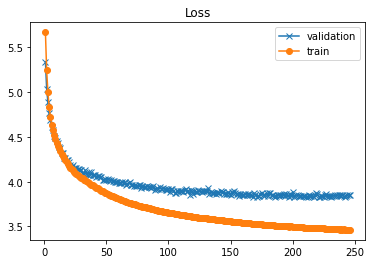

smallest val loss: (222, 3.8248827)
Current Lr:  8.588849e-05

Time taken for this epoch: 23.55 secs

Epoch 247 Batch 0 Loss 3.2581
Epoch 247 Batch 150 Loss 3.4106
Epoch 247 Batch 300 Loss 3.4324
Epoch 247 Batch 450 Loss 3.4422
Epoch 247 Batch 600 Loss 3.4492
Epoch 247 Batch 750 Loss 3.4594
validation started ...

* Validation loss: 3.855980634689331 

* Train Loss 3.4622


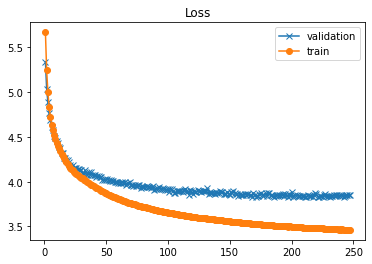

smallest val loss: (222, 3.8248827)
Current Lr:  8.503916e-05

Time taken for this epoch: 23.63 secs

Epoch 248 Batch 0 Loss 3.3963
Epoch 248 Batch 150 Loss 3.4093
Epoch 248 Batch 300 Loss 3.4311
Epoch 248 Batch 450 Loss 3.4367
Epoch 248 Batch 600 Loss 3.4458
Epoch 248 Batch 750 Loss 3.4592
validation started ...

* Validation loss: 3.860835075378418 

* Train Loss 3.4607


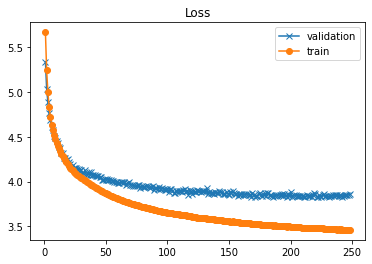

smallest val loss: (222, 3.8248827)
Current Lr:  8.4198226e-05

Time taken for this epoch: 23.56 secs

Epoch 249 Batch 0 Loss 3.3865
Epoch 249 Batch 150 Loss 3.4215
Epoch 249 Batch 300 Loss 3.4339
Epoch 249 Batch 450 Loss 3.4411
Epoch 249 Batch 600 Loss 3.4478
Epoch 249 Batch 750 Loss 3.4583
validation started ...

* Validation loss: 3.823251485824585 

* Train Loss 3.4586


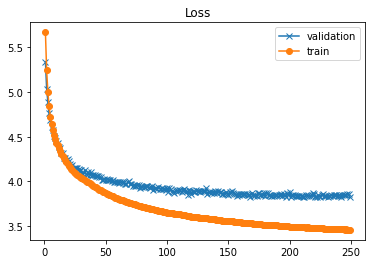

smallest val loss: (249, 3.8232515)
Current Lr:  8.33656e-05

Time taken for this epoch: 23.61 secs

Epoch 250 Batch 0 Loss 3.0673
Epoch 250 Batch 150 Loss 3.4134
Epoch 250 Batch 300 Loss 3.4343
Epoch 250 Batch 450 Loss 3.4401
Epoch 250 Batch 600 Loss 3.4516
Epoch 250 Batch 750 Loss 3.4577
validation started ...

* Validation loss: 3.823636770248413 

* Train Loss 3.4602


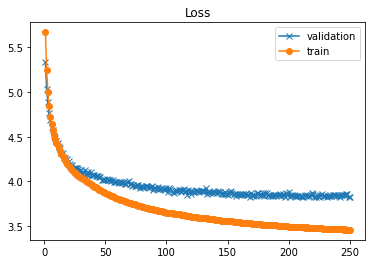

smallest val loss: (249, 3.8232515)
Current Lr:  8.254121e-05

Time taken for this epoch: 23.53 secs

Epoch 251 Batch 0 Loss 3.2824
Epoch 251 Batch 150 Loss 3.4128
Epoch 251 Batch 300 Loss 3.4351
Epoch 251 Batch 450 Loss 3.4432
Epoch 251 Batch 600 Loss 3.4515
Epoch 251 Batch 750 Loss 3.4591
validation started ...

* Validation loss: 3.8424341678619385 

* Train Loss 3.4596


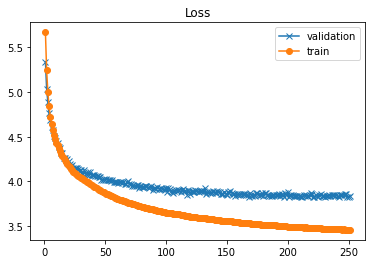

smallest val loss: (249, 3.8232515)
Current Lr:  8.1724975e-05

Time taken for this epoch: 23.45 secs

Epoch 252 Batch 0 Loss 3.2007
Epoch 252 Batch 150 Loss 3.4232
Epoch 252 Batch 300 Loss 3.4351
Epoch 252 Batch 450 Loss 3.4406
Epoch 252 Batch 600 Loss 3.4477
Epoch 252 Batch 750 Loss 3.4566
validation started ...

* Validation loss: 3.819499969482422 

* Train Loss 3.4570


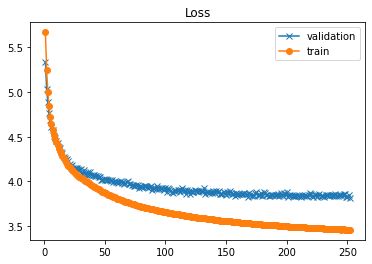

smallest val loss: (252, 3.8195)
Current Lr:  8.091681e-05

Time taken for this epoch: 23.61 secs

Epoch 253 Batch 0 Loss 3.3080
Epoch 253 Batch 150 Loss 3.4169
Epoch 253 Batch 300 Loss 3.4285
Epoch 253 Batch 450 Loss 3.4430
Epoch 253 Batch 600 Loss 3.4454
Epoch 253 Batch 750 Loss 3.4549
validation started ...

* Validation loss: 3.827523708343506 

* Train Loss 3.4588


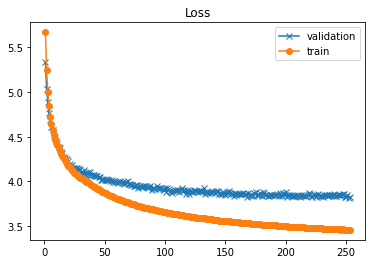

smallest val loss: (252, 3.8195)
Current Lr:  8.0116624e-05

Time taken for this epoch: 23.52 secs

Epoch 254 Batch 0 Loss 3.2823
Epoch 254 Batch 150 Loss 3.4070
Epoch 254 Batch 300 Loss 3.4275
Epoch 254 Batch 450 Loss 3.4356
Epoch 254 Batch 600 Loss 3.4473
Epoch 254 Batch 750 Loss 3.4555
validation started ...

* Validation loss: 3.8374578952789307 

* Train Loss 3.4575


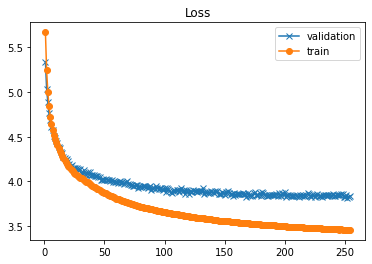

smallest val loss: (252, 3.8195)
Current Lr:  7.9324374e-05

Time taken for this epoch: 23.50 secs

Epoch 255 Batch 0 Loss 3.3423
Epoch 255 Batch 150 Loss 3.4167
Epoch 255 Batch 300 Loss 3.4250
Epoch 255 Batch 450 Loss 3.4358
Epoch 255 Batch 600 Loss 3.4433
Epoch 255 Batch 750 Loss 3.4536
validation started ...

* Validation loss: 3.813694715499878 

* Train Loss 3.4563


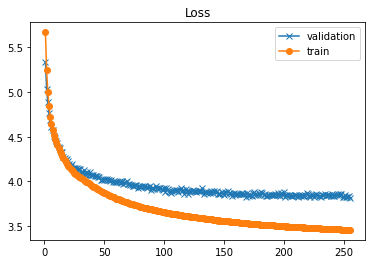

smallest val loss: (255, 3.8136947)
Current Lr:  7.853995e-05

Time taken for this epoch: 23.59 secs

Epoch 256 Batch 0 Loss 3.4593
Epoch 256 Batch 150 Loss 3.4233
Epoch 256 Batch 300 Loss 3.4260
Epoch 256 Batch 450 Loss 3.4311
Epoch 256 Batch 600 Loss 3.4382
Epoch 256 Batch 750 Loss 3.4513
validation started ...

* Validation loss: 3.85261607170105 

* Train Loss 3.4528


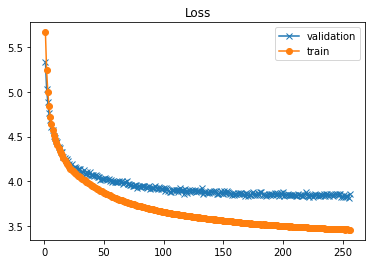

smallest val loss: (255, 3.8136947)
Current Lr:  7.7763274e-05

Time taken for this epoch: 27.99 secs

Epoch 257 Batch 0 Loss 3.3886
Epoch 257 Batch 150 Loss 3.4114
Epoch 257 Batch 300 Loss 3.4290
Epoch 257 Batch 450 Loss 3.4399
Epoch 257 Batch 600 Loss 3.4467
Epoch 257 Batch 750 Loss 3.4528
validation started ...

* Validation loss: 3.838280439376831 

* Train Loss 3.4537


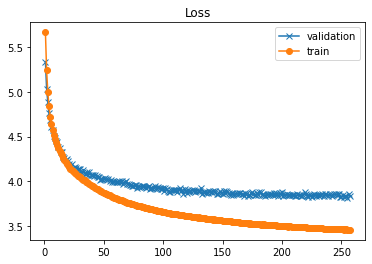

smallest val loss: (255, 3.8136947)
Current Lr:  7.699428e-05

Time taken for this epoch: 23.45 secs

Epoch 258 Batch 0 Loss 3.6482
Epoch 258 Batch 150 Loss 3.4275
Epoch 258 Batch 300 Loss 3.4362
Epoch 258 Batch 450 Loss 3.4379
Epoch 258 Batch 600 Loss 3.4449
Epoch 258 Batch 750 Loss 3.4515
validation started ...

* Validation loss: 3.841766357421875 

* Train Loss 3.4536


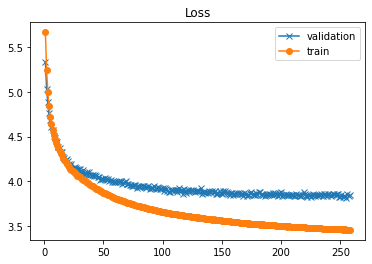

smallest val loss: (255, 3.8136947)
Current Lr:  7.6232885e-05

Time taken for this epoch: 23.53 secs

Epoch 259 Batch 0 Loss 3.5048
Epoch 259 Batch 150 Loss 3.4019
Epoch 259 Batch 300 Loss 3.4193
Epoch 259 Batch 450 Loss 3.4309
Epoch 259 Batch 600 Loss 3.4382
Epoch 259 Batch 750 Loss 3.4506
validation started ...

* Validation loss: 3.8357889652252197 

* Train Loss 3.4535


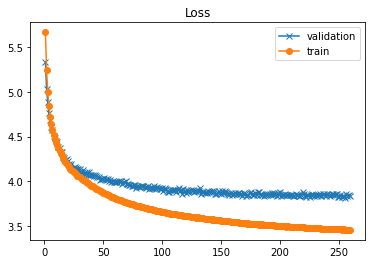

smallest val loss: (255, 3.8136947)
Current Lr:  7.547902e-05

Time taken for this epoch: 23.59 secs

Epoch 260 Batch 0 Loss 3.3961
Epoch 260 Batch 150 Loss 3.4299
Epoch 260 Batch 300 Loss 3.4335
Epoch 260 Batch 450 Loss 3.4374
Epoch 260 Batch 600 Loss 3.4467
Epoch 260 Batch 750 Loss 3.4538
validation started ...

* Validation loss: 3.8604934215545654 

* Train Loss 3.4545


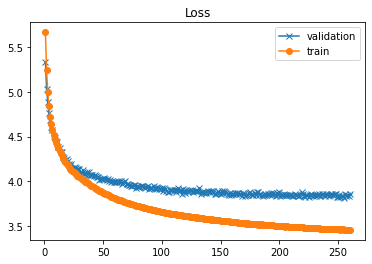

smallest val loss: (255, 3.8136947)
Current Lr:  7.473263e-05

Time taken for this epoch: 23.59 secs

Epoch 261 Batch 0 Loss 3.3263
Epoch 261 Batch 150 Loss 3.4172
Epoch 261 Batch 300 Loss 3.4251
Epoch 261 Batch 450 Loss 3.4300
Epoch 261 Batch 600 Loss 3.4374
Epoch 261 Batch 750 Loss 3.4525
validation started ...

* Validation loss: 3.806288719177246 

* Train Loss 3.4538


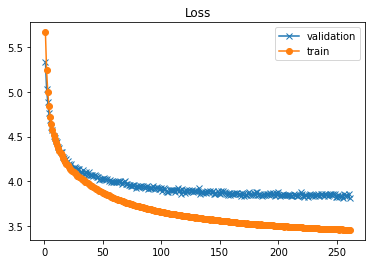

smallest val loss: (261, 3.8062887)
Current Lr:  7.3993615e-05

Time taken for this epoch: 23.44 secs

Epoch 262 Batch 0 Loss 3.4693
Epoch 262 Batch 150 Loss 3.4107
Epoch 262 Batch 300 Loss 3.4198
Epoch 262 Batch 450 Loss 3.4359
Epoch 262 Batch 600 Loss 3.4436
Epoch 262 Batch 750 Loss 3.4521
validation started ...

* Validation loss: 3.8110909461975098 

* Train Loss 3.4532


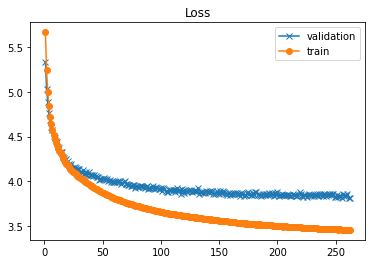

smallest val loss: (261, 3.8062887)
Current Lr:  7.326191e-05

Time taken for this epoch: 23.53 secs

Epoch 263 Batch 0 Loss 3.1283
Epoch 263 Batch 150 Loss 3.4160
Epoch 263 Batch 300 Loss 3.4289
Epoch 263 Batch 450 Loss 3.4359
Epoch 263 Batch 600 Loss 3.4421
Epoch 263 Batch 750 Loss 3.4494
validation started ...

* Validation loss: 3.8607583045959473 

* Train Loss 3.4504


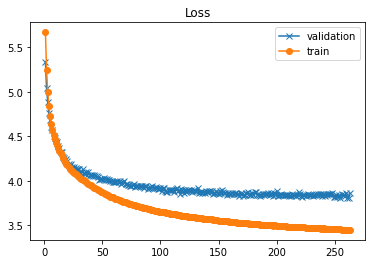

smallest val loss: (261, 3.8062887)
Current Lr:  7.253743e-05

Time taken for this epoch: 23.52 secs

Epoch 264 Batch 0 Loss 3.5943
Epoch 264 Batch 150 Loss 3.4187
Epoch 264 Batch 300 Loss 3.4287
Epoch 264 Batch 450 Loss 3.4326
Epoch 264 Batch 600 Loss 3.4429
Epoch 264 Batch 750 Loss 3.4480
validation started ...

* Validation loss: 3.827536106109619 

* Train Loss 3.4487


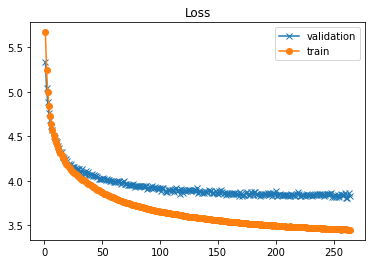

smallest val loss: (261, 3.8062887)
Current Lr:  7.182012e-05

Time taken for this epoch: 23.51 secs

Epoch 265 Batch 0 Loss 3.3173
Epoch 265 Batch 150 Loss 3.4188
Epoch 265 Batch 300 Loss 3.4291
Epoch 265 Batch 450 Loss 3.4376
Epoch 265 Batch 600 Loss 3.4436
Epoch 265 Batch 750 Loss 3.4488
validation started ...

* Validation loss: 3.851301670074463 

* Train Loss 3.4512


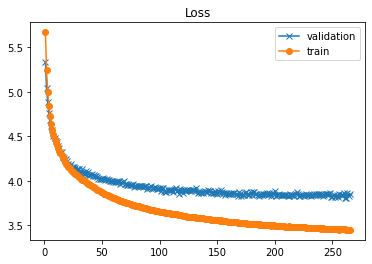

smallest val loss: (261, 3.8062887)
Current Lr:  7.11099e-05

Time taken for this epoch: 23.61 secs

Epoch 266 Batch 0 Loss 3.2499
Epoch 266 Batch 150 Loss 3.4054
Epoch 266 Batch 300 Loss 3.4187
Epoch 266 Batch 450 Loss 3.4313
Epoch 266 Batch 600 Loss 3.4434
Epoch 266 Batch 750 Loss 3.4492
validation started ...

* Validation loss: 3.8444833755493164 

* Train Loss 3.4508


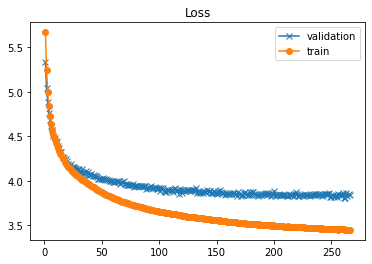

smallest val loss: (261, 3.8062887)
Current Lr:  7.04067e-05

Time taken for this epoch: 23.53 secs

Epoch 267 Batch 0 Loss 3.5792
Epoch 267 Batch 150 Loss 3.4287
Epoch 267 Batch 300 Loss 3.4311
Epoch 267 Batch 450 Loss 3.4329
Epoch 267 Batch 600 Loss 3.4416
Epoch 267 Batch 750 Loss 3.4474
validation started ...

* Validation loss: 3.8556923866271973 

* Train Loss 3.4489


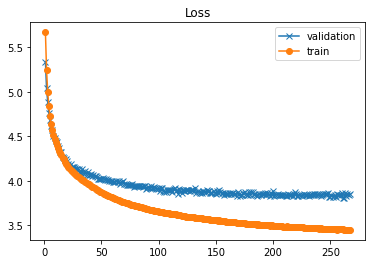

smallest val loss: (261, 3.8062887)
Current Lr:  6.971047e-05

Time taken for this epoch: 23.56 secs

Epoch 268 Batch 0 Loss 3.3675
Epoch 268 Batch 150 Loss 3.4103
Epoch 268 Batch 300 Loss 3.4229
Epoch 268 Batch 450 Loss 3.4385
Epoch 268 Batch 600 Loss 3.4428
Epoch 268 Batch 750 Loss 3.4475
validation started ...

* Validation loss: 3.835488796234131 

* Train Loss 3.4496


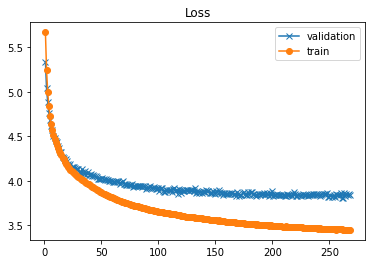

smallest val loss: (261, 3.8062887)
Current Lr:  6.90211e-05

Time taken for this epoch: 23.49 secs

Epoch 269 Batch 0 Loss 3.5040
Epoch 269 Batch 150 Loss 3.4022
Epoch 269 Batch 300 Loss 3.4118
Epoch 269 Batch 450 Loss 3.4336
Epoch 269 Batch 600 Loss 3.4412
Epoch 269 Batch 750 Loss 3.4500
validation started ...

* Validation loss: 3.8266396522521973 

* Train Loss 3.4498


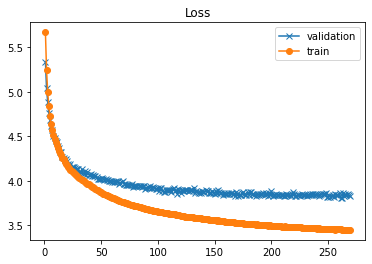

smallest val loss: (261, 3.8062887)
Current Lr:  6.833856e-05

Time taken for this epoch: 23.57 secs

Epoch 270 Batch 0 Loss 3.5355
Epoch 270 Batch 150 Loss 3.4058
Epoch 270 Batch 300 Loss 3.4353
Epoch 270 Batch 450 Loss 3.4435
Epoch 270 Batch 600 Loss 3.4470
Epoch 270 Batch 750 Loss 3.4486
validation started ...

* Validation loss: 3.8471779823303223 

* Train Loss 3.4498


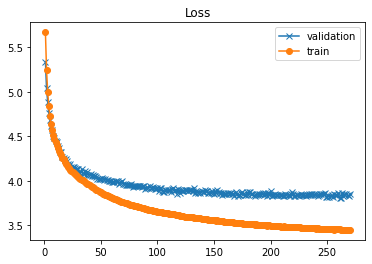

smallest val loss: (261, 3.8062887)
Current Lr:  6.766279e-05

Time taken for this epoch: 23.62 secs

Epoch 271 Batch 0 Loss 3.6673
Epoch 271 Batch 150 Loss 3.4193
Epoch 271 Batch 300 Loss 3.4249
Epoch 271 Batch 450 Loss 3.4321
Epoch 271 Batch 600 Loss 3.4396
Epoch 271 Batch 750 Loss 3.4457
validation started ...

* Validation loss: 3.839935302734375 

* Train Loss 3.4483


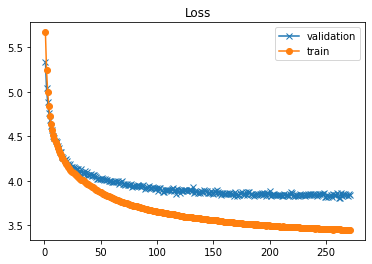

smallest val loss: (261, 3.8062887)
Current Lr:  6.699365e-05

Time taken for this epoch: 23.49 secs

Epoch 272 Batch 0 Loss 3.4811
Epoch 272 Batch 150 Loss 3.4147
Epoch 272 Batch 300 Loss 3.4268
Epoch 272 Batch 450 Loss 3.4338
Epoch 272 Batch 600 Loss 3.4401
Epoch 272 Batch 750 Loss 3.4493
validation started ...

* Validation loss: 3.8324713706970215 

* Train Loss 3.4501


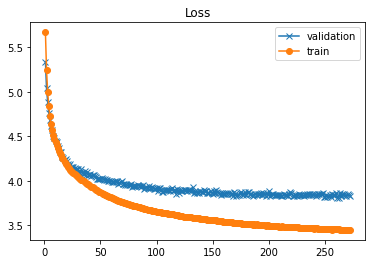

smallest val loss: (261, 3.8062887)
Current Lr:  6.6331166e-05

Time taken for this epoch: 23.55 secs

Epoch 273 Batch 0 Loss 3.3868
Epoch 273 Batch 150 Loss 3.4161
Epoch 273 Batch 300 Loss 3.4140
Epoch 273 Batch 450 Loss 3.4309
Epoch 273 Batch 600 Loss 3.4333
Epoch 273 Batch 750 Loss 3.4465
validation started ...

* Validation loss: 3.8450560569763184 

* Train Loss 3.4481


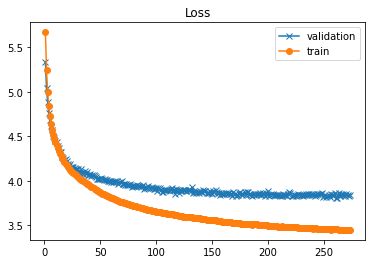

smallest val loss: (261, 3.8062887)
Current Lr:  6.567522e-05

Time taken for this epoch: 23.62 secs

Epoch 274 Batch 0 Loss 3.3972
Epoch 274 Batch 150 Loss 3.4086
Epoch 274 Batch 300 Loss 3.4288
Epoch 274 Batch 450 Loss 3.4294
Epoch 274 Batch 600 Loss 3.4346
Epoch 274 Batch 750 Loss 3.4444
validation started ...

* Validation loss: 3.823564052581787 

* Train Loss 3.4464


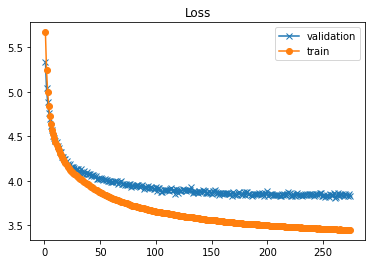

smallest val loss: (261, 3.8062887)
Current Lr:  6.502578e-05

Time taken for this epoch: 23.47 secs

Epoch 275 Batch 0 Loss 3.5364
Epoch 275 Batch 150 Loss 3.4180
Epoch 275 Batch 300 Loss 3.4257
Epoch 275 Batch 450 Loss 3.4288
Epoch 275 Batch 600 Loss 3.4379
Epoch 275 Batch 750 Loss 3.4461
validation started ...

* Validation loss: 3.8292999267578125 

* Train Loss 3.4487


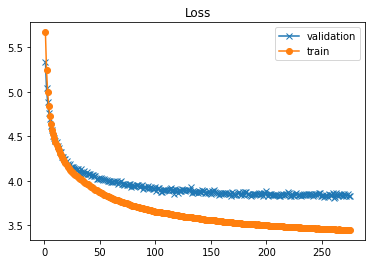

smallest val loss: (261, 3.8062887)
Current Lr:  6.438275e-05

Time taken for this epoch: 23.51 secs

Epoch 276 Batch 0 Loss 3.3823
Epoch 276 Batch 150 Loss 3.4209
Epoch 276 Batch 300 Loss 3.4164
Epoch 276 Batch 450 Loss 3.4264
Epoch 276 Batch 600 Loss 3.4406
Epoch 276 Batch 750 Loss 3.4471
validation started ...

* Validation loss: 3.8512022495269775 

* Train Loss 3.4475


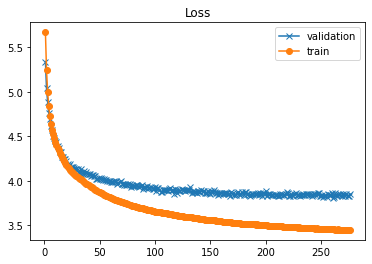

smallest val loss: (261, 3.8062887)
Current Lr:  6.374608e-05

Time taken for this epoch: 23.83 secs

Epoch 277 Batch 0 Loss 3.5027
Epoch 277 Batch 150 Loss 3.4096
Epoch 277 Batch 300 Loss 3.4191
Epoch 277 Batch 450 Loss 3.4271
Epoch 277 Batch 600 Loss 3.4295
Epoch 277 Batch 750 Loss 3.4444
validation started ...

* Validation loss: 3.822950601577759 

* Train Loss 3.4448


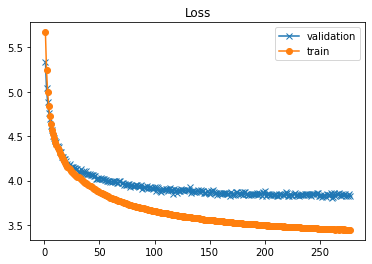

smallest val loss: (261, 3.8062887)
Current Lr:  6.311571e-05

Time taken for this epoch: 23.55 secs

Epoch 278 Batch 0 Loss 3.2726
Epoch 278 Batch 150 Loss 3.4272
Epoch 278 Batch 300 Loss 3.4236
Epoch 278 Batch 450 Loss 3.4301
Epoch 278 Batch 600 Loss 3.4388
Epoch 278 Batch 750 Loss 3.4437
validation started ...

* Validation loss: 3.818281412124634 

* Train Loss 3.4469


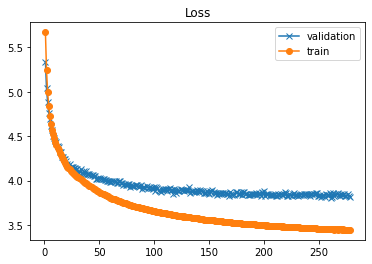

smallest val loss: (261, 3.8062887)
Current Lr:  6.2491556e-05

Time taken for this epoch: 23.43 secs

Epoch 279 Batch 0 Loss 3.2859
Epoch 279 Batch 150 Loss 3.4180
Epoch 279 Batch 300 Loss 3.4360
Epoch 279 Batch 450 Loss 3.4284
Epoch 279 Batch 600 Loss 3.4371
Epoch 279 Batch 750 Loss 3.4424
validation started ...

* Validation loss: 3.816899299621582 

* Train Loss 3.4449


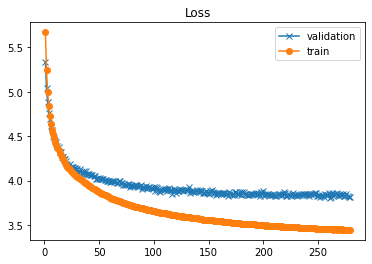

smallest val loss: (261, 3.8062887)
Current Lr:  6.1873594e-05

Time taken for this epoch: 23.49 secs

Epoch 280 Batch 0 Loss 3.4591
Epoch 280 Batch 150 Loss 3.4107
Epoch 280 Batch 300 Loss 3.4151
Epoch 280 Batch 450 Loss 3.4231
Epoch 280 Batch 600 Loss 3.4286
Epoch 280 Batch 750 Loss 3.4404
validation started ...

* Validation loss: 3.8562989234924316 

* Train Loss 3.4421


smallest val loss: (261, 3.8062887)
Current Lr:  6.126174e-05

Time taken for this epoch: 23.54 secs

Epoch 281 Batch 0 Loss 3.3534
Epoch 281 Batch 150 Loss 3.3967
Epoch 281 Batch 300 Loss 3.4174
Epoch 281 Batch 450 Loss 3.4326
Epoch 281 Batch 600 Loss 3.4334
Epoch 281 Batch 750 Loss 3.4426
validation started ...

* Validation loss: 3.8533213138580322 

* Train Loss 3.4453


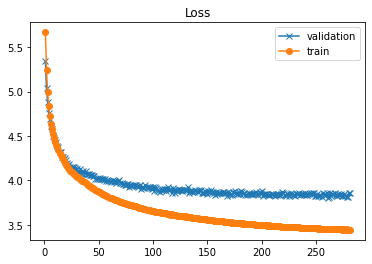

smallest val loss: (261, 3.8062887)
Current Lr:  6.0655926e-05

Time taken for this epoch: 23.48 secs

Epoch 282 Batch 0 Loss 3.5529
Epoch 282 Batch 150 Loss 3.4035
Epoch 282 Batch 300 Loss 3.4221
Epoch 282 Batch 450 Loss 3.4261
Epoch 282 Batch 600 Loss 3.4361
Epoch 282 Batch 750 Loss 3.4430
validation started ...

* Validation loss: 3.850170850753784 

* Train Loss 3.4442


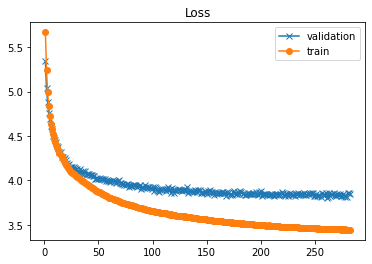

smallest val loss: (261, 3.8062887)
Current Lr:  6.0056114e-05

Time taken for this epoch: 23.51 secs

Epoch 283 Batch 0 Loss 3.2467
Epoch 283 Batch 150 Loss 3.4185
Epoch 283 Batch 300 Loss 3.4233
Epoch 283 Batch 450 Loss 3.4243
Epoch 283 Batch 600 Loss 3.4318
Epoch 283 Batch 750 Loss 3.4433
validation started ...

* Validation loss: 3.8280913829803467 

* Train Loss 3.4445


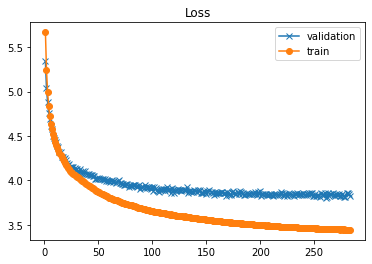

smallest val loss: (261, 3.8062887)
Current Lr:  5.9462203e-05

Time taken for this epoch: 23.51 secs

Epoch 284 Batch 0 Loss 3.3351
Epoch 284 Batch 150 Loss 3.4284
Epoch 284 Batch 300 Loss 3.4264
Epoch 284 Batch 450 Loss 3.4330
Epoch 284 Batch 600 Loss 3.4334
Epoch 284 Batch 750 Loss 3.4416
validation started ...

* Validation loss: 3.828599452972412 

* Train Loss 3.4421


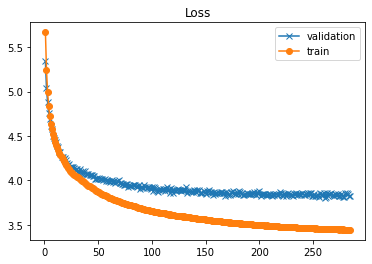

smallest val loss: (261, 3.8062887)
Current Lr:  5.8874197e-05

Time taken for this epoch: 23.46 secs

Epoch 285 Batch 0 Loss 3.4233
Epoch 285 Batch 150 Loss 3.4078
Epoch 285 Batch 300 Loss 3.4133
Epoch 285 Batch 450 Loss 3.4290
Epoch 285 Batch 600 Loss 3.4364
Epoch 285 Batch 750 Loss 3.4391
validation started ...

* Validation loss: 3.83921217918396 

* Train Loss 3.4414


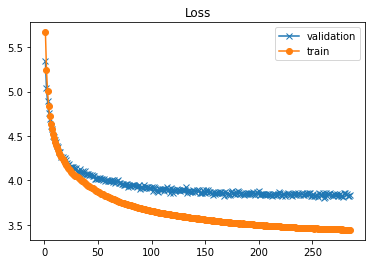

smallest val loss: (261, 3.8062887)
Current Lr:  5.8292004e-05

Time taken for this epoch: 23.52 secs

Epoch 286 Batch 0 Loss 3.3242
Epoch 286 Batch 150 Loss 3.4033
Epoch 286 Batch 300 Loss 3.4144
Epoch 286 Batch 450 Loss 3.4227
Epoch 286 Batch 600 Loss 3.4296
Epoch 286 Batch 750 Loss 3.4370
validation started ...

* Validation loss: 3.8447463512420654 

* Train Loss 3.4392


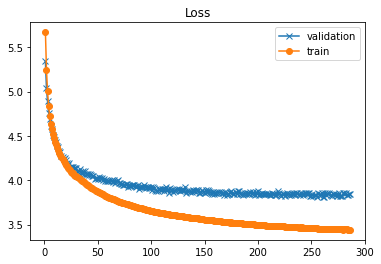

smallest val loss: (261, 3.8062887)
Current Lr:  5.771556e-05

Time taken for this epoch: 23.60 secs

Epoch 287 Batch 0 Loss 3.5032
Epoch 287 Batch 150 Loss 3.4078
Epoch 287 Batch 300 Loss 3.4239
Epoch 287 Batch 450 Loss 3.4316
Epoch 287 Batch 600 Loss 3.4320
Epoch 287 Batch 750 Loss 3.4386
validation started ...

* Validation loss: 3.8324875831604004 

* Train Loss 3.4397


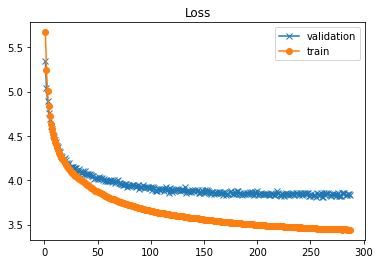

smallest val loss: (261, 3.8062887)
Current Lr:  5.7144818e-05

Time taken for this epoch: 23.56 secs

Epoch 288 Batch 0 Loss 3.6150
Epoch 288 Batch 150 Loss 3.4184
Epoch 288 Batch 300 Loss 3.4239
Epoch 288 Batch 450 Loss 3.4339
Epoch 288 Batch 600 Loss 3.4296
Epoch 288 Batch 750 Loss 3.4373
validation started ...

* Validation loss: 3.8262555599212646 

* Train Loss 3.4391


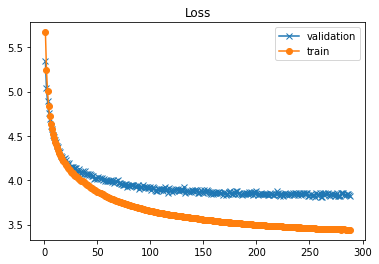

smallest val loss: (261, 3.8062887)
Current Lr:  5.6579724e-05

Time taken for this epoch: 23.63 secs

Epoch 289 Batch 0 Loss 3.1765
Epoch 289 Batch 150 Loss 3.4113
Epoch 289 Batch 300 Loss 3.4176
Epoch 289 Batch 450 Loss 3.4225
Epoch 289 Batch 600 Loss 3.4325
Epoch 289 Batch 750 Loss 3.4378
validation started ...

* Validation loss: 3.8336477279663086 

* Train Loss 3.4405


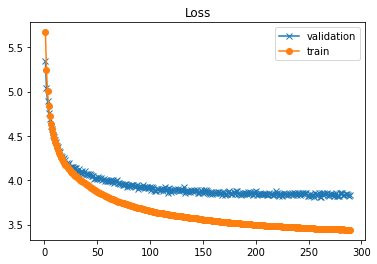

smallest val loss: (261, 3.8062887)
Current Lr:  5.6020217e-05

Time taken for this epoch: 23.43 secs

Epoch 290 Batch 0 Loss 3.1527
Epoch 290 Batch 150 Loss 3.4114
Epoch 290 Batch 300 Loss 3.4228
Epoch 290 Batch 450 Loss 3.4208
Epoch 290 Batch 600 Loss 3.4324
Epoch 290 Batch 750 Loss 3.4403
validation started ...

* Validation loss: 3.8301568031311035 

* Train Loss 3.4404


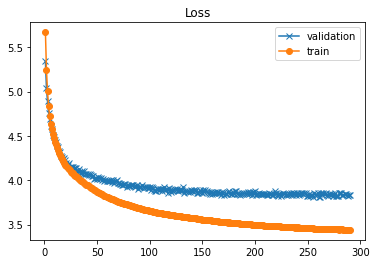

smallest val loss: (261, 3.8062887)
Current Lr:  5.5466244e-05

Time taken for this epoch: 23.47 secs

Epoch 291 Batch 0 Loss 3.0138
Epoch 291 Batch 150 Loss 3.3815
Epoch 291 Batch 300 Loss 3.4110
Epoch 291 Batch 450 Loss 3.4206
Epoch 291 Batch 600 Loss 3.4275
Epoch 291 Batch 750 Loss 3.4367
validation started ...

* Validation loss: 3.8404366970062256 

* Train Loss 3.4374


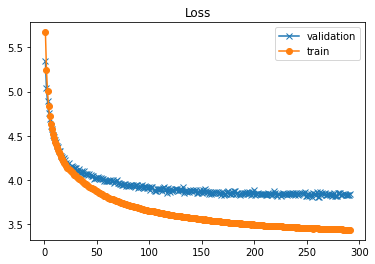

smallest val loss: (261, 3.8062887)
Current Lr:  5.4917742e-05

Time taken for this epoch: 23.44 secs

Epoch 292 Batch 0 Loss 3.3755
Epoch 292 Batch 150 Loss 3.4070
Epoch 292 Batch 300 Loss 3.4167
Epoch 292 Batch 450 Loss 3.4251
Epoch 292 Batch 600 Loss 3.4287
Epoch 292 Batch 750 Loss 3.4375
validation started ...

* Validation loss: 3.8345794677734375 

* Train Loss 3.4390


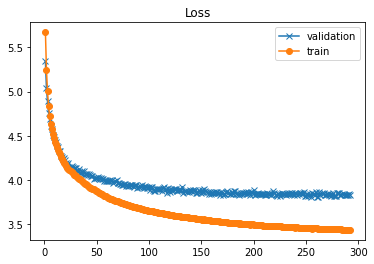

smallest val loss: (261, 3.8062887)
Current Lr:  5.4374676e-05

Time taken for this epoch: 23.45 secs

Epoch 293 Batch 0 Loss 3.4829
Epoch 293 Batch 150 Loss 3.4059
Epoch 293 Batch 300 Loss 3.4189
Epoch 293 Batch 450 Loss 3.4276
Epoch 293 Batch 600 Loss 3.4319
Epoch 293 Batch 750 Loss 3.4375
validation started ...

* Validation loss: 3.859051465988159 

* Train Loss 3.4388


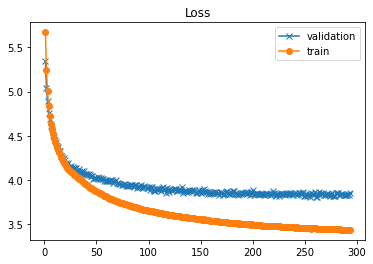

smallest val loss: (261, 3.8062887)
Current Lr:  5.3836968e-05

Time taken for this epoch: 23.54 secs

Epoch 294 Batch 0 Loss 3.2838
Epoch 294 Batch 150 Loss 3.4089
Epoch 294 Batch 300 Loss 3.4265
Epoch 294 Batch 450 Loss 3.4297
Epoch 294 Batch 600 Loss 3.4283
Epoch 294 Batch 750 Loss 3.4378
validation started ...

* Validation loss: 3.835792303085327 

* Train Loss 3.4389


smallest val loss: (261, 3.8062887)
Current Lr:  5.3304582e-05

Time taken for this epoch: 23.57 secs

Epoch 295 Batch 0 Loss 3.1629
Epoch 295 Batch 150 Loss 3.4026
Epoch 295 Batch 300 Loss 3.4181
Epoch 295 Batch 450 Loss 3.4227
Epoch 295 Batch 600 Loss 3.4252
Epoch 295 Batch 750 Loss 3.4373
validation started ...

* Validation loss: 3.8555502891540527 

* Train Loss 3.4383


smallest val loss: (261, 3.8062887)
Current Lr:  5.277747e-05

Time taken for this epoch: 23.59 secs

Epoch 296 Batch 0 Loss 3.5279
Epoch 296 Batch 150 Loss 3.3868
Epoch 296 Batch 300 Loss 3.4076
Epoch 296 Batch 450 Loss 3.4179
Epoch 296 Batch 600 Loss 3.4261
Epoch 296 Batch 750 Loss 3.4338
validation started ...

* Validation loss: 3.8597352504730225 

* Train Loss 3.4361


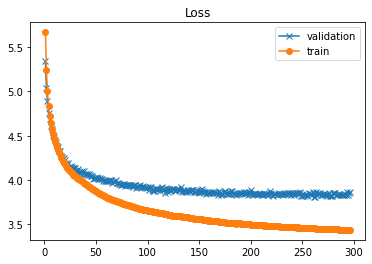

smallest val loss: (261, 3.8062887)
Current Lr:  5.225554e-05

Time taken for this epoch: 23.39 secs

Epoch 297 Batch 0 Loss 3.3396
Epoch 297 Batch 150 Loss 3.3947
Epoch 297 Batch 300 Loss 3.4139
Epoch 297 Batch 450 Loss 3.4164
Epoch 297 Batch 600 Loss 3.4255
Epoch 297 Batch 750 Loss 3.4361
validation started ...

* Validation loss: 3.8227362632751465 

* Train Loss 3.4371


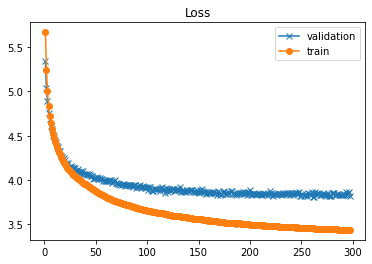

smallest val loss: (261, 3.8062887)
Current Lr:  5.1738796e-05

Time taken for this epoch: 23.50 secs

Epoch 298 Batch 0 Loss 3.2329
Epoch 298 Batch 150 Loss 3.4094
Epoch 298 Batch 300 Loss 3.4182
Epoch 298 Batch 450 Loss 3.4208
Epoch 298 Batch 600 Loss 3.4251
Epoch 298 Batch 750 Loss 3.4374
validation started ...

* Validation loss: 3.824770212173462 

* Train Loss 3.4374


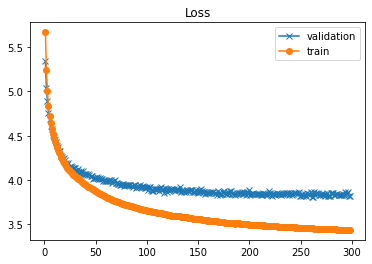

smallest val loss: (261, 3.8062887)
Current Lr:  5.1227158e-05

Time taken for this epoch: 23.57 secs

Epoch 299 Batch 0 Loss 3.4357
Epoch 299 Batch 150 Loss 3.3987
Epoch 299 Batch 300 Loss 3.4188
Epoch 299 Batch 450 Loss 3.4251
Epoch 299 Batch 600 Loss 3.4315
Epoch 299 Batch 750 Loss 3.4342
validation started ...

* Validation loss: 3.8439786434173584 

* Train Loss 3.4363


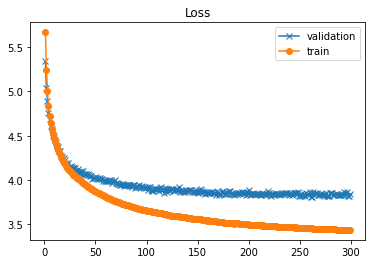

smallest val loss: (261, 3.8062887)
Current Lr:  5.0720588e-05

Time taken for this epoch: 23.58 secs

Epoch 300 Batch 0 Loss 3.3980
Epoch 300 Batch 150 Loss 3.4070
Epoch 300 Batch 300 Loss 3.4152
Epoch 300 Batch 450 Loss 3.4242
Epoch 300 Batch 600 Loss 3.4259
Epoch 300 Batch 750 Loss 3.4348
validation started ...

* Validation loss: 3.8326539993286133 

* Train Loss 3.4376


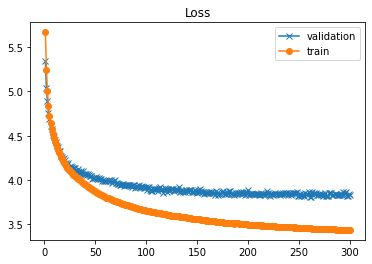

smallest val loss: (261, 3.8062887)
Current Lr:  5.021902e-05

Time taken for this epoch: 23.49 secs



In [66]:
print(params)
print('#'*40)

for epoch in range(ep,EPOCHS+1):
    ep = epoch
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        
        train_step(inp, tar)
    
        if batch % 150 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch , batch, train_loss.result()))
                  
    
    
    val_loss_ = validate().numpy()
    history['val'].append((epoch,val_loss_))
    print ('\n* Train Loss {:.4f}'.format(train_loss.result()))
    history['train'].append((epoch,train_loss.result().numpy()))
    
    
    if best_val_loss-val_loss_ > 0.1:
        ckpt_save_path4 = ckpt_manager4.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path4))  
        best_val_loss = val_loss_
    
    hist(history)
    print('Current Lr: ',optimizer2._decayed_lr('float32').numpy())
    print ('\nTime taken for this epoch: {:.2f} secs\n'.format(time.time() - start))
    print('='*40)

output removed to reduce file size for github

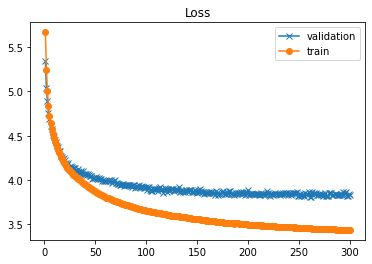

smallest val loss: (261, 3.8062887)


{'d_model': 50,
 'd_out_rate': 0.1,
 'dff': 512,
 'init_lr': 0.001,
 'lmbda_l2': 0.1,
 'num_heads': 5,
 'num_layers': 4}

In [67]:
hist(history)
params

you can use more data or more regularization to avoid the overfitting 